<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Norway/Marine/Marine_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "0OAW.IL"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High     Low   Close  Adj Close  Volume
Date                                                         
2010-04-01   51.50   51.50   51.50   51.50      38.32       0
2010-04-06   52.80   52.80   52.80   52.80      39.29       0
2010-04-07   52.55   52.80   52.51   52.80      39.29    6682
2010-04-08   52.80   52.80   52.80   52.80      39.29       0
2010-04-09   52.80   52.80   52.80   52.80      39.29       0
...            ...     ...     ...     ...        ...     ...
2018-12-21  189.55  192.30  188.55  191.62     184.50  456239
2018-12-24  191.62  191.62  191.62  191.62     184.50       0
2018-12-27  191.71  191.71  182.35  183.15     176.34  371751
2018-12-28  183.40  184.80  182.27  182.60     175.81  112225
2018-12-31  182.60  182.60  182.60  182.60     175.81       0

[2146 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2146.000000  2146.000000  2146.000000  2146.000000  2146.000000  2.146000e+03
mean     95.711249    96.372418    95.022610    95.753229    81.131789  2.491946e+05
std      47.337892    47.720891    46.791334    47.258962    46.515696  1.405988e+06
min       7.800000    22.300000     7.800000    22.300000    16.920000  0.000000e+00
25%      56.465000    57.002500    56.180000    56.912500    42.920000  1.718250e+03
50%      87.320000    87.940000    87.115000    87.610000    68.220000  2.506750e+04
75%     140.015000   140.997500   138.975000   139.942500   123.652500  1.560965e+05
max     204.300000   207.200000   203.800000   206.150000   196.360000  2.927177e+07

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open    High     Low   Close  Adj Close  Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear        mama        fama      SAREXT      DEMA_8       EMA_8      KAMA_8  MIDPOINT_8  MIDPRICE_8    SAR_0.08      SMA_8      TEMA_8   TRIMA_8       WMA_8     MA_8_0    MAVP_8_0      T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5      MA_8_1    MAVP_8_1      T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
2010-06-16   52.00   52.00   52.00   52.00      38.87       0   16          2        167             30             0               1               0                 1      6        2    24        2             2          24   53.871901   53.371079  -55.416346   51.780514   52.474545   53.989492      53.060      53.060   54.014196   52.93375   51.582770   52.6310   52.267222   52.93375   51.900000   53.664861               56.103434                 52.93375               49.764066               57.688275                 52.93375               48.179225               59.273117                 52.93375               46.594383               60.857959                 52.93375               45.009541   52.474545   51.926520   53.561565               55.644228                52.474545               49.304861               57.229070                52.474545               47.720019               58.813912                52.474545               46.135177               60.398753   
2010-06-17   51.10   51.10   51.10   51.10      38.20       0   17          3        168             30             0               1               0                 1      6        2    24        3             0          24   52.485951   53.149797  -55.133365   51.391713   52.169090   53.552551      52.650      52.925   53.749060   52.39375   51.173087   52.1175   51.859722   52.39375   51.550000   53.505218               55.127080                 52.39375               49.660420               56.493745                 52.39375               48.293755               57.860410                 52.39375               46.927090               59.227075                 52.39375               45.560425   52.169090   51.367093   53.386446               54.902420                52.169090               49.435760               56.269085                52.169090               48.069095               57.635751                52.169090               46.702430               59.002416   
2010-06-18   51.50   51.50   51.50   51.50      38.50       0   18

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2096.000000  2096.000000  2096.000000  2096.000000  2096.000000  2.096000e+03  2096.000000  2096.000000  2096.000000    2096.000000   2096.000000     2096.000000     2096.000000       2096.000000  2096.000000  2096.000000  2096.000000  2096.000000   2096.000000  2096.000000  2096.000000  2096.000000  2096.000000  2096.000000  2096.000000  2096.000000  2096.000000  2096.000000  2096.000000  2096.000000  2096.000000  2096.000000  2096.000000  2096.000000  2096.000000  2096.000000             2096.000000              2096.000000             2096.000000             2096.000000              2096.000000             2096.000000             2096.000000              2096.000000             2096.000000             2096.000000              2096.000000             2096.000000  2096.000000  2096.000000  2096.000000             2096.000000              2096.000000             2096.000000             2096.000000              2096.000000             2096.000000             2096.000000   
mean     96.711760    97.382796    96.014198    96.756679    82.113898  2.540165e+05    15.630725     2.033397   189.681775      30.455153      0.033397        0.969466        0.010496          0.992366     6.741889     2.579198    27.450859     2.033397      1.961355    27.450859    96.519872    96.018412     6.221485    96.760189    96.532958    96.519187    96.533745    96.043681    94.884603    96.533746    96.757525    96.534385    96.608884    96.533746    96.720366    96.075829               99.661150                96.533746               93.406343              101.224852                96.533746               91.842641              102.788554                96.533746               90.278939              104.352255                96.533746               88.715237    96.532958    96.713031    96.145484               99.660361                96.532958               93.405554              101.224063                96.532958               91.841852              102.787765   
std      47.448036    47.830075    46.897939    47.364685    46.625086  1.422037e+06     8.702184     1.399567   104.991134       0.794908      0.179714        0.172093        0.101936          0.087057     3.441385     1.117629    14.988921     1.399567      1.404029    14.988921    47.204515    46.823925   105.957740    47.386945    47.205545    47.069149    47.235885    47.028843    46.703280    47.223851    47.372067    47.233177    47.266975    47.223851    47.347984    46.912450               48.185307                47.223851               46.314467               48.684604                47.223851               45.880276               49.195781                47.223851               45.460279               49.718472                47.223851               45.054874    47.205545    47.333849    46.962203               48.167384                47.205545               46.295782               48.666875                47.205545               45.861405               49.178245   
min       7.800000    22.300000     7.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close  Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2010-06-16  0.224936  0.160627  0.225510  0.161545   0.122325       0   16          2        167             30             0               1               0                 1      6        2    24        2             2          24  0.170328  0.165057  0.374394  0.162149  0.162910  0.171462    0.167258    0.167234  0.231766  0.166626  0.161732  0.164517  0.162168  0.166626  0.161628  0.166303                0.174617                 0.166626                0.163855                0.175212                 0.166626                0.164599                0.175802                 0.166626                0.165929                0.176401                 0.166626                0.168553  0.162910  0.161286  0.166428                0.169357                 0.162910                0.160923                0.170105                 0.162910                0.162429                0.170599                 0.162910                0.166067                0.171025                 0.162910   
2010-06-17  0.220356  0.155760  0.220918  0.156649   0.118591       0   17          3        168             30             0               1               0                 1      6        2    24        3             0          24  0.162638  0.163789  0.375092  0.160025  0.161209  0.168965    0.164969    0.166481  0.230437  0.163626  0.159497  0.161673  0.159913  0.163626  0.159708  0.165399                0.169324                 0.163626                0.163273                0.168932                 0.163626                0.165244                0.168593                 0.163626                0.167805                0.168316                 0.163626                0.171632  0.161209  0.158223  0.165439                0.165368                 0.161209                0.161660                0.165096                 0.161209                0.164401                0.164639                 0.161209                0.169253                0.164170                 0.161209   
2010-06-18  0.222392  0.157923  0.222959  0.158825   0.1

140536

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpv0ltxfr9
  JVM stdout: /tmp/tmpv0ltxfr9/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpv0ltxfr9/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 18 days
H2O cluster name:           H2O_from_python_unknownUser_0zkduw
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190906_003108_mod...  0.501409  16.029027                 0.495  0.688754  0.474383
1  DeepLearning_grid_1_AutoML_20190906_003108_mod...  0.500000   0.694454                 0.500  0.500642  0.250643
2  DeepLearning_grid_1_AutoML_20190906_003108_mod...  0.500000   0.692745                 0.500  0.499799  0.249799
3              DeepLearning_1_AutoML_20190906_003108  0.500000  16.447036                 0.500  0.690066  0.476190
4  DeepLearning_grid_1_AutoML_20190906_003108_mod...  0.500000  18.091740                 0.500  0.723747  0.523810
5  DeepLearning_grid_1_AutoML_20190906_003108_mod...  0.500000   0.693235                 0.500  0.500044  0.250044
6  DeepLearning_grid_1_AutoML_20190906_003108_mod...  0.500000  16.447036                 0.500  0.690066  0.476190
7  DeepLearning_grid_1_AutoML_20190906_003108_mod...  0.500000   0.692165                 0.500  0.499509  0.249509
8  DeepLearning_grid_1_AutoML_20190906_003108_mod...  0.499091  18.032435                 0.500  0.723747  0.523810
9  DeepLearning_grid_1_AutoML_20190906_003108_mod...  0.494636  18.091740                 0.500  0.723747  0.523810

variable  relative_importance  scaled_importance  percentage
0                          SUB             1.000000           1.000000    0.001592
1                      CDLDOJI             0.943705           0.943705    0.001503
2                      weekday             0.842794           0.842794    0.001342
3                 CDLSHORTLINE             0.838038           0.838038    0.001334
4                    dayofweek             0.824408           0.824408    0.001313
...                        ...                  ...                ...         ...
1038   BBANDS_upperband_12_2_3             0.550783           0.550783    0.000877
1039                MIDPOINT_8             0.549438           0.549438    0.000875
1040                     WMA_8             0.545410           0.545410    0.000868
1041             MINMAX_min_12             0.544445           0.544445    0.000867
1042  BBANDS_middleband_24_7_4             0.543205           0.543205    0.000865

[1043 rows x 4 columns]

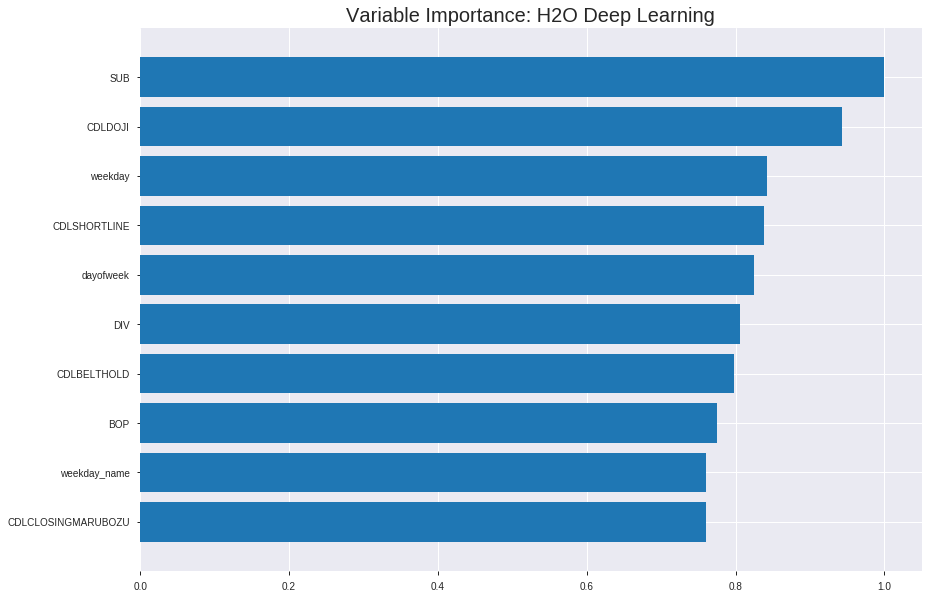

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190906_003108_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.21703407393306218
RMSE: 0.465869159671535
LogLoss: 0.602533338453092
Mean Per-Class Error: 0.3384272291200102
AUC: 0.7495783292247463
pr_auc: 0.7499444729232113
Gini: 0.49915665844949264
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17448692539951363: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      196  463   0.7026   (463.0/659.0)
1      20   787   0.0248   (20.0/807.0)
Total  216  1250  0.3295   (483.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.174487     0.765192  337
max f2                       0.0872414    0.887097  360
max f0point5                 0.330772     0.696849  244
max accuracy                 0.18464      0.672578  331
max precision                0.999928     1         0
max recall                   0.0247721    1         383
max specificity              0.999928     1         0
max absolute_mcc             0.163065     0.383907  343
max min_per_class_accuracy   0.315259     0.620818  253
max mean_per_class_accuracy  0.330772     0.661573  244

Gains/Lift Table: Avg response rate: 55.05 %, avg score: 43.97 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102319                   0.999989           1.8166     1.8166             1                0.999997    1                           0.999997            0.0185874       0.0185874                  81.6605   81.6605
    2        0.0204638                   0.999885           1.8166     1.8166             1                0.999946    1                           0.999972            0.0185874       0.0371747                  81.6605   81.6605
    3        0.0300136                   0.999565           1.8166     1.8166             1                0.999765    1                           0.999906            0.0173482       0.0545229                  81.6605   81.6605
    4        0.0402456                   0.998718           1.8166     1.8166             1                0.99926     1                           0.999742            0.0185874       0.0731103                  81.6605   81.6605
    5        0.0504775                   0.997788           1.8166     1.8166             1                0.998205    1                           0.99943             0.0185874       0.0916976                  81.6605   81.6605
    6        0.100273                    0.966899           1.76683    1.79189            0.972603         0.987371    0.986395                    0.993441            0.0879802       0.179678                   76.6835   79.1889
    7        0.150068                    0.883182           1.54287    1.70926            0.849315         0.933514    0.940909                    0.973556            0.0768278       0.256506                   54.287    70.926
    8        0.200546                    0.78324            1.39928    1.63124            0.77027          0.834643    0.897959                    0.938592            0.070632        0.327138                   39.9277   63.1237
    9        0.300136                    0.538699           1.10738    1.45741            0.609589         0.669062    0.802273                    0.849157            0.110285        0.437423                   10.7382   45.7412
    10       0.400409                    0.391915           1.03806    1.3524             0.571429         0.45684     0.744463                    0.750911            0.104089        0.541512                   3.80598   35.2396
    11       0.653479                    0.314226           0.969509   1.20412            0.533693         0.326211    0.662839                    0.586439            0.245353        0.786865                   -3.04913  20.4117
    12       0.699864                    0.287541           0.854873   1.18097            0.470588         0.299054    0.650097                    0.567392            0.039653        0.826518                   -14.5127  18.097
    13       0.800136                    0.223377           0.976271   1.15532            0.537415         0.255964    0.635976                    0.528364            0.0978934       0.924411                   -2.37294  15.5317
    14       0.899727                    0.048523           0.709222   1.10594            0.390411         0.161456    0.608795                    0.487751            0.070632        0.995043                   -29.0778  10.5939
    15       1                           2.8868e-14         0.0494314  1                  0.0272109        0.00867179  0.550477                    0.439712            0.00495663      1                          -95.0569  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.4230820919722194
RMSE: 0.6504476089372759
LogLoss: 6.043156310992385
Mean Per-Class Error: 0.49804028803208455
AUC: 0.45324036095159964
pr_auc: 0.3896739829829042
Gini: -0.09351927809680072
Confusion Matrix (Act/Pred) for max f1 @ threshold = 8.760806197908768e-09: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    212  1        (212.0/212.0)
1      0    207  0        (0.0/207.0)
Total  0    419  0.506    (212.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       8.76081e-09  0.661342  296
max f2                       8.76081e-09  0.829992  296
max f0point5                 8.76081e-09  0.549655  296
max accuracy                 8.60526e-07  0.49642   277
max precision                7.03941e-07  0.49505   281
max recall                   8.76081e-09  1         296
max specificity              1            0.759434  0
max absolute_mcc             0.99999      0.104677  4
max min_per_class_accuracy   0.291268     0.466981  87
max mean_per_class_accuracy  7.03941e-07  0.50196   281

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 39.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.169451                    1                  0.826767  0.826767           0.408451         1            0.408451                    1                   0.140097        0.140097                   -17.3233  -17.3233
    2        0.200477                    1                  0.778521  0.819301           0.384615         1            0.404762                    1                   0.0241546       0.164251                   -22.1479  -18.0699
    3        0.300716                    0.428022           1.01208   0.88356            0.5              0.708754     0.436508                    0.902918            0.101449        0.2657                     1.20773   -11.644
    4        0.460621                    0.314226           1.05739   0.943906           0.522388         0.333467     0.466321                    0.705233            0.169082        0.434783                   5.73942   -5.60937
    5        0.501193                    0.291268           0.833475  0.934967           0.411765         0.302148     0.461905                    0.672602            0.0338164       0.468599                   -16.6525  -6.50334
    6        0.599045                    0.255039           1.1355    0.967723           0.560976         0.271801     0.478088                    0.607133            0.111111        0.57971                    13.5501   -3.22767
    7        0.699284                    0.209737           0.915689  0.960264           0.452381         0.235092     0.474403                    0.553803            0.0917874       0.671498                   -8.4311   -3.97355
    8        0.799523                    0.000789569        1.15666   0.984887           0.571429         0.0987283    0.486567                    0.496748            0.115942        0.78744                    15.666    -1.51128
    9        0.899761                    7.51702e-06        1.06027   0.993285           0.52381          0.000137451  0.490716                    0.441423            0.10628         0.89372                    6.02715   -0.671459
    10       1                           8.76081e-09        1.06027   1                  0.52381          1.93309e-06  0.494033                    0.397176            0.10628         1                          6.02715   0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 00:46:57  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 00:47:02  8.316 sec         116 obs/sec       0.388131  1             569        0.660124         3.60451             -0.761005      0.511681        0.39623            0.605535         0.449523                         0.721348           10.8654               -1.08167         0.470673          0.263149             0.962841           0.501193
    2019-09-06 00:47:35  41.184 sec        177 obs/sec       4.19714   11            6153       0.570062         0.865636            -0.313266      0.631319        0.674813           1.57439          0.397681                         0.649693           7.56574               -0.688643        0.469807          0.319959             0.92007            0.505967
    2019-09-06 00:48:08  1 min 14.039 sec  211 obs/sec       9.24761   24            13557      0.477149         0.643266            0.0799371      0.666003        0.723926           1.8166           0.379263                         0.623996           7.86451               -0.557706        0.476404          0.30281              0.906926           0.505967
    2019-09-06 00:48:42  1 min 47.904 sec  226 obs/sec       14.6514   38            21479      0.541558         0.923535            -0.185221      0.68857         0.745469           1.8166           0.379945                         0.679992           8.10812               -0.849821        0.539023          0.535922             2.02415            0.505967
    2019-09-06 00:49:13  2 min 19.125 sec  233 obs/sec       19.5914   51            28721      0.45318          0.588541            0.170053       0.729737        0.737914           1.8166           0.328786                         0.598285           6.33173               -0.431985        0.53352           0.484223             0.809662           0.505967
    2019-09-06 00:49:45  2 min 51.557 sec  236 obs/sec       24.6296   64            36107      0.465869         0.602533            0.122925       0.749578        0.749944           1.8166           0.329468                         0.650448           6.04316               -0.692569        0.45324           0.389674             0.826767           0.505967
    2019-09-06 00:50:17  3 min 23.297 sec  239 obs/sec       29.5607   77            43336      0.416282         0.494119            0.299701       0.793676        0.792191           1.8166           0.303547                         0.602935           8.02423               -0.45433         0.526957          0.543051             1.03384            0.505967
    2019-09-06 00:50:51  3 min 57.116 sec  238 obs/sec       34.5177   90            50603      0.497822         0.773319            -0.00151463    0.784408        0.7212             1.8166           0.302865                         0.629278           7.61749               -0.584188        0.537724          0.52664              1.61932            0.505967
    2019-09-06 00:51:22

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
SUB                       1.0                    1.0                  0.0015922695588979998
CDLDOJI                   0.9437052607536316     0.9437052607536316   0.001502633159269907
weekday                   0.8427937030792236     0.8427937030792236   0.0013419547578439673
CDLSHORTLINE              0.8380382657051086     0.8380382657051086   0.0013343828196739182
dayofweek                 0.8244084119796753     0.8244084119796753   0.0013126804184946782
---                       ---                    ---                  ---
BBANDS_upperband_12_2_3   0.5507829785346985     0.5507829785346985   0.0008769949702799709
MIDPOINT_8                0.5494384169578552     0.5494384169578552   0.0008748540658110995
WMA_8                     0.5454102754592896     0.5454102754592896   0.0008684401787239996
MINMAX_min_12             0.5444445013999939     0.5444445013999939   0.0008669024060886098
BBANDS_middleband_24_7_4  0.5432049036026001     0.5432049036026001   0.0008649286322505427


See the whole table with table.as_data_frame()


('accuracy', 0.5285714285714286)

('F1', 0.6896551724137931)

('auc', 0.5014090909090909)

('logloss', 16.029026843824933)

('mean_per_class_error', 0.4945454545454545)

('rmse', 0.6887544686044383)

('mse', 0.47438271802258225)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


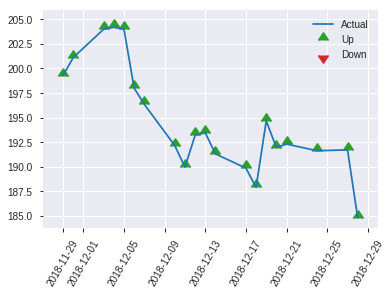


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.47438271802258225
RMSE: 0.6887544686044383
LogLoss: 16.029026843824933
Mean Per-Class Error: 0.4945454545454545
AUC: 0.5014090909090909
pr_auc: 0.014306450946154101
Gini: 0.0028181818181818308
Confusion Matrix (Act/Pred) for max f1 @ threshold = 3.868916916901605e-05: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      1    99   0.99     (99.0/100.0)
1      0    110  0        (0.0/110.0)
Total  1    209  0.4714   (99.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       3.86892e-05  0.689655   5
max f2                       3.86892e-05  0.847458   5
max f0point5                 3.86892e-05  0.581395   5
max accuracy                 0.0189837    0.528571   3
max precision                0.0189837    0.52657    3
max recall                   3.86892e-05  1          5
max specificity              1            0.03       0
max absolute_mcc             3.86892e-05  0.0725476  5
max min_per_class_accuracy   1            0.03       0
max mean_per_class_accuracy  0.0189837    0.505455   3

Gains/Lift Table: Avg response rate: 52.38 %, avg score: 97.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.971429                    1                  1.00134   1.00134            0.52451          1         0.52451                     1                   0.972727        0.972727                   0.13369   0.13369
    2        1                           3.10313e-05        0.954545  1                  0.5              0.190451  0.52381                     0.97687             0.0272727       1                          -4.54545  0

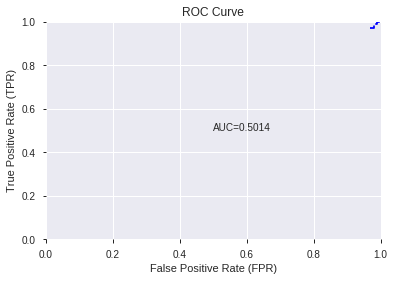

This function is available for GLM models only


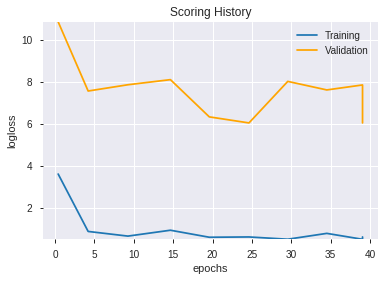

--2019-09-06 01:02:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.1.88
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.1.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  19.3MB/s    in 19s     

2019-09-06 01:02:46 (18.5 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unknown

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190906_003108_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190906_003108_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_9435',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190906_010259_model_9  0.659818  0.672610              0.376818  0.483419  0.233694
1  DeepLearning_grid_1_AutoML_20190906_010259_model_6  0.659364  0.660970              0.356364  0.483125  0.233409
2  DeepLearning_grid_1_AutoML_20190906_010259_model_8  0.636727  0.692207              0.428636  0.487232  0.237395
3  DeepLearning_grid_1_AutoML_20190906_010259_model_5  0.589091  0.716397              0.440000  0.506321  0.256361
4  DeepLearning_grid_1_AutoML_20190906_010259_model_7  0.586545  1.134657              0.391364  0.552773  0.305558
5  DeepLearning_grid_1_AutoML_20190906_010259_model_1  0.584909  1.732697              0.484545  0.599601  0.359521
6  DeepLearning_grid_1_AutoML_20190906_010259_model_3  0.583636  1.142003              0.410000  0.550108  0.302619
7  DeepLearning_grid_1_AutoML_20190906_010259_model_2  0.570909  1.101320              0.478636  0.553396  0.306247
8  DeepLearning_grid_1_AutoML_20190906_010259_model_4  0.555182  1.763545              0.500000  0.624805  0.390381
9               DeepLearning_1_AutoML_20190906_010259  0.553545  0.765247              0.469091  0.524606  0.275212

variable  relative_importance  scaled_importance  percentage
0                    SUB             1.000000           1.000000    0.032463
1                    DIV             0.906586           0.906586    0.029431
2                 TRANGE             0.783669           0.783669    0.025440
3                CDLDOJI             0.758293           0.758293    0.024617
4                    BOP             0.713360           0.713360    0.023158
5            CDLBELTHOLD             0.706679           0.706679    0.022941
6           CDLSHORTLINE             0.653529           0.653529    0.021216
7              CDLHAMMER             0.638780           0.638780    0.020737
8                  MFI_8             0.627758           0.627758    0.020379
9            CDLLONGLINE             0.627096           0.627096    0.020357
10                MFI_30             0.626254           0.626254    0.020330
11    CDLCLOSINGMARUBOZU             0.623676           0.623676    0.020246
12                   SIN             0.621499           0.621499    0.020176
13         CDLHIKKAKEMOD             0.618760           0.618760    0.020087
14                MFI_24             0.611751           0.611751    0.019859
15           STOCH_slowk             0.610282           0.610282    0.019812
16             STDDEV_12             0.608059           0.608059    0.019739
17          CDLENGULFING             0.605268           0.605268    0.019649
18          aroondown_24             0.603972           0.603972    0.019607
19         days_in_month             0.602393           0.602393    0.019556
20             aroonup_8             0.601387           0.601387    0.019523
21          aroondown_30             0.599696           0.599696    0.019468
22          is_month_end             0.593863           0.593863    0.019279
23              CORREL_8             0.592367           0.592367    0.019230
24           aroondown_8             0.590984           0.590984    0.019185
25           CDLMARUBOZU             0.590164           0.590164    0.019159
26            CDLHIKKAKE             0.589596           0.589596    0.019140
27          aroondown_12             0.589481           0.589481    0.019136
28                  week             0.588982           0.588982    0.019120
29                MFI_20             0.588865           0.588865    0.019116
30          STOCHF_fastk             0.585176           0.585176    0.018997
31     HT_PHASOR_inphase             0.583467           0.583467    0.018941
32          MACDEXT_hist             0.581227           0.581227    0.018868
33                   day             0.578950           0.578950    0.018795
34        CDLRICKSHAWMAN             0.577166           0.577166    0.018737
35             dayofweek             0.576529           0.576529    0.018716
36      is_quarter_start             0.573814           0.573814    0.018628
37          weekday_name             0.570222           0.570222    0.018511
38        STOCHRSI_fastk             0.568882           0.568882    0.018468
39        CDLHARAMICROSS             0.565112           0.565112    0.018345
40  HT_PHASOR_quadrature             0.564824           0.564824    0.018336
41           HT_DCPERIOD             0.564794           0.564794    0.018335
42               weekday             0.562569           0.562569    0.018263
43             CDLTAKURI             0.561154           0.561154    0.018217
44     CDLDARKCLOUDCOVER             0.560936           0.560936    0.018210
45               BETA_12             0.556804           0.556804    0.018076
46             CDLHARAMI             0.556221           0.556221    0.018057
47           AROONOSC_12             0.555529           0.555529    0.018034
48                MFI_12             0.546536           0.546536    0.017742
49          HT_TRENDMODE             0.541233           0.541233    0.017570

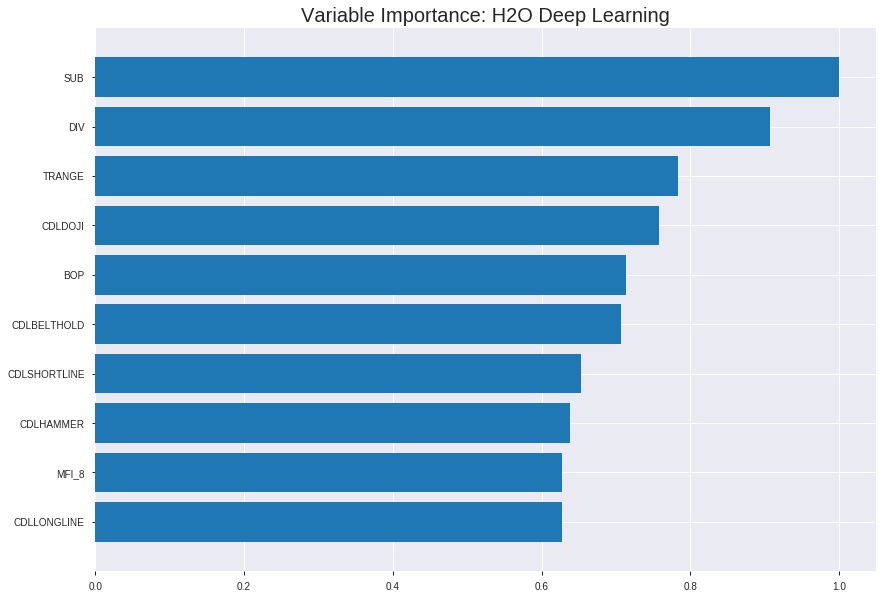

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190906_010259_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2283203158541493
RMSE: 0.4778287515984668
LogLoss: 0.648351182316743
Mean Per-Class Error: 0.3738513349617253
AUC: 0.6685883947929065
pr_auc: 0.6998639104252845
Gini: 0.3371767895858131
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4055702058596208: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      137  522   0.7921   (522.0/659.0)
1      51   756   0.0632   (51.0/807.0)
Total  188  1278  0.3909   (573.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.40557      0.72518   296
max f2                       0.282811     0.863031  370
max f0point5                 0.550109     0.665752  173
max accuracy                 0.521487     0.639154  205
max precision                0.760703     1         0
max recall                   0.236239     1         387
max specificity              0.760703     1         0
max absolute_mcc             0.505466     0.262802  222
max min_per_class_accuracy   0.568463     0.6171    147
max mean_per_class_accuracy  0.550109     0.626149  173

Gains/Lift Table: Avg response rate: 55.05 %, avg score: 53.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102319                   0.674654           1.6955    1.6955             0.933333         0.690766  0.933333                    0.690766            0.0173482       0.0173482                  69.5498   69.5498
    2        0.0204638                   0.660193           1.8166    1.75605            1                0.665869  0.966667                    0.678317            0.0185874       0.0359356                  81.6605   75.6051
    3        0.0300136                   0.652268           1.55709   1.69275            0.857143         0.655522  0.931818                    0.671064            0.0148699       0.0508055                  55.709    69.2745
    4        0.0402456                   0.647891           1.45328   1.63187            0.8              0.650054  0.898305                    0.665723            0.0148699       0.0656753                  45.3284   63.1865
    5        0.0504775                   0.644564           1.45328   1.59567            0.8              0.64633   0.878378                    0.661792            0.0148699       0.0805452                  45.3284   59.5666
    6        0.100273                    0.627269           1.24425   1.42115            0.684932         0.634992  0.782313                    0.648483            0.0619579       0.142503                   24.425    42.1153
    7        0.150068                    0.619237           1.19448   1.34594            0.657534         0.623229  0.740909                    0.640104            0.0594796       0.201983                   19.448    34.5939
    8        0.200546                    0.610136           1.25198   1.32229            0.689189         0.614796  0.727891                    0.633734            0.063197        0.26518                    25.1984   32.2291
    9        0.300136                    0.596719           1.19448   1.27988            0.657534         0.603168  0.704545                    0.623591            0.118959        0.384139                   19.448    27.9881
    10       0.400409                    0.583822           1.12456   1.24099            0.619048         0.590572  0.683135                    0.615322            0.112763        0.496902                   12.4565   24.0985
    11       0.5                         0.569857           1.0825    1.20942            0.59589          0.57743   0.665757                    0.607775            0.107807        0.604709                   8.24973   20.9418
    12       0.600273                    0.551953           1.08749   1.18905            0.598639         0.561619  0.654545                    0.600065            0.109046        0.713755                   8.74913   18.905
    13       0.699864                    0.519937           0.933187  1.15264            0.513699         0.537807  0.634503                    0.591205            0.0929368       0.806691                   -6.68126  15.2641
    14       0.800136                    0.468721           0.729113  1.09956            0.401361         0.495648  0.605286                    0.57923             0.0731103       0.879802                   -27.0887  9.95647
    15       0.899727                    0.374385           0.684337  1.0536             0.376712         0.423027  0.579985                    0.56194             0.0681537       0.947955                   -31.5663  5.36032
    16       1                           0.00801484         0.51903   1                  0.285714         0.304866  0.550477                    0.536162          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.238104525046466
RMSE: 0.487959552674672
LogLoss: 0.6682916511453728
Mean Per-Class Error: 0.3979696472518457
AUC: 0.6152584085315833
pr_auc: 0.5600334500533622
Gini: 0.23051681706316662
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38450963967288965: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      39   173  0.816    (173.0/212.0)
1      9    198  0.0435   (9.0/207.0)
Total  48   371  0.4344   (182.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.38451      0.685121  351
max f2                       0.307678     0.834011  381
max f0point5                 0.512837     0.598935  217
max accuracy                 0.512837     0.601432  217
max precision                0.587458     0.616438  69
max recall                   0.247848     1         395
max specificity              0.680564     0.995283  0
max absolute_mcc             0.38451      0.220532  351
max min_per_class_accuracy   0.524269     0.589623  198
max mean_per_class_accuracy  0.512837     0.60203   217

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 50.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119332                   0.648318           0.809662  0.809662           0.4              0.658256  0.4                         0.658256            0.00966184      0.00966184                 -19.0338  -19.0338
    2        0.0214797                   0.634738           0.506039  0.674718           0.25             0.638971  0.333333                    0.649685            0.00483092      0.0144928                  -49.3961  -32.5282
    3        0.0310263                   0.625104           1.01208   0.778521           0.5              0.630302  0.384615                    0.643721            0.00966184      0.0241546                  1.20773   -22.1479
    4        0.0405728                   0.619139           1.51812   0.952543           0.75             0.622465  0.470588                    0.638719            0.0144928       0.0386473                  51.8116   -4.74567
    5        0.0501193                   0.614481           1.51812   1.06027            0.75             0.61572   0.52381                     0.634339            0.0144928       0.0531401                  51.8116   6.02715
    6        0.100239                    0.599694           1.15666   1.10847            0.571429         0.60692   0.547619                    0.620629            0.057971        0.111111                   15.666    10.8466
    7        0.150358                    0.590171           1.34944   1.18879            0.666667         0.594492  0.587302                    0.611917            0.0676329       0.178744                   34.9436   18.8789
    8        0.200477                    0.582626           1.15666   1.18076            0.571429         0.586742  0.583333                    0.605623            0.057971        0.236715                   15.666    18.0757
    9        0.300716                    0.56235            1.25305   1.20485            0.619048         0.571434  0.595238                    0.594227            0.125604        0.362319                   25.3048   20.4854
    10       0.400955                    0.549953           0.963883  1.14461            0.47619          0.556611  0.565476                    0.584823            0.0966184       0.458937                   -3.61169  14.4611
    11       0.501193                    0.524269           1.34944   1.18558            0.666667         0.536995  0.585714                    0.575257            0.135266        0.594203                   34.9436   18.5576
    12       0.599045                    0.500284           0.987392  1.1532             0.487805         0.51164   0.569721                    0.564866            0.0966184       0.690821                   -1.26075  15.3204
    13       0.699284                    0.466135           0.819301  1.10534            0.404762         0.48291   0.546075                    0.553118            0.0821256       0.772947                   -18.0699  10.534
    14       0.799523                    0.424515           1.06027   1.09969            0.52381          0.445854  0.543284                    0.53967             0.10628         0.879227                   6.02715   9.969
    15       0.899761                    0.378642           0.819301  1.06845            0.404762         0.401761  0.527851                    0.524306            0.0821256       0.961353                   -18.0699  6.8453
    16       1                           0.0844457          0.385553  1                  0.190476         0.304945  0.494033                    0.502317         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:09:42  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 01:09:44  2 min 33.944 sec  522 obs/sec       0.748295  1             1097       0.63506          1.43177             -0.629813      0.651388        0.677544           1.57439          0.394952                         0.670996           1.55007               -0.801198        0.581294          0.546289             1.21449            0.463007
    2019-09-06 01:09:56  2 min 45.626 sec  867 obs/sec       7.49795   10            10992      0.477829         0.648351            0.0773148      0.668588        0.699864           1.6955           0.390859                         0.48796            0.668292              0.0474463        0.615258          0.560033             0.809662           0.434368
    2019-09-06 01:10:07  2 min 57.172 sec  1001 obs/sec      15.7231   21            23050      0.478216         0.648905            0.0758185      0.683665        0.715053           1.8166           0.389495                         0.489518           0.671665              0.0413507        0.604332          0.553194             0.404831           0.420048
    2019-09-06 01:10:19  3 min  9.141 sec  1102 obs/sec      25.4754   34            37347      0.470845         0.6337              0.104087       0.691701        0.722325           1.8166           0.369031                         0.493171           0.680022              0.0269908        0.60742           0.556006             0.404831           0.443914
    2019-09-06 01:10:30  3 min 20.306 sec  1174 obs/sec      35.2244   47            51639      0.470492         0.632931            0.105431       0.705299        0.730829           1.57439          0.372442                         0.496725           0.687272              0.0129173        0.603386          0.551119             0.404831           0.434368
    2019-09-06 01:10:42  3 min 31.527 sec  1200 obs/sec      44.249    59            64869      0.461147         0.613091            0.140613       0.716504        0.746225           1.8166           0.364256                         0.498192           0.691567              0.00707668       0.595206          0.538909             0.404831           0.436754
    2019-09-06 01:10:53  3 min 42.847 sec  1249 obs/sec      54.7462   73            80258      0.451696         0.59349             0.175481       0.743802        0.779019           1.8166           0.354025                         0.506737           0.713359              -0.0272744       0.586751          0.550157             0.809662           0.443914
    2019-09-06 01:10:54  3 min 43.996 sec  1248 obs/sec      54.7462   73            80258      0.477829         0.648351            0.0773148      0.668588        0.699864           1.6955           0.390859                         0.48796            0.668292              0.0474463        0.615258          0.560033             0.809662           0.434368

Variable Importances: 


variable      relative_importance    scaled_importance    percentage
------------  ---------------------  -------------------  --------------------
SUB           1.0                    1.0                  0.032463111591696486
DIV           0.9065859317779541     0.9065859317779541   0.029430600270769863
TRANGE        0.7836692929267883     0.7836692929267883   0.025440343707268213
CDLDOJI       0.7582928538322449     0.7582928538322449   0.02461654553314216
BOP           0.713360071182251      0.713360071182251    0.02315788759584996
---           ---                    ---                  ---
BETA_12       0.5568035244941711     0.5568035244941711   0.018075574950304187
CDLHARAMI     0.5562206506729126     0.5562206506729126   0.01805665305240079
AROONOSC_12   0.555528998374939      0.555528998374939    0.018034199866669022
MFI_12        0.5465360283851624     0.5465360283851624   0.017742260078350124
HT_TRENDMODE  0.5412331223487854     0.5412331223487854   0.01757011124793094


See the whole table with table.as_data_frame()


('accuracy', 0.6571428571428571)

('F1', 0.7304964539007093)

('auc', 0.6598181818181819)

('logloss', 0.6726100010412639)

('mean_per_class_error', 0.34272727272727277)

('rmse', 0.4834189082128085)

('mse', 0.23369384081766376)

deeplearning prediction progress: |███████████████████████████████████████| 100%


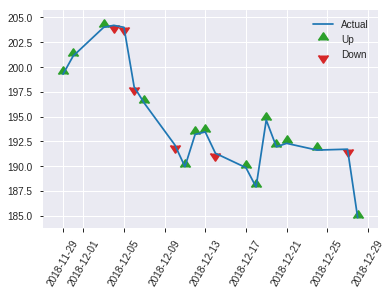


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.23369384081766376
RMSE: 0.4834189082128085
LogLoss: 0.6726100010412639
Mean Per-Class Error: 0.34272727272727277
AUC: 0.6598181818181819
pr_auc: 0.6072069579516015
Gini: 0.3196363636363637
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3743423446447388: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      31   69   0.69     (69.0/100.0)
1      7    103  0.0636   (7.0/110.0)
Total  38   172  0.3619   (76.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.374342     0.730496  171
max f2                       0.293135     0.852895  198
max f0point5                 0.498347     0.674157  105
max accuracy                 0.498347     0.657143  105
max precision                0.65488      1         0
max recall                   0.00520568   1         209
max specificity              0.65488      1         0
max absolute_mcc             0.374342     0.319607  171
max min_per_class_accuracy   0.498347     0.654545  105
max mean_per_class_accuracy  0.498347     0.657273  105

Gains/Lift Table: Avg response rate: 52.38 %, avg score: 47.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0142857                   0.640152           0.636364  0.636364           0.333333         0.646007  0.333333                    0.646007            0.00909091      0.00909091                 -36.3636  -36.3636
    2        0.0238095                   0.632574           0         0.381818           0                0.637305  0.2                         0.642526            0               0.00909091                 -100      -61.8182
    3        0.0333333                   0.614995           1.90909   0.818182           1                0.617045  0.428571                    0.635246            0.0181818       0.0272727                  90.9091   -18.1818
    4        0.0428571                   0.608571           1.90909   1.06061            1                0.609763  0.555556                    0.629583            0.0181818       0.0454545                  90.9091   6.06061
    5        0.052381                    0.605878           0         0.867769           0                0.607778  0.454545                    0.625618            0               0.0454545                  -100      -13.2231
    6        0.1                         0.58971            1.14545   1                  0.6              0.597461  0.52381                     0.61221             0.0545455       0.1                        14.5455   0
    7        0.152381                    0.572631           1.56198   1.19318            0.818182         0.581324  0.625                       0.601593            0.0818182       0.181818                   56.1983   19.3182
    8        0.2                         0.56237            1.14545   1.18182            0.6              0.568306  0.619048                    0.593668            0.0545455       0.236364                   14.5455   18.1818
    9        0.3                         0.541052           1.54545   1.30303            0.809524         0.55115   0.68254                     0.579495            0.154545        0.390909                   54.5455   30.303
    10       0.4                         0.521772           0.909091  1.20455            0.47619          0.532248  0.630952                    0.567683            0.0909091       0.481818                   -9.09091  20.4545
    11       0.5                         0.498562           1.63636   1.29091            0.857143         0.512059  0.67619                     0.556559            0.163636        0.645455                   63.6364   29.0909
    12       0.6                         0.46074            0.727273  1.19697            0.380952         0.481391  0.626984                    0.544031            0.0727273       0.718182                   -27.2727  19.697
    13       0.7                         0.430101           0.818182  1.14286            0.428571         0.446637  0.598639                    0.530117            0.0818182       0.8                        -18.1818  14.2857
    14       0.8                         0.387216           1.09091   1.13636            0.571429         0.409668  0.595238                    0.515061            0.109091        0.909091                   9.09091   13.6364
    15       0.9                         0.323542           0.454545  1.06061            0.238095         0.354453  0.555556                    0.497216            0.0454545       0.954545                   -54.5455  6.06061
    16       1                           0.00520568         0.454545  1                  0.238095         0.246839  0.52381                     0.472178            0

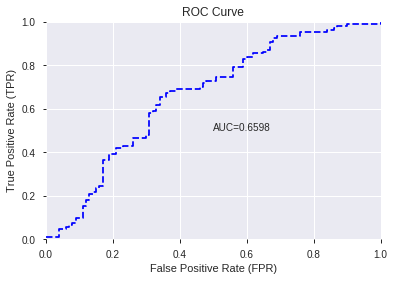

This function is available for GLM models only


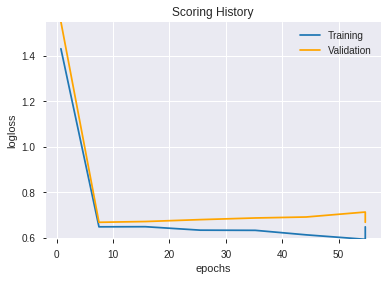

--2019-09-06 01:11:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.239.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.239.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190906_010259_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190906_010259_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_9435',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['SUB',
 'DIV',
 'TRANGE',
 'CDLDOJI',
 'BOP',
 'CDLBELTHOLD',
 'CDLSHORTLINE',
 'CDLHAMMER',
 'MFI_8',
 'CDLLONGLINE',
 'MFI_30',
 'CDLCLOSINGMARUBOZU',
 'SIN',
 'CDLHIKKAKEMOD',
 'MFI_24',
 'STOCH_slowk',
 'STDDEV_12',
 'CDLENGULFING',
 'aroondown_24',
 'days_in_month',
 'aroonup_8',
 'aroondown_30',
 'is_month_end',
 'CORREL_8',
 'aroondown_8',
 'CDLMARUBOZU',
 'CDLHIKKAKE',
 'aroondown_12',
 'week',
 'MFI_20',
 'STOCHF_fastk',
 'HT_PHASOR_inphase',
 'MACDEXT_hist',
 'day',
 'CDLRICKSHAWMAN',
 'dayofweek',
 'is_quarter_start',
 'weekday_name',
 'STOCHRSI_fastk',
 'CDLHARAMICROSS',
 'HT_PHASOR_quadrature',
 'HT_DCPERIOD',
 'weekday',
 'CDLTAKURI',
 'CDLDARKCLOUDCOVER',
 'BETA_12',
 'CDLHARAMI',
 'AROONOSC_12',
 'MFI_12',
 'HT_TRENDMODE']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190906_011117_model_1  0.635364  0.709037                  0.38  0.489983  0.240083

variable  relative_importance  scaled_importance  percentage
0                CDLDOJI             0.155317           1.000000    0.068317
1                    SUB             0.145309           0.935562    0.063915
2                 TRANGE             0.120759           0.777500    0.053117
3            CDLBELTHOLD             0.106305           0.684437    0.046759
4            STOCH_slowk             0.092129           0.593166    0.040523
5            CDLLONGLINE             0.090456           0.582392    0.039787
6                BETA_12             0.087978           0.566443    0.038698
7             CDLHIKKAKE             0.078684           0.506604    0.034610
8     CDLCLOSINGMARUBOZU             0.077678           0.500127    0.034167
9              STDDEV_12             0.076550           0.492861    0.033671
10          CDLENGULFING             0.073093           0.470606    0.032151
11                 MFI_8             0.071063           0.457535    0.031258
12             CDLHARAMI             0.069787           0.449318    0.030696
13                MFI_24             0.058213           0.374799    0.025605
14          CDLSHORTLINE             0.056532           0.363978    0.024866
15                MFI_20             0.053613           0.345183    0.023582
16              CORREL_8             0.050968           0.328158    0.022419
17           HT_DCPERIOD             0.050026           0.322092    0.022004
18                   SIN             0.045928           0.295705    0.020202
19         CDLHIKKAKEMOD             0.040131           0.258381    0.017652
20                   BOP             0.039555           0.254672    0.017398
21          is_month_end             0.038536           0.248113    0.016950
22          aroondown_12             0.036545           0.235294    0.016075
23         days_in_month             0.036280           0.233584    0.015958
24                MFI_30             0.036205           0.233102    0.015925
25           aroondown_8             0.035675           0.229692    0.015692
26             dayofweek             0.033829           0.217808    0.014880
27               weekday             0.033791           0.217562    0.014863
28  HT_PHASOR_quadrature             0.033615           0.216430    0.014786
29             CDLHAMMER             0.031553           0.203154    0.013879
30          MACDEXT_hist             0.030543           0.196652    0.013435
31      is_quarter_start             0.030454           0.196077    0.013395
32          aroondown_24             0.029254           0.188347    0.012867
33                   day             0.028670           0.184589    0.012611
34                   DIV             0.025109           0.161661    0.011044
35     CDLDARKCLOUDCOVER             0.023846           0.153529    0.010489
36          aroondown_30             0.022345           0.143869    0.009829
37          STOCHF_fastk             0.020539           0.132241    0.009034
38           CDLMARUBOZU             0.019641           0.126459    0.008639
39        STOCHRSI_fastk             0.016285           0.104851    0.007163
40        CDLHARAMICROSS             0.013192           0.084934    0.005802
41          HT_TRENDMODE             0.013121           0.084482    0.005772
42             CDLTAKURI             0.010692           0.068839    0.004703
43             aroonup_8             0.009995           0.064350    0.004396
44           AROONOSC_12             0.007456           0.048006    0.003280
45     HT_PHASOR_inphase             0.007264           0.046766    0.003195
46                MFI_12             0.003367           0.021680    0.001481
47        CDLRICKSHAWMAN             0.002990           0.019248    0.001315
48                  week             0.002087           0.013440    0.000918
49          weekday_name             0.000515           0.003318    0.000227

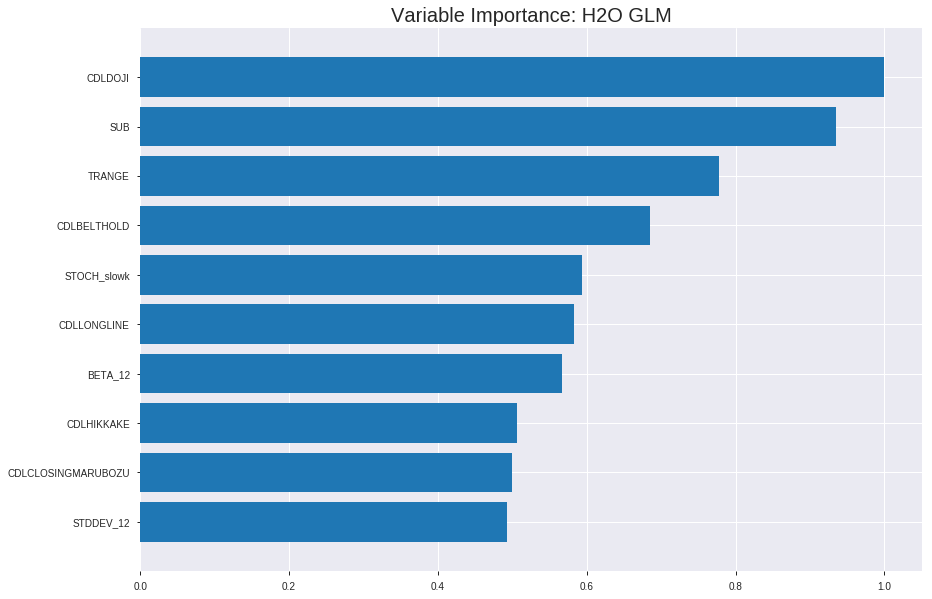

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_011117_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.22593221934429222
RMSE: 0.47532327877381747
LogLoss: 0.6429243336773035
Null degrees of freedom: 1465
Residual degrees of freedom: 1415
Null deviance: 2017.3407122714248
Residual deviance: 1885.0541463418538
AIC: 1987.0541463418538
AUC: 0.6720651808060352
pr_auc: 0.7026936662679615
Gini: 0.34413036161207033
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40861192089266524: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      133  526   0.7982   (526.0/659.0)
1      47   760   0.0582   (47.0/807.0)
Total  180  1286  0.3909   (573.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.408612     0.72623   311
max f2                       0.212687     0.860708  394
max f0point5                 0.554964     0.668249  182
max accuracy                 0.532548     0.639154  208
max precision                0.875488     1         0
max recall                   0.212687     1         394
max specificity              0.875488     1         0
max absolute_mcc             0.532548     0.262537  208
max min_per_class_accuracy   0.563604     0.625774  173
max mean_per_class_accuracy  0.554964     0.631171  182

Gains/Lift Table: Avg response rate: 55.05 %, avg score: 55.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102319                   0.7751             1.8166    1.8166             1                0.797624  1                           0.797624            0.0185874       0.0185874                  81.6605   81.6605
    2        0.0204638                   0.739424           1.6955    1.75605            0.933333         0.757616  0.966667                    0.77762             0.0173482       0.0359356                  69.5498   75.6051
    3        0.0300136                   0.731548           1.55709   1.69275            0.857143         0.735597  0.931818                    0.764249            0.0148699       0.0508055                  55.709    69.2745
    4        0.0402456                   0.718979           1.33218   1.60108            0.733333         0.724     0.881356                    0.754016            0.0136307       0.0644362                  33.2177   60.1075
    5        0.0504775                   0.713596           1.33218   1.54657            0.733333         0.715444  0.851351                    0.746197            0.0136307       0.0780669                  33.2177   54.6569
    6        0.100273                    0.679854           1.26913   1.4088             0.69863          0.693923  0.77551                     0.720238            0.063197        0.141264                   26.9135   40.8795
    7        0.150068                    0.659944           1.24425   1.3542             0.684932         0.670021  0.745455                    0.703575            0.0619579       0.203222                   24.425    35.4196
    8        0.200546                    0.643151           1.17834   1.30993            0.648649         0.651874  0.721088                    0.690562            0.0594796       0.262701                   17.8338   30.9933
    9        0.300136                    0.616412           1.23181   1.28401            0.678082         0.630057  0.706818                    0.670485            0.122677        0.385378                   23.1807   28.4009
    10       0.400409                    0.593854           1.18635   1.25955            0.653061         0.604999  0.693356                    0.654086            0.118959        0.504337                   18.6354   25.9554
    11       0.5                         0.566581           1.09494   1.22677            0.60274          0.580735  0.675307                    0.639476            0.109046        0.613383                   9.49398   22.6766
    12       0.600273                    0.5405             0.988628  1.18699            0.544218         0.553085  0.653409                    0.625045            0.0991326       0.712515                   -1.13716  18.6986
    13       0.699864                    0.508619           0.858532  1.14025            0.472603         0.524248  0.62768                     0.610701            0.0855019       0.798017                   -14.1468  14.0247
    14       0.800136                    0.462266           0.86505   1.10576            0.47619          0.48675   0.608696                    0.595168            0.086741        0.884758                   -13.495   10.5759
    15       0.899727                    0.381679           0.671895  1.05773            0.369863         0.427304  0.582259                    0.576587            0.0669145       0.951673                   -32.8105  5.7735
    16       1                           0.000904183        0.481956  1                  0.265306         0.316203  0.550477                    0.550477          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2451950695574772
RMSE: 0.4951717576331239
LogLoss: 0.6834109638301198
Null degrees of freedom: 418
Residual degrees of freedom: 368
Null deviance: 586.162658197427
Residual deviance: 572.6983876896403
AIC: 674.6983876896403
AUC: 0.5830940661744599
pr_auc: 0.5347082306864699
Gini: 0.16618813234891983
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4001401871665849: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      37   175  0.8255   (175.0/212.0)
1      12   195  0.058    (12.0/207.0)
Total  49   370  0.4463   (187.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.40014      0.67591   351
max f2                       0.260975     0.831994  396
max f0point5                 0.452119     0.579906  302
max accuracy                 0.515306     0.577566  206
max precision                0.773859     1         0
max recall                   0.260975     1         396
max specificity              0.773859     1         0
max absolute_mcc             0.40014      0.18134   351
max min_per_class_accuracy   0.521073     0.566038  197
max mean_per_class_accuracy  0.515306     0.577876  206

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 51.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119332                   0.753489           0.809662  0.809662           0.4              0.761959  0.4                         0.761959            0.00966184      0.00966184                 -19.0338  -19.0338
    2        0.0214797                   0.714263           1.01208   0.899624           0.5              0.725909  0.444444                    0.745937            0.00966184      0.0193237                  1.20773   -10.0376
    3        0.0310263                   0.697712           0.506039  0.778521           0.25             0.704628  0.384615                    0.733226            0.00483092      0.0241546                  -49.3961  -22.1479
    4        0.0405728                   0.683676           1.51812   0.952543           0.75             0.691867  0.470588                    0.723495            0.0144928       0.0386473                  51.8116   -4.74567
    5        0.0501193                   0.66793            1.01208   0.963883           0.5              0.676009  0.47619                     0.71445             0.00966184      0.0483092                  1.20773   -3.61169
    6        0.100239                    0.642214           1.06027   1.01208            0.52381          0.654404  0.5                         0.684427            0.0531401       0.101449                   6.02715   1.20773
    7        0.150358                    0.617397           1.34944   1.12453            0.666667         0.627963  0.555556                    0.665606            0.0676329       0.169082                   34.9436   12.453
    8        0.200477                    0.599824           1.15666   1.13256            0.571429         0.608411  0.559524                    0.651307            0.057971        0.227053                   15.666    13.2563
    9        0.300716                    0.571242           1.01208   1.0924             0.5              0.586488  0.539683                    0.629701            0.101449        0.328502                   1.20773   9.24009
    10       0.400955                    0.542354           1.15666   1.10847            0.571429         0.557729  0.547619                    0.611708            0.115942        0.444444                   15.666    10.8466
    11       0.501193                    0.521073           1.25305   1.13738            0.619048         0.531439  0.561905                    0.595654            0.125604        0.570048                   25.3048   13.7382
    12       0.599045                    0.498722           0.987392  1.11288            0.487805         0.510392  0.549801                    0.581727            0.0966184       0.666667                   -1.26075  11.2882
    13       0.699284                    0.474926           0.915689  1.08462            0.452381         0.486546  0.535836                    0.568083            0.0917874       0.758454                   -8.4311   8.46153
    14       0.799523                    0.43914            1.06027   1.08156            0.52381          0.45801   0.534328                    0.554283            0.10628         0.864734                   6.02715   8.15632
    15       0.899761                    0.388929           0.867495  1.05771            0.428571         0.415729  0.522546                    0.538847            0.0869565       0.951691                   -13.2505  5.77147
    16       1                           0.0294036          0.481942  1                  0.238095         0.328261  0.494033                    0.517738     


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-06 01:11:18  0.000 sec   2            7.7       51            1.36484           1.3931
    2019-09-06 01:11:18  0.060 sec   4            4.8       51            1.35934           1.39033
    2019-09-06 01:11:18  0.114 sec   6            3         51            1.352             1.38677
    2019-09-06 01:11:18  0.177 sec   8            1.8       51            1.34291           1.38262
    2019-09-06 01:11:18  0.227 sec   10           1.1       51            1.33254           1.3783
    2019-09-06 01:11:18  0.274 sec   12           0.71      51            1.32169           1.3744
    2019-09-06 01:11:18  0.336 sec   14           0.44      51            1.31115           1.37131
    2019-09-06 01:11:18  0.359 sec   16           0.27      51            1.30151           1.36913
    2019-09-06 01:11:18  0.380 sec   18           0.17      51            1.29305           1.36766
    2019-09-06 01:11:18  0.397 sec   20           0.11      51            1.28585           1.36682
    2019-09-06 01:11:18  0.412 sec   22           0.066     51            1.27993           1.36684
    2019-09-06 01:11:18  0.439 sec   24           0.041     51            1.27529           1.3681
    2019-09-06 01:11:18  0.458 sec   26           0.025     51            1.27188           1.37075
    2019-09-06 01:11:18  0.478 sec   28           0.016     51            1.26951           1.37461
    2019-09-06 01:11:18  0.498 sec   30           0.0098    51            1.26795           1.37918

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6333333333333333)

('F1', 0.7200000000000001)

('auc', 0.6353636363636364)

('logloss', 0.7090366354816197)

('mean_per_class_error', 0.3795454545454545)

('rmse', 0.4899826051013258)

('mse', 0.24008295330188179)

glm prediction progress: |████████████████████████████████████████████████| 100%


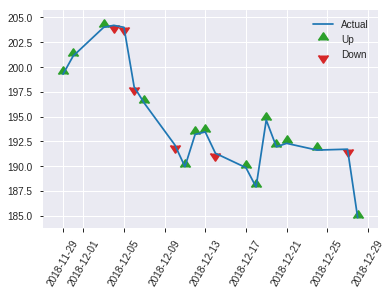


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24008295330188179
RMSE: 0.4899826051013258
LogLoss: 0.7090366354816197
Null degrees of freedom: 209
Residual degrees of freedom: 159
Null deviance: 291.24709670768067
Residual deviance: 297.79538690228026
AIC: 399.79538690228026
AUC: 0.6353636363636364
pr_auc: 0.5920601840133904
Gini: 0.2707272727272727
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3931512662456816: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      34   66   0.66     (66.0/100.0)
1      11   99   0.1      (11.0/110.0)
Total  45   165  0.3667   (77.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.393151     0.72      164
max f2                       4.77255e-05  0.846154  209
max f0point5                 0.393151     0.642857  164
max accuracy                 0.393151     0.633333  164
max precision                0.751676     1         0
max recall                   4.77255e-05  1         209
max specificity              0.751676     1         0
max absolute_mcc             0.393151     0.292119  164
max min_per_class_accuracy   0.491421     0.609091  105
max mean_per_class_accuracy  0.502976     0.620455  99

Gains/Lift Table: Avg response rate: 52.38 %, avg score: 48.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0142857                   0.720651           0.636364  0.636364           0.333333         0.741377  0.333333                    0.741377            0.00909091      0.00909091                 -36.3636  -36.3636
    2        0.0238095                   0.705701           0         0.381818           0                0.712646  0.2                         0.729885            0               0.00909091                 -100      -61.8182
    3        0.0333333                   0.686527           1.90909   0.818182           1                0.694291  0.428571                    0.719715            0.0181818       0.0272727                  90.9091   -18.1818
    4        0.0428571                   0.677083           0         0.636364           0                0.681484  0.333333                    0.711219            0               0.0272727                  -100      -36.3636
    5        0.052381                    0.666676           0.954545  0.694215           0.5              0.673723  0.363636                    0.704402            0.00909091      0.0363636                  -4.54545  -30.5785
    6        0.1                         0.630714           1.33636   1                  0.7              0.649314  0.52381                     0.67817             0.0636364       0.1                        33.6364   0
    7        0.152381                    0.604455           1.56198   1.19318            0.818182         0.613272  0.625                       0.655861            0.0818182       0.181818                   56.1983   19.3182
    8        0.2                         0.577835           1.52727   1.27273            0.8              0.588814  0.666667                    0.639898            0.0727273       0.254545                   52.7273   27.2727
    9        0.3                         0.540916           1.18182   1.24242            0.619048         0.560399  0.650794                    0.613398            0.118182        0.372727                   18.1818   24.2424
    10       0.4                         0.521249           1.18182   1.22727            0.619048         0.531738  0.642857                    0.592983            0.118182        0.490909                   18.1818   22.7273
    11       0.5                         0.492348           1.09091   1.2                0.571429         0.508471  0.628571                    0.576081            0.109091        0.6                        9.09091   20
    12       0.6                         0.464489           0.818182  1.13636            0.428571         0.479859  0.595238                    0.560044            0.0818182       0.681818                   -18.1818  13.6364
    13       0.7                         0.427772           1.09091   1.12987            0.571429         0.444752  0.591837                    0.543574            0.109091        0.790909                   9.09091   12.987
    14       0.8                         0.389413           1.09091   1.125              0.571429         0.406782  0.589286                    0.526475            0.109091        0.9                        9.09091   12.5
    15       0.9                         0.318331           0.454545  1.05051            0.238095         0.354971  0.550265                    0.507419            0.0454545       0.945455                   -54.5455  5.05051
    16       1                           4.77255e-05        0.545455  1                  0.285714         0.237124  0.52381                     0.480389            0.05454

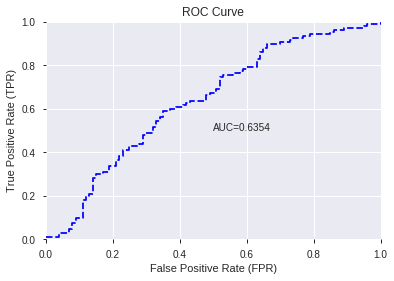

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


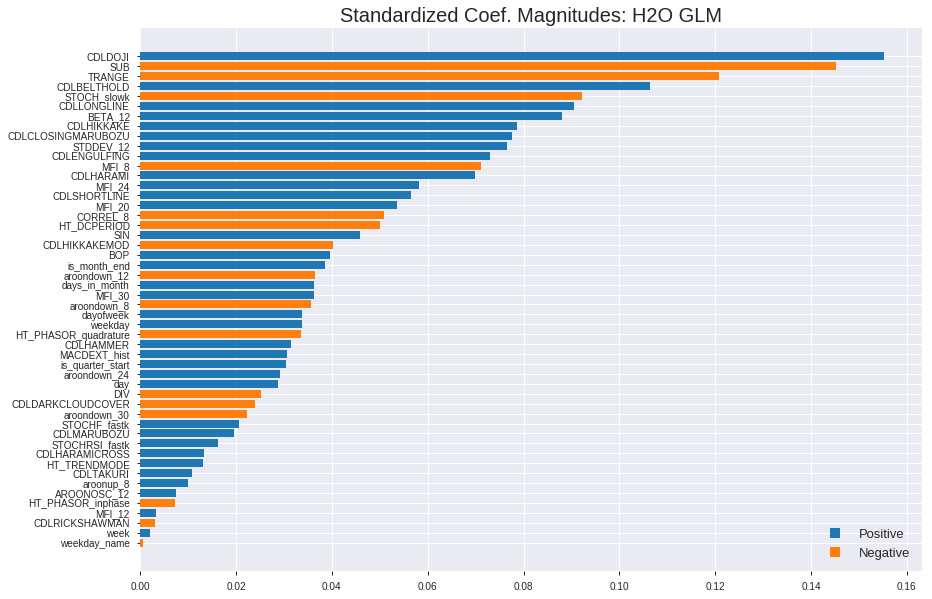

'log_likelihood'
--2019-09-06 01:11:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.1.156
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.1.156|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_011117_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_011117_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_9435',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['CDLDOJI',
 'SUB',
 'TRANGE',
 'CDLBELTHOLD',
 'STOCH_slowk',
 'CDLLONGLINE',
 'BETA_12',
 'CDLHIKKAKE',
 'CDLCLOSINGMARUBOZU',
 'STDDEV_12',
 'CDLENGULFING',
 'MFI_8',
 'CDLHARAMI',
 'MFI_24',
 'CDLSHORTLINE',
 'MFI_20',
 'CORREL_8',
 'HT_DCPERIOD',
 'SIN',
 'CDLHIKKAKEMOD',
 'BOP',
 'is_month_end',
 'aroondown_12',
 'days_in_month',
 'MFI_30',
 'aroondown_8',
 'dayofweek',
 'weekday',
 'HT_PHASOR_quadrature',
 'CDLHAMMER',
 'MACDEXT_hist',
 'is_quarter_start',
 'aroondown_24',
 'day',
 'DIV',
 'CDLDARKCLOUDCOVER',
 'aroondown_30',
 'STOCHF_fastk',
 'CDLMARUBOZU',
 'STOCHRSI_fastk',
 'CDLHARAMICROSS',
 'HT_TRENDMODE',
 'CDLTAKURI',
 'aroonup_8',
 'AROONOSC_12',
 'HT_PHASOR_inphase',
 'MFI_12',
 'CDLRICKSHAWMAN',
 'week',
 'weekday_name']

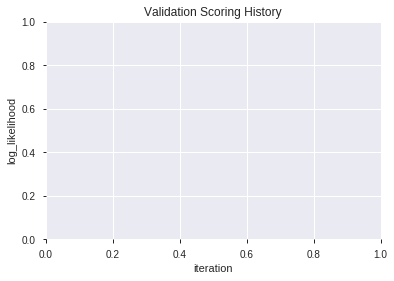

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190906_011136_model_4  0.695273  0.638665              0.336364  0.472864  0.223600
1               XGBoost_2_AutoML_20190906_011136  0.671273  0.660161              0.349545  0.483523  0.233795
2  XGBoost_grid_1_AutoML_20190906_011136_model_2  0.662182  0.656591              0.366364  0.481838  0.232168
3  XGBoost_grid_1_AutoML_20190906_011136_model_6  0.648091  0.656319              0.392273  0.481915  0.232242
4               XGBoost_3_AutoML_20190906_011136  0.646364  0.664050              0.417273  0.485374  0.235588
5  XGBoost_grid_1_AutoML_20190906_011136_model_1  0.638545  0.659579              0.438182  0.483875  0.234135
6               XGBoost_1_AutoML_20190906_011136  0.630091  0.667499              0.361364  0.487307  0.237468
7  XGBoost_grid_1_AutoML_20190906_011136_model_3  0.622000  0.673358              0.391364  0.490826  0.240910
8  XGBoost_grid_1_AutoML_20190906_011136_model_7  0.616182  0.674277              0.444091  0.490566  0.240655
9  XGBoost_grid_1_AutoML_20190906_011136_model_5  0.588273  0.692429              0.438182  0.499637  0.249637

variable  relative_importance  scaled_importance  percentage
0                    DIV           646.128601           1.000000    0.224966
1                    BOP           307.891754           0.476518    0.107200
2            HT_DCPERIOD           145.720245           0.225528    0.050736
3            STOCH_slowk           137.527924           0.212849    0.047884
4              STDDEV_12           137.482178           0.212778    0.047868
5           MACDEXT_hist           129.115005           0.199829    0.044955
6           STOCHF_fastk           122.441589           0.189500    0.042631
7                BETA_12           119.682457           0.185230    0.041670
8               CORREL_8            94.860542           0.146814    0.033028
9            CDLBELTHOLD            94.664856           0.146511    0.032960
10                 MFI_8            87.249237           0.135034    0.030378
11        STOCHRSI_fastk            79.172646           0.122534    0.027566
12                   SIN            77.642136           0.120165    0.027033
13                TRANGE            76.362579           0.118185    0.026588
14                MFI_24            69.996864           0.108333    0.024371
15                MFI_20            57.644081           0.089215    0.020070
16                MFI_30            56.645939           0.087670    0.019723
17                   day            53.414173           0.082668    0.018597
18     HT_PHASOR_inphase            51.312386           0.079415    0.017866
19             dayofweek            47.417549           0.073387    0.016510
20             aroonup_8            44.629787           0.069073    0.015539
21                   SUB            33.300194           0.051538    0.011594
22          aroondown_30            32.584496           0.050430    0.011345
23                MFI_12            26.783285           0.041452    0.009325
24          weekday_name            25.517792           0.039493    0.008885
25         days_in_month            21.517590           0.033302    0.007492
26           AROONOSC_12            21.232330           0.032861    0.007393
27           aroondown_8            16.632578           0.025742    0.005791
28  HT_PHASOR_quadrature            15.855083           0.024539    0.005520
29          CDLSHORTLINE            14.345448           0.022202    0.004995
30          aroondown_24            12.766762           0.019759    0.004445
31    CDLCLOSINGMARUBOZU             5.630456           0.008714    0.001960
32                  week             5.429207           0.008403    0.001890
33               CDLDOJI             3.521661           0.005450    0.001226

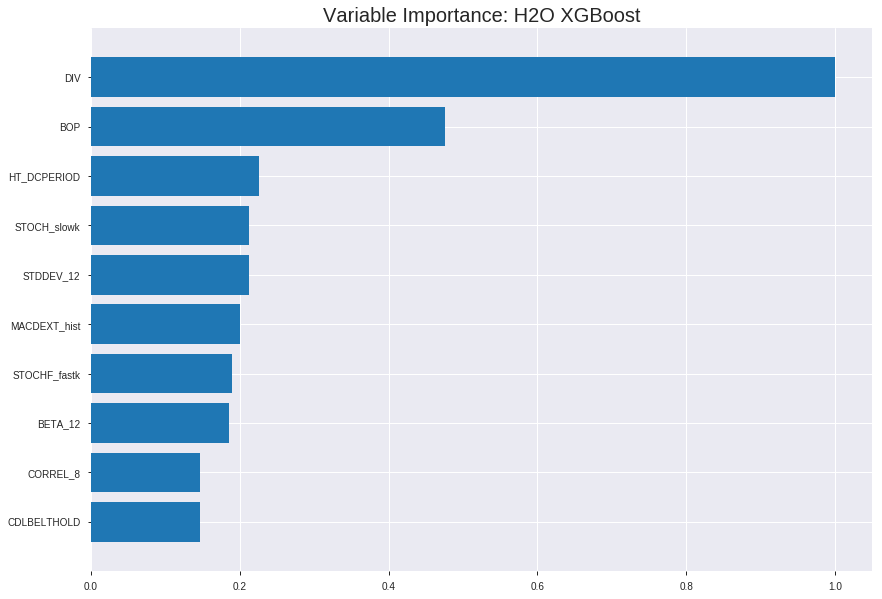

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190906_011136_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.21585815992879462
RMSE: 0.46460538086508923
LogLoss: 0.6213109069196455
Mean Per-Class Error: 0.3408895608042677
AUC: 0.716651341731022
pr_auc: 0.7698577391435999
Gini: 0.4333026834620439
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49371230602264404: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      210  449   0.6813   (449.0/659.0)
1      66   741   0.0818   (66.0/807.0)
Total  276  1190  0.3513   (515.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.493712     0.742113  255
max f2                       0.300061     0.865385  362
max f0point5                 0.585005     0.69542   169
max accuracy                 0.532037     0.654161  221
max precision                0.803234     1         0
max recall                   0.240764     1         392
max specificity              0.803234     1         0
max absolute_mcc             0.585005     0.32743   169
max min_per_class_accuracy   0.517331     0.639405  234
max mean_per_class_accuracy  0.585005     0.65911   169

Gains/Lift Table: Avg response rate: 55.05 %, avg score: 54.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102319                   0.779361           1.8166    1.8166             1                0.792254  1                           0.792254            0.0185874       0.0185874                  81.6605   81.6605
    2        0.0204638                   0.746312           1.8166    1.8166             1                0.75922   1                           0.775737            0.0185874       0.0371747                  81.6605   81.6605
    3        0.0300136                   0.738356           1.68685   1.77532            0.928571         0.741874  0.977273                    0.764963            0.016109        0.0532838                  68.6847   77.5318
    4        0.0402456                   0.727115           1.8166    1.78581            1                0.732675  0.983051                    0.756754            0.0185874       0.0718711                  81.6605   78.5815
    5        0.0504775                   0.718635           1.57439   1.74296            0.866667         0.721102  0.959459                    0.749527            0.016109        0.0879802                  57.4391   74.2959
    6        0.100273                    0.689177           1.71706   1.7301             0.945205         0.703415  0.952381                    0.726628            0.0855019       0.173482                   71.7065   73.01
    7        0.150068                    0.667404           1.39356   1.61843            0.767123         0.678779  0.890909                    0.710751            0.0693928       0.242875                   39.356    61.843
    8        0.200546                    0.64955            1.30108   1.53855            0.716216         0.657416  0.846939                    0.697326            0.0656753       0.30855                    30.1082   53.8553
    9        0.300136                    0.611436           1.18204   1.42025            0.650685         0.630644  0.781818                    0.6752              0.11772         0.42627                    18.2037   42.0255
    10       0.400409                    0.571884           1.09985   1.34002            0.605442         0.593124  0.737649                    0.654646            0.110285        0.536555                   9.98491   34.0017
    11       0.5                         0.525471           0.982957  1.2689             0.541096         0.549167  0.698499                    0.633637            0.0978934       0.634449                   -1.70427  26.8897
    12       0.800819                    0.5                0.914481  1.13576            0.503401         0.501872  0.625213                    0.584141            0.275093        0.909542                   -8.55187  13.5765
    13       0.899727                    0.383183           0.563774  1.07288            0.310345         0.448886  0.590599                    0.569272            0.0557621       0.965304                   -43.6226  7.28848
    14       1                           0.201429           0.34602   1                  0.190476         0.306331  0.550477                    0.542906            0.0346964       1                          -65.398   0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25
RMSE: 0.5
LogLoss: 0.6931471805599462
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    212  1        (212.0/212.0)
1      0    207  0        (0.0/207.0)
Total  0    419  0.506    (212.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.5          0.661342  0
max f2                       0.5          0.829992  0
max f0point5                 0.5          0.549655  0
max accuracy                 0.5          0.494033  0
max precision                0.5          0.494033  0
max recall                   0.5          1         0
max specificity              0.5          0         0
max absolute_mcc             0.5          0         0
max min_per_class_accuracy   0.5          0         0
max mean_per_class_accuracy  0.5          0.5       0

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 50.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0.5                1       1                  0.494033         0.5      0.494033                    0.5                 1               1                          0       0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:11:49  2.370 sec   0                  0.5              0.693147            0.5             0                  1                0.449523                         0.5                0.693147              0.5               0                    1                  0.505967
    2019-09-06 01:11:49  2.427 sec   5                  0.489127         0.671576            0.702502        0.739792           1.8166           0.351296                         0.499303           0.691749              0.518435          0.538643             1.21449            0.491647
    2019-09-06 01:11:49  2.477 sec   10                 0.490832         0.674777            0.603267        0.676702           1.8166           0.40382                          0.5                0.693147              0.5               0                    1                  0.505967
    2019-09-06 01:11:49  2.518 sec   15                 0.489099         0.671259            0.61571         0.686882           1.6955           0.420873                         0.5                0.693147              0.5               0                    1                  0.505967
    2019-09-06 01:11:49  2.565 sec   20                 0.486334         0.665466            0.611779        0.686701           1.8166           0.400409                         0.5                0.693147              0.5               0                    1                  0.505967
    2019-09-06 01:11:49  2.608 sec   25                 0.489306         0.671457            0.596187        0.679605           1.45328          0.407231                         0.5                0.693147              0.5               0                    1                  0.505967
    2019-09-06 01:11:50  2.658 sec   30                 0.478489         0.649858            0.664249        0.714448           1.8166           0.379263                         0.5                0.693147              0.5               0                    1                  0.505967
    2019-09-06 01:11:50  2.710 sec   35                 0.482103         0.656377            0.623689        0.69859            1.8166           0.393588                         0.5                0.693147              0.5               0                    1                  0.505967
    2019-09-06 01:11:50  2.757 sec   40                 0.474357         0.640865            0.669903        0.727608           1.8166           0.36221                          0.5                0.693147              0.5               0                    1                  0.505967
    2019-09-06 01:11:50  2.814 sec   45                 0.47897          0.650266            0.650874        0.708251           1.8166           0.379263                         0.5                0.693147              0.5               0                    1                  0.505967
    2019-09-06 01:11:50  2.867 sec   50                 0.464605         0.621311            0.716651        0.769858           1.8166           0.351296                         0.5                0.693147              0.5               0                    1                  0.505967

Variable Importances: 


variable            relative_importance    scaled_importance     percentage
------------------  ---------------------  --------------------  ---------------------
DIV                 646.1286010742188      1.0                   0.2249657861772785
BOP                 307.8917541503906      0.47651776076543634   0.10720019267803271
HT_DCPERIOD         145.72024536132812     0.22552823868044453   0.05073613751992311
STOCH_slowk         137.52792358398438     0.21284915008457733   0.04788377638594248
STDDEV_12           137.482177734375       0.21277835017023625   0.04786784882755146
---                 ---                    ---                   ---
CDLSHORTLINE        14.345447540283203     0.022202155292976092  0.0049947253203143915
aroondown_24        12.766761779785156     0.01975885568068001   0.004445066502167565
CDLCLOSINGMARUBOZU  5.63045597076416       0.008714141366599879  0.001960383663397086
week                5.4292073249816895     0.008402672960081601  0.0018903139284553172
CDLDOJI             3.521660804748535      0.005450402286624692  0.0012261540353929602


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6761904761904762)

('F1', 0.7499999999999999)

('auc', 0.6952727272727273)

('logloss', 0.6386649808400947)

('mean_per_class_error', 0.3340909090909091)

('rmse', 0.47286365043853257)

('mse', 0.2236000319060547)

xgboost prediction progress: |████████████████████████████████████████████| 100%


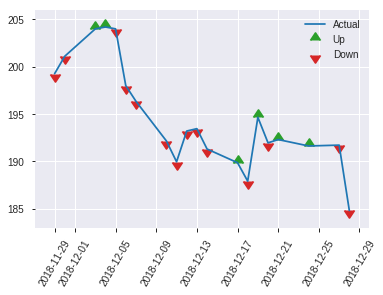


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2236000319060547
RMSE: 0.47286365043853257
LogLoss: 0.6386649808400947
Mean Per-Class Error: 0.3340909090909091
AUC: 0.6952727272727273
pr_auc: 0.6445733793924091
Gini: 0.39054545454545453
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39171919226646423: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      40   60   0.6      (60.0/100.0)
1      8    102  0.0727   (8.0/110.0)
Total  48   162  0.3238   (68.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.391719     0.75      161
max f2                       0.331134     0.861244  186
max f0point5                 0.523531     0.683673  94
max accuracy                 0.426122     0.67619   151
max precision                0.771311     1         0
max recall                   0.267751     1         206
max specificity              0.771311     1         0
max absolute_mcc             0.391719     0.389249  161
max min_per_class_accuracy   0.512121     0.645455  105
max mean_per_class_accuracy  0.426122     0.665909  151

Gains/Lift Table: Avg response rate: 52.38 %, avg score: 49.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0142857                   0.718378           1.27273   1.27273            0.666667         0.739043  0.666667                    0.739043            0.0181818       0.0181818                  27.2727   27.2727
    2        0.0238095                   0.71053            0.954545  1.14545            0.5              0.714542  0.6                         0.729243            0.00909091      0.0272727                  -4.54545  14.5455
    3        0.0333333                   0.701746           0.954545  1.09091            0.5              0.703581  0.571429                    0.721911            0.00909091      0.0363636                  -4.54545  9.09091
    4        0.0428571                   0.689746           0.954545  1.06061            0.5              0.695221  0.555556                    0.71598             0.00909091      0.0454545                  -4.54545  6.06061
    5        0.052381                    0.681308           0.954545  1.04132            0.5              0.687741  0.545455                    0.710845            0.00909091      0.0545455                  -4.54545  4.13223
    6        0.1                         0.62964            1.52727   1.27273            0.8              0.649335  0.666667                    0.681555            0.0727273       0.127273                   52.7273   27.2727
    7        0.152381                    0.610698           1.04132   1.19318            0.545455         0.619959  0.625                       0.660381            0.0545455       0.181818                   4.13223   19.3182
    8        0.2                         0.589425           1.14545   1.18182            0.6              0.600328  0.619048                    0.646083            0.0545455       0.236364                   14.5455   18.1818
    9        0.3                         0.561938           1.54545   1.30303            0.809524         0.573183  0.68254                     0.621783            0.154545        0.390909                   54.5455   30.303
    10       0.4                         0.533258           1.45455   1.34091            0.761905         0.5498    0.702381                    0.603787            0.145455        0.536364                   45.4545   34.0909
    11       0.5                         0.512306           1         1.27273            0.52381          0.523044  0.666667                    0.587638            0.1             0.636364                   0         27.2727
    12       0.6                         0.477647           1         1.22727            0.52381          0.497841  0.642857                    0.572672            0.1             0.736364                   0         22.7273
    13       0.7                         0.432544           1.18182   1.22078            0.619048         0.457374  0.639456                    0.556201            0.118182        0.854545                   18.1818   22.0779
    14       0.8                         0.371547           0.727273  1.15909            0.380952         0.403211  0.607143                    0.537077            0.0727273       0.927273                   -27.2727  15.9091
    15       0.9                         0.320694           0.545455  1.09091            0.285714         0.349518  0.571429                    0.516237            0.0545455       0.981818                   -45.4545  9.09091
    16       1                           0.239898           0.181818  1                  0.0952381        0.288578  0.52381                     0.493471          

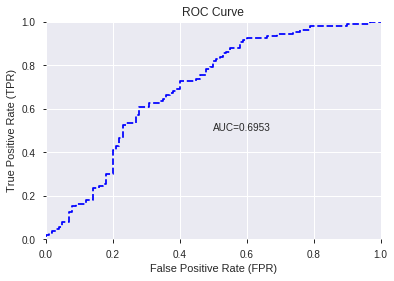

This function is available for GLM models only


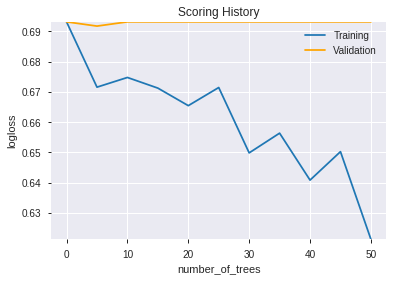

--2019-09-06 01:12:01--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.177.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.177.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190906_011136_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190906_011136_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_9435',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['DIV',
 'BOP',
 'HT_DCPERIOD',
 'STOCH_slowk',
 'STDDEV_12',
 'MACDEXT_hist',
 'STOCHF_fastk',
 'BETA_12',
 'CORREL_8',
 'CDLBELTHOLD',
 'MFI_8',
 'STOCHRSI_fastk',
 'SIN',
 'TRANGE',
 'MFI_24',
 'MFI_20',
 'MFI_30',
 'day',
 'HT_PHASOR_inphase',
 'dayofweek',
 'aroonup_8',
 'SUB',
 'aroondown_30',
 'MFI_12',
 'weekday_name',
 'days_in_month',
 'AROONOSC_12',
 'aroondown_8',
 'HT_PHASOR_quadrature',
 'CDLSHORTLINE',
 'aroondown_24',
 'CDLCLOSINGMARUBOZU',
 'week',
 'CDLDOJI']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190906_011215_model_1  0.499091  18.06443                   0.5  0.723747  0.52381

variable  relative_importance  scaled_importance  percentage
0                      CDLDOJI             0.009019           1.000000    0.018397
1                  CDLBELTHOLD             0.008873           0.983802    0.018099
2                  CDLLONGLINE             0.008459           0.937863    0.017254
3           CDLCLOSINGMARUBOZU             0.008152           0.903818    0.016627
4                  CDLMARUBOZU             0.007558           0.837965    0.015416
...                        ...                  ...                ...         ...
1038  BBANDS_middleband_24_3_2             0.000000           0.000000    0.000000
1039  BBANDS_middleband_24_3_3             0.000000           0.000000    0.000000
1040  BBANDS_middleband_24_3_4             0.000000           0.000000    0.000000
1041  BBANDS_middleband_24_3_5             0.000000           0.000000    0.000000
1042   BBANDS_lowerband_24_5_2             0.000000           0.000000    0.000000

[1043 rows x 4 columns]

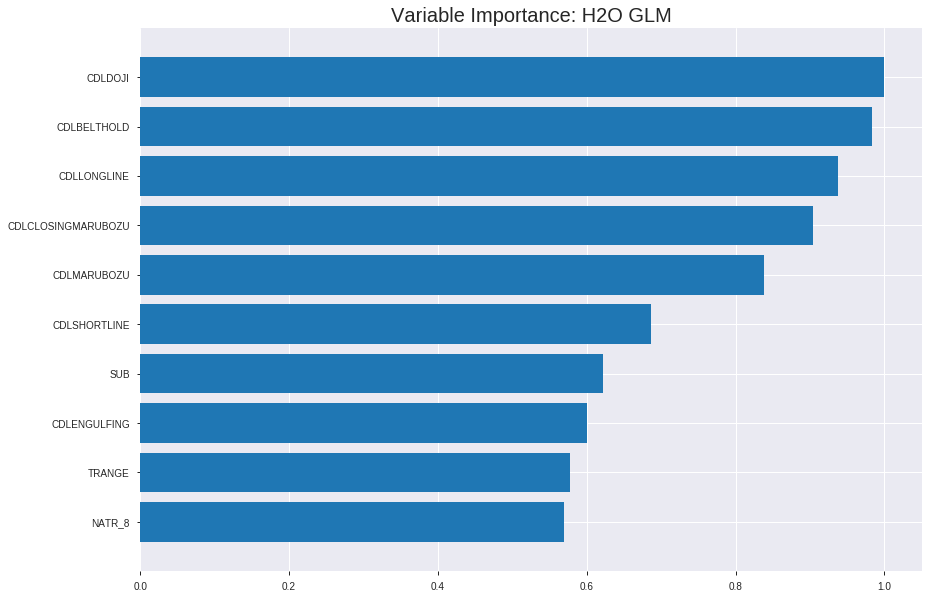

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_011215_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24226941513576866
RMSE: 0.4922087109507192
LogLoss: 0.6775642358573639
Null degrees of freedom: 1465
Residual degrees of freedom: 444
Null deviance: 2017.3407122714248
Residual deviance: 1986.618339533791
AIC: 4030.618339533791
AUC: 0.6583733379966267
pr_auc: 0.6973621530407631
Gini: 0.31674667599325335
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.521667726915639: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      87   572   0.868    (572.0/659.0)
1      31   776   0.0384   (31.0/807.0)
Total  118  1348  0.4113   (603.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.521668     0.720186  314
max f2                       0.450735     0.861076  391
max f0point5                 0.557858     0.656799  143
max accuracy                 0.547836     0.616644  203
max precision                0.609867     1         0
max recall                   0.450735     1         391
max specificity              0.609867     1         0
max absolute_mcc             0.558273     0.25381   140
max min_per_class_accuracy   0.554267     0.607187  164
max mean_per_class_accuracy  0.558273     0.625309  140

Gains/Lift Table: Avg response rate: 55.05 %, avg score: 55.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102319                   0.588339           1.8166    1.8166             1                0.594011  1                           0.594011            0.0185874       0.0185874                  81.6605   81.6605
    2        0.0204638                   0.584218           1.45328   1.63494            0.8              0.586233  0.9                         0.590122            0.0148699       0.0334572                  45.3284   63.4944
    3        0.0300136                   0.580524           1.29757   1.5276             0.714286         0.582463  0.840909                    0.587685            0.0123916       0.0458488                  29.7575   52.7599
    4        0.0402456                   0.578118           1.45328   1.50871            0.8              0.579238  0.830508                    0.585537            0.0148699       0.0607187                  45.3284   50.8706
    5        0.0504775                   0.577004           1.21107   1.44837            0.666667         0.577495  0.797297                    0.583907            0.0123916       0.0731103                  21.107    44.8374
    6        0.100273                    0.572246           1.36867   1.4088             0.753425         0.574389  0.77551                     0.579181            0.0681537       0.141264                   36.8675   40.8795
    7        0.150068                    0.568931           1.3189    1.37897            0.726027         0.57044   0.759091                    0.57628             0.0656753       0.206939                   31.8905   37.8968
    8        0.200546                    0.566993           1.47292   1.40262            0.810811         0.567901  0.772109                    0.574171            0.0743494       0.281289                   47.2923   40.2617
    9        0.300136                    0.562286           1.13227   1.31291            0.623288         0.564604  0.722727                    0.570997            0.112763        0.394052                   13.2267   31.291
    10       0.400409                    0.558339           1.16164   1.27503            0.639456         0.560387  0.701874                    0.56834             0.116481        0.510533                   16.1638   27.5027
    11       0.5                         0.55454            0.883417  1.19703            0.486301         0.556564  0.658936                    0.565994            0.0879802       0.598513                   -11.6583  19.7026
    12       0.600273                    0.55037            0.939197  1.15396            0.517007         0.552488  0.635227                    0.563738            0.094176        0.692689                   -6.0803   15.3957
    13       0.699864                    0.544395           0.920745  1.12077            0.506849         0.547506  0.616959                    0.561428            0.0916976       0.784387                   -7.92551  12.0771
    14       0.800136                    0.537733           0.753829  1.07479            0.414966         0.541155  0.591645                    0.558888            0.0755886       0.859975                   -24.6171  7.47857
    15       0.899727                    0.525073           0.833647  1.04809            0.458904         0.531674  0.576952                    0.555875            0.0830235       0.942999                   -16.6353  4.80941
    16       1                           0.350554           0.568461  1                  0.312925         0.502042  0.550477                    0.550477          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.3460629163460978
RMSE: 0.5882711248617408
LogLoss: 5.781332584947397
Null degrees of freedom: 418
Residual degrees of freedom: -603
Null deviance: 586.162658197427
Residual deviance: 49994.291306755666
AIC: 52038.291306755666
AUC: 0.5588597210828548
pr_auc: 0.5511317754872072
Gini: 0.11771944216570951
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.743263092957243e-48: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    212  1        (212.0/212.0)
1      0    207  0        (0.0/207.0)
Total  0    419  0.506    (212.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.74326e-48  0.661342  316
max f2                       1.74326e-48  0.829992  316
max f0point5                 1.16867e-22  0.565706  303
max accuracy                 0.555038     0.556086  80
max precision                0.587335     1         0
max recall                   1.74326e-48  1         316
max specificity              0.587335     1         0
max absolute_mcc             0.563284     0.159908  38
max min_per_class_accuracy   0.446029     0.523585  209
max mean_per_class_accuracy  0.551729     0.552832  94

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 29.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119332                   0.577297           1.21449   1.21449            0.6              0.580429     0.6                         0.580429            0.0144928       0.0144928                  21.4493   21.4493
    2        0.0214797                   0.57504            1.01208   1.12453            0.5              0.576106     0.555556                    0.578508            0.00966184      0.0241546                  1.20773   12.453
    3        0.0310263                   0.57393            1.51812   1.24563            0.75             0.57414      0.615385                    0.577164            0.0144928       0.0386473                  51.8116   24.5634
    4        0.0405728                   0.569548           1.01208   1.19068            0.5              0.57283      0.588235                    0.576144            0.00966184      0.0483092                  1.20773   19.0679
    5        0.0501193                   0.567642           1.01208   1.15666            0.5              0.568247     0.571429                    0.57464             0.00966184      0.057971                   1.20773   15.666
    6        0.100239                    0.562963           1.6386    1.39763            0.809524         0.565048     0.690476                    0.569844            0.0821256       0.140097                   63.8601   39.7631
    7        0.150358                    0.559254           0.963883  1.25305            0.47619          0.560882     0.619048                    0.566856            0.0483092       0.188406                   -3.61169  25.3048
    8        0.200477                    0.554437           1.25305   1.25305            0.619048         0.556379     0.619048                    0.564237            0.0628019       0.251208                   25.3048   25.3048
    9        0.300716                    0.545035           0.915689  1.1406             0.452381         0.549896     0.563492                    0.559457            0.0917874       0.342995                   -8.4311   14.0595
    10       0.400955                    0.523502           0.963883  1.09642            0.47619          0.536476     0.541667                    0.553711            0.0966184       0.439614                   -3.61169  9.64171
    11       0.501193                    0.446029           0.867495  1.05063            0.428571         0.499336     0.519048                    0.542836            0.0869565       0.52657                    -13.2505  5.06326
    12       0.599045                    0.00680146         1.03676   1.04837            0.512195         0.200816     0.517928                    0.486968            0.101449        0.628019                   3.67621   4.83669
    13       0.699284                    4.71487e-15        1.10847   1.05698            0.547619         0.000910852  0.522184                    0.417295            0.111111        0.73913                    10.8466   5.69817
    14       0.799523                    2.92079e-126       0.963883  1.04531            0.47619          2.89835e-18  0.516418                    0.364977            0.0966184       0.835749                   -3.61169  4.53097
    15       1                           0                  0.819301  1                  0.404762         9.3833e-140  0.494033                    0.291807            0.164251        1                          -18.0699  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-06 01:12:19  0.000 sec   2            7.7       1022          1.35513           119.318
    2019-09-06 01:12:20  1.700 sec   4            5.6       1036          1.34942           127.43
    2019-09-06 01:12:22  3.407 sec   6            4.1       1038          1.34252           135.792
    2019-09-06 01:12:24  5.115 sec   8            3         1043          1.33438           144.095
    2019-09-06 01:12:25  6.839 sec   10           2.2       1044          1.32499           150.87

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5238095238095238)

('F1', 0.6875000000000001)

('auc', 0.4990909090909091)

('logloss', 18.06443022782409)

('mean_per_class_error', 0.4954545454545455)

('rmse', 0.7237468644557439)

('mse', 0.5238095238095208)

glm prediction progress: |████████████████████████████████████████████████| 100%


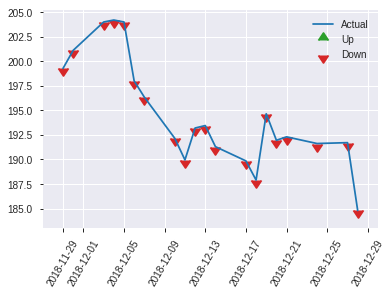


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5238095238095208
RMSE: 0.7237468644557439
LogLoss: 18.06443022782409
Null degrees of freedom: 209
Residual degrees of freedom: -812
Null deviance: 291.24709670768067
Residual deviance: 151339.29801232356
AIC: 153383.29801232356
AUC: 0.4990909090909091
pr_auc: 0.5063852813852814
Gini: -0.0018181818181818299
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.6230823903416655e-59: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    100  1        (100.0/100.0)
1      0    110  0        (0.0/110.0)
Total  0    210  0.4762   (100.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       2.62308e-59  0.6875     4
max f2                       2.62308e-59  0.846154   4
max f0point5                 2.62308e-59  0.578947   4
max accuracy                 2.62308e-59  0.52381    4
max precision                3.09495e-13  1          0
max recall                   2.62308e-59  1          4
max specificity              3.09495e-13  1          0
max absolute_mcc             3.09495e-13  0.0659524  0
max min_per_class_accuracy   1.51113e-44  0.0181818  3
max mean_per_class_accuracy  3.09495e-13  0.504545   0

Gains/Lift Table: Avg response rate: 52.38 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0142857                   1.92257e-21        0.636364  0.636364           0.333333         1.03165e-13   0.333333                    1.03165e-13         0.00909091      0.00909091                 -36.3636  -36.3636
    2        0.0238095                   4.36607e-57        1.90909   1.14545            1                7.55564e-45   0.6                         6.18991e-14         0.0181818       0.0272727                  90.9091   14.5455
    3        0.0333333                   1.54921e-207       0.954545  1.09091            0.5              5.06574e-59   0.571429                    4.42136e-14         0.00909091      0.0363636                  -4.54545  9.09091
    4        1                           0                  0.996865  1                  0.522167         3.88262e-243  0.52381                     1.47379e-15         0.963636        1                          -0.31348  0

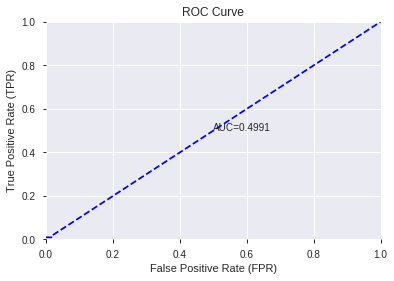

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


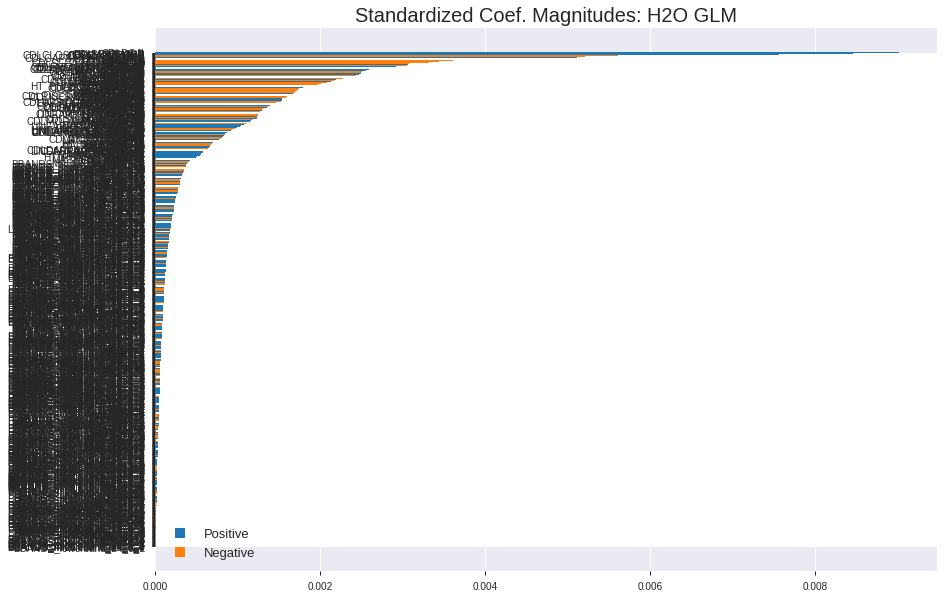

'log_likelihood'
--2019-09-06 01:12:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_011215_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_011215_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_9435',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

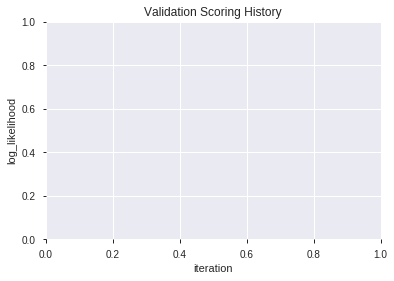

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190906_011259_model_3  0.714273  0.639987              0.304091  0.473499  0.224201
1  XGBoost_grid_1_AutoML_20190906_011259_model_4  0.701727  0.640413              0.317727  0.473393  0.224101
2               XGBoost_3_AutoML_20190906_011259  0.689727  0.642064              0.323182  0.475127  0.225745
3  XGBoost_grid_1_AutoML_20190906_011259_model_5  0.689182  0.638862              0.452273  0.473040  0.223766
4               XGBoost_2_AutoML_20190906_011259  0.689000  0.647452              0.325909  0.477031  0.227559
5  XGBoost_grid_1_AutoML_20190906_011259_model_6  0.688182  0.644383              0.355000  0.475579  0.226175
6  XGBoost_grid_1_AutoML_20190906_011259_model_2  0.674182  0.654474              0.374091  0.480652  0.231026
7  XGBoost_grid_1_AutoML_20190906_011259_model_1  0.656364  0.654038              0.380909  0.481020  0.231380
8               XGBoost_1_AutoML_20190906_011259  0.642818  0.661224              0.406364  0.484160  0.234411
9  XGBoost_grid_1_AutoML_20190906_011259_model_7  0.639091  0.669603              0.382727  0.489034  0.239154

variable  relative_importance  scaled_importance  percentage
0                        DIV           561.809937           1.000000    0.088226
1                        BOP           210.481140           0.374648    0.033054
2                STOCH_slowk           105.683128           0.188112    0.016596
3             STOCHRSI_fastd           101.181702           0.180100    0.015890
4                    BETA_12            99.316826           0.176780    0.015597
..                       ...                  ...                ...         ...
250  BBANDS_lowerband_14_2_2             0.787428           0.001402    0.000124
251                  quarter             0.719029           0.001280    0.000113
252               PLUS_DM_30             0.533312           0.000949    0.000084
253                 AdjClose             0.231098           0.000411    0.000036
254  BBANDS_upperband_14_0_3             0.066569           0.000118    0.000010

[255 rows x 4 columns]

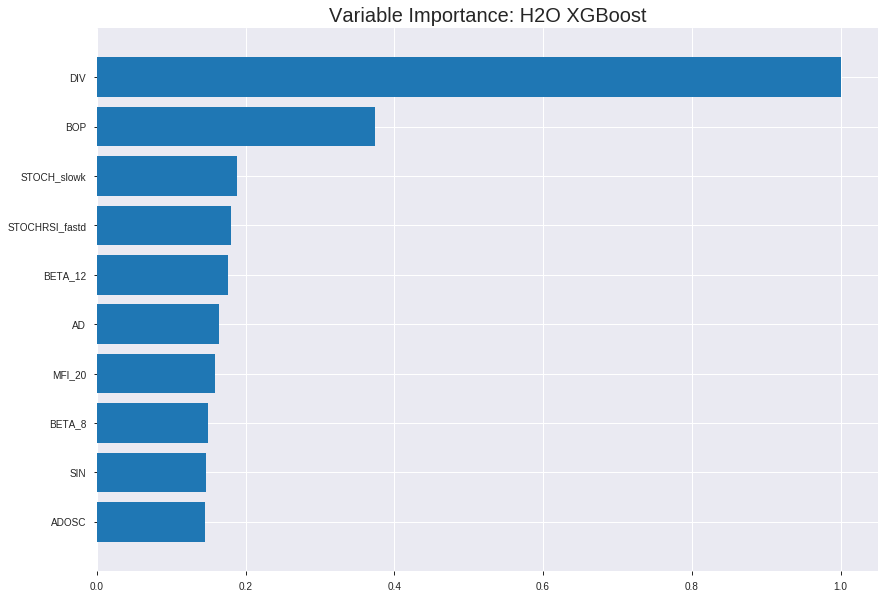

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190906_011259_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.20748987622381945
RMSE: 0.4555105665336639
LogLoss: 0.6021215194389948
Mean Per-Class Error: 0.35403421879495234
AUC: 0.7312053296929559
pr_auc: 0.8108369162541139
Gini: 0.46241065938591186
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4471055269241333: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      181  478   0.7253   (478.0/659.0)
1      15   792   0.0186   (15.0/807.0)
Total  196  1270  0.3363   (493.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.447106     0.762638  264
max f2                       0.386706     0.883257  300
max f0point5                 0.569121     0.675477  193
max accuracy                 0.447106     0.663711  264
max precision                0.860973     1         0
max recall                   0.364015     1         314
max specificity              0.860973     1         0
max absolute_mcc             0.447106     0.374292  264
max min_per_class_accuracy   0.501528     0.379182  237
max mean_per_class_accuracy  0.569121     0.645966  193

Gains/Lift Table: Avg response rate: 55.05 %, avg score: 51.96 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102319                   0.806191           1.8166     1.8166             1                0.830995  1                           0.830995            0.0185874       0.0185874                  81.6605   81.6605
    2        0.0204638                   0.793798           1.8166     1.8166             1                0.799075  1                           0.815035            0.0185874       0.0371747                  81.6605   81.6605
    3        0.0300136                   0.769962           1.8166     1.8166             1                0.784125  1                           0.8052              0.0173482       0.0545229                  81.6605   81.6605
    4        0.0402456                   0.761323           1.8166     1.8166             1                0.765916  1                           0.795213            0.0185874       0.0731103                  81.6605   81.6605
    5        0.0504775                   0.749477           1.8166     1.8166             1                0.755452  1                           0.787153            0.0185874       0.0916976                  81.6605   81.6605
    6        0.100273                    0.707703           1.79172    1.80425            0.986301         0.728396  0.993197                    0.757974            0.0892193       0.180917                   79.172    80.4247
    7        0.150068                    0.646967           1.61752    1.74229            0.890411         0.679195  0.959091                    0.731834            0.0805452       0.261462                   61.7525   74.2289
    8        0.200546                    0.586314           1.32563    1.63742            0.72973          0.617778  0.901361                    0.703126            0.0669145       0.328377                   32.563    63.7416
    9        0.843111                    0.5                0.977727   1.13464            0.538217         0.503485  0.624595                    0.550972            0.628253        0.956629                   -2.22733  13.4643
    10       0.899727                    0.394101           0.634717   1.10318            0.349398         0.443528  0.607278                    0.544211            0.0359356       0.992565                   -36.5283  10.3185
    11       1                           0.133293           0.0741471  1                  0.0408163        0.299067  0.550477                    0.51963             0.00743494      1                          -92.5853  0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2506926666809418
RMSE: 0.5006921875573273
LogLoss: 0.6945223795448888
Mean Per-Class Error: 0.48735302160240634
AUC: 0.5000911493938566
pr_auc: 0.5121895340084589
Gini: 0.00018229878771314212
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3411661684513092: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    209  0.9858   (209.0/212.0)
1      0    207  0        (0.0/207.0)
Total  3    416  0.4988   (209.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.341166     0.664526   61
max f2                       0.341166     0.831994   61
max f0point5                 0.341166     0.55318    61
max accuracy                 0.547458     0.5179     22
max precision                0.76528      1          0
max recall                   0.341166     1          61
max specificity              0.76528      1          0
max absolute_mcc             0.341166     0.0839134  61
max min_per_class_accuracy   0.508977     0.0772947  29
max mean_per_class_accuracy  0.531718     0.512647   24

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 50.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0119332                   0.663663           1.21449   1.21449            0.6              0.710528  0.6                         0.710528            0.0144928       0.0144928                  21.4493  21.4493
    2        0.0214797                   0.655554           1.01208   1.12453            0.5              0.659883  0.555556                    0.688019            0.00966184      0.0241546                  1.20773  12.453
    3        0.0310263                   0.627778           1.01208   1.08993            0.5              0.640939  0.538462                    0.673533            0.00966184      0.0338164                  1.20773  8.99294
    4        0.0405728                   0.61132            1.01208   1.07161            0.5              0.620293  0.529412                    0.661006            0.00966184      0.0434783                  1.20773  7.16113
    5        0.0501193                   0.573374           1.51812   1.15666            0.75             0.594412  0.571429                    0.648321            0.0144928       0.057971                   51.8116  15.666
    6        0.918854                    0.5                0.984273  0.993676           0.486264         0.500759  0.490909                    0.508808            0.855072        0.913043                   -1.5727  -0.632411
    7        1                           0.223782           1.07161   1                  0.529412         0.418125  0.494033                    0.50145             0.0869565       1                          7.16113  0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:13:17  5.348 sec   0                  0.5              0.693147            0.5             0                  1                0.449523                         0.5                0.693147              0.5               0                    1                  0.505967
    2019-09-06 01:13:18  5.958 sec   5                  0.478173         0.650213            0.804594        0.820515           1.70307          0.276944                         0.500684           0.694525              0.498553          0.509861             0.809662           0.501193
    2019-09-06 01:13:18  6.321 sec   10                 0.476234         0.646077            0.738405        0.792852           1.8166           0.326057                         0.500127           0.693386              0.500365          0.511293             1.21449            0.498807
    2019-09-06 01:13:18  6.668 sec   15                 0.476678         0.646523            0.691921        0.766242           1.8166           0.355389                         0.495509           0.684205              0.581203          0.545198             1.21449            0.477327
    2019-09-06 01:13:19  6.961 sec   20                 0.473504         0.639906            0.700727        0.777495           1.8166           0.358117                         0.500441           0.694066              0.500547          0.508905             0.809662           0.501193
    2019-09-06 01:13:19  7.271 sec   25                 0.457184         0.60794             0.768434        0.820939           1.8166           0.311733                         0.500172           0.693509              0.504854          0.516777             0.809662           0.498807
    2019-09-06 01:13:19  7.597 sec   30                 0.450512         0.594455            0.77843         0.832528           1.8166           0.297408                         0.500448           0.694053              0.500273          0.511015             0.809662           0.498807
    2019-09-06 01:13:20  7.894 sec   35                 0.447938         0.589236            0.786439        0.838683           1.8166           0.300819                         0.500867           0.694901              0.499954          0.50958              0.809662           0.498807
    2019-09-06 01:13:20  8.206 sec   40                 0.444761         0.582746            0.795451        0.846332           1.8166           0.291269                         0.500635           0.694427              0.504261          0.518866             1.21449            0.498807
    2019-09-06 01:13:20  8.516 sec   45                 0.438213         0.569497            0.808171        0.856059           1.8166           0.276262                         0.500321           0.693779              0.51668           0.54154              1.21449            0.498807
    2019-09-06 01:13:21  8.814 sec   50                 0.455511         0.602122            0.731205        0.810837           1.8166           0.336289                         0.500692           0.694522              0.500091          0.51219              1.21449            0.498807

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
DIV                      561.8099365234375      1.0                     0.08822636421858977
BOP                      210.48114013671875     0.37464830444119057     0.03305385776150558
STOCH_slowk              105.6831283569336      0.18811188889060299     0.01659642802310923
STOCHRSI_fastd           101.18170166015625     0.18009952313460936     0.01588952612366838
BETA_12                  99.31682586669922      0.1767801162102727      0.015596666919372145
---                      ---                    ---                     ---
BBANDS_lowerband_14_2_2  0.7874279022216797     0.0014015912696283006   0.0001236573018398221
quarter                  0.719029426574707      0.001279844623297635    0.00011291603787826095
PLUS_DM_30               0.5333118438720703     0.0009492744951651842   8.375103735386148e-05
AdjClose                 0.23109817504882812    0.00041134583072506266  3.6291547081347755e-05
BBANDS_upperband_14_0_3  0.06656932830810547    0.00011849083467630755  1.0454015536716616e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7047619047619048)

('F1', 0.7578125)

('auc', 0.7142727272727272)

('logloss', 0.6399874214505265)

('mean_per_class_error', 0.3013636363636364)

('rmse', 0.473498767998244)

('mse', 0.22420108329585486)

xgboost prediction progress: |████████████████████████████████████████████| 100%


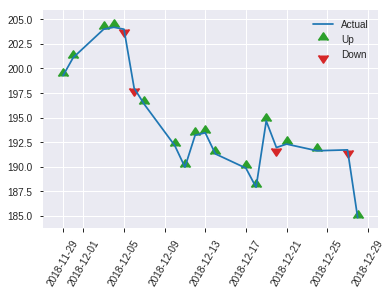


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.22420108329585486
RMSE: 0.473498767998244
LogLoss: 0.6399874214505265
Mean Per-Class Error: 0.3013636363636364
AUC: 0.7142727272727272
pr_auc: 0.6992313978706657
Gini: 0.42854545454545434
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41484323143959045: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      51   49   0.49     (49.0/100.0)
1      13   97   0.1182   (13.0/110.0)
Total  64   146  0.2952   (62.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.414843     0.757812  145
max f2                       0.190218     0.847458  208
max f0point5                 0.435783     0.704334  133
max accuracy                 0.435783     0.704762  133
max precision                0.774018     1         0
max recall                   0.190218     1         208
max specificity              0.774018     1         0
max absolute_mcc             0.414843     0.425123  145
max min_per_class_accuracy   0.479029     0.636364  101
max mean_per_class_accuracy  0.435783     0.698636  133

Gains/Lift Table: Avg response rate: 52.38 %, avg score: 47.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0142857                   0.757175           1.90909   1.90909            1                0.765673  1                           0.765673            0.0272727       0.0272727                  90.9091   90.9091
    2        0.0238095                   0.752181           1.90909   1.90909            1                0.753873  1                           0.760953            0.0181818       0.0454545                  90.9091   90.9091
    3        0.0333333                   0.737642           1.90909   1.90909            1                0.744445  1                           0.756237            0.0181818       0.0636364                  90.9091   90.9091
    4        0.0428571                   0.727024           0.954545  1.69697            0.5              0.731535  0.888889                    0.750747            0.00909091      0.0727273                  -4.54545  69.697
    5        0.052381                    0.712218           0.954545  1.56198            0.5              0.718421  0.818182                    0.74487             0.00909091      0.0818182                  -4.54545  56.1983
    6        0.1                         0.6579             1.14545   1.36364            0.6              0.689846  0.714286                    0.718668            0.0545455       0.136364                   14.5455   36.3636
    7        0.152381                    0.593472           1.56198   1.43182            0.818182         0.62338   0.75                        0.685913            0.0818182       0.218182                   56.1983   43.1818
    8        0.2                         0.57085            1.33636   1.40909            0.7              0.581163  0.738095                    0.660972            0.0636364       0.281818                   33.6364   40.9091
    9        0.3                         0.535781           1.18182   1.33333            0.619048         0.557126  0.698413                    0.626357            0.118182        0.4                        18.1818   33.3333
    10       0.4                         0.500516           1.45455   1.36364            0.761905         0.517133  0.714286                    0.599051            0.145455        0.545455                   45.4545   36.3636
    11       0.5                         0.472186           0.909091  1.27273            0.47619          0.488747  0.666667                    0.57699             0.0909091       0.636364                   -9.09091  27.2727
    12       0.6                         0.441048           1.27273   1.27273            0.666667         0.453986  0.666667                    0.556489            0.127273        0.763636                   27.2727   27.2727
    13       0.7                         0.411124           1.18182   1.25974            0.619048         0.427889  0.659864                    0.538118            0.118182        0.881818                   18.1818   25.974
    14       0.8                         0.380793           0.363636  1.14773            0.190476         0.393887  0.60119                     0.520089            0.0363636       0.918182                   -63.6364  14.7727
    15       0.9                         0.315304           0.272727  1.05051            0.142857         0.351745  0.550265                    0.501384            0.0272727       0.945455                   -72.7273  5.05051
    16       1                           0.166              0.545455  1                  0.285714         0.260356  0.52381                     0.477281           

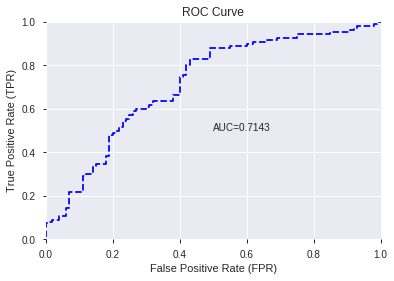

This function is available for GLM models only


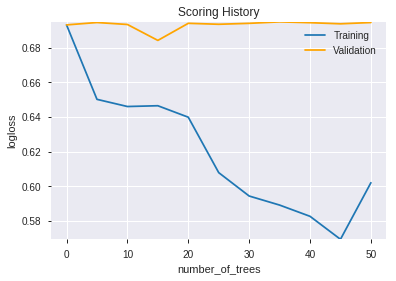

--2019-09-06 01:13:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.114.170
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.114.170|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190906_011259_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190906_011259_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_9435',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190906_011355_model_6  0.647727  0.668345              0.387727  0.484145  0.234396
1  DeepLearning_grid_1_AutoML_20190906_011355_model_9  0.646636  0.675655              0.375455  0.484784  0.235016
2  DeepLearning_grid_1_AutoML_20190906_011355_model_8  0.611909  0.689301              0.412273  0.488585  0.238716
3  DeepLearning_grid_1_AutoML_20190906_011355_model_7  0.611273  0.916979              0.378182  0.531648  0.282650
4  DeepLearning_grid_1_AutoML_20190906_011355_model_1  0.598909  1.655923              0.479545  0.583805  0.340828
5  DeepLearning_grid_1_AutoML_20190906_011355_model_4  0.587545  1.071511              0.484091  0.551935  0.304632
6  DeepLearning_grid_1_AutoML_20190906_011355_model_3  0.583000  1.220144              0.478182  0.566493  0.320914
7  DeepLearning_grid_1_AutoML_20190906_011355_model_5  0.580273  0.682493              0.464545  0.494571  0.244601
8  DeepLearning_grid_1_AutoML_20190906_011355_model_2  0.571273  1.336232              0.500000  0.589456  0.347458
9               DeepLearning_1_AutoML_20190906_011355  0.548091  0.811358              0.469545  0.527736  0.278505

variable  relative_importance  scaled_importance  percentage
0                    DIV             1.000000           1.000000    0.034436
1                    SUB             0.940352           0.940352    0.032382
2                 TRANGE             0.723292           0.723292    0.024907
3                CDLDOJI             0.661314           0.661314    0.022773
4                    BOP             0.646018           0.646018    0.022246
5           CDLSHORTLINE             0.638315           0.638315    0.021981
6               CORREL_8             0.611583           0.611583    0.021061
7            CDLBELTHOLD             0.607608           0.607608    0.020924
8                  MFI_8             0.593129           0.593129    0.020425
9              CDLHAMMER             0.587126           0.587126    0.020218
10             STDDEV_12             0.583007           0.583007    0.020077
11         days_in_month             0.582739           0.582739    0.020067
12        STOCHRSI_fastk             0.576240           0.576240    0.019844
13          weekday_name             0.570784           0.570784    0.019656
14                   day             0.570620           0.570620    0.019650
15         CDLHIKKAKEMOD             0.569773           0.569773    0.019621
16                MFI_24             0.568822           0.568822    0.019588
17             dayofweek             0.568439           0.568439    0.019575
18          aroondown_30             0.567846           0.567846    0.019554
19                   SIN             0.566022           0.566022    0.019492
20                  week             0.565496           0.565496    0.019474
21          MACDEXT_hist             0.565135           0.565135    0.019461
22          aroondown_12             0.563972           0.563972    0.019421
23                MFI_30             0.561020           0.561020    0.019319
24    CDLCLOSINGMARUBOZU             0.560910           0.560910    0.019316
25           AROONOSC_12             0.558509           0.558509    0.019233
26          CDLENGULFING             0.557907           0.557907    0.019212
27            CDLHIKKAKE             0.557513           0.557513    0.019199
28                MFI_20             0.554712           0.554712    0.019102
29           STOCH_slowk             0.552418           0.552418    0.019023
30  HT_PHASOR_quadrature             0.551274           0.551274    0.018984
31     HT_PHASOR_inphase             0.549012           0.549012    0.018906
32           CDLLONGLINE             0.544457           0.544457    0.018749
33      is_quarter_start             0.544292           0.544292    0.018743
34          aroondown_24             0.544208           0.544208    0.018740
35               weekday             0.540776           0.540776    0.018622
36        CDLHARAMICROSS             0.540736           0.540736    0.018621
37           HT_DCPERIOD             0.539681           0.539681    0.018585
38           aroondown_8             0.538065           0.538065    0.018529
39          is_month_end             0.536217           0.536217    0.018465
40                MFI_12             0.535277           0.535277    0.018433
41             aroonup_8             0.534701           0.534701    0.018413
42     CDLDARKCLOUDCOVER             0.534645           0.534645    0.018411
43             CDLHARAMI             0.532798           0.532798    0.018348
44        CDLRICKSHAWMAN             0.531484           0.531484    0.018302
45           CDLMARUBOZU             0.526962           0.526962    0.018147
46          STOCHF_fastk             0.526947           0.526947    0.018146
47             CDLTAKURI             0.523693           0.523693    0.018034
48               BETA_12             0.523197           0.523197    0.018017
49          HT_TRENDMODE             0.510167           0.510167    0.017568

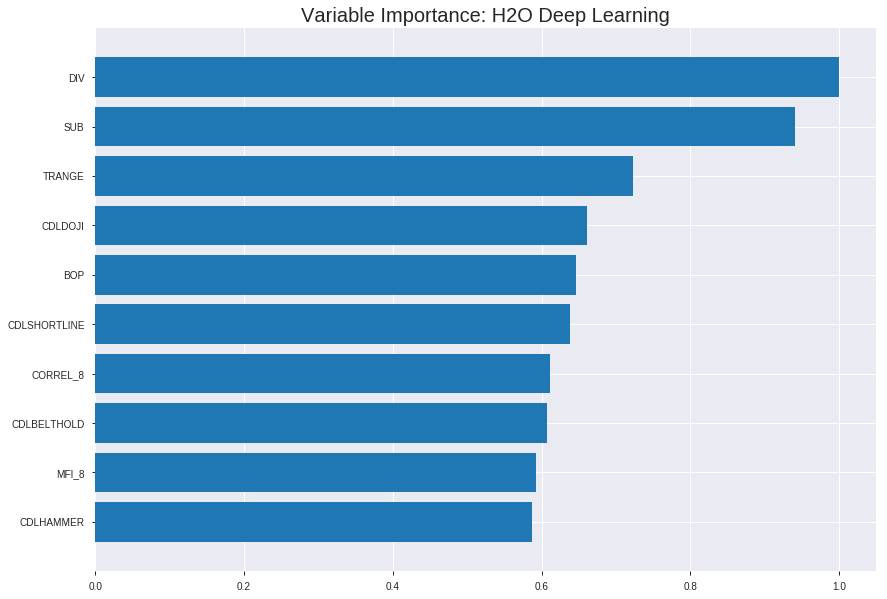

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190906_011355_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2187146765959217
RMSE: 0.4676694095148
LogLoss: 0.6259949609786387
Mean Per-Class Error: 0.3434759962618439
AUC: 0.7101471757929949
pr_auc: 0.7414520818930186
Gini: 0.4202943515859898
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39081034213013366: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      128  531   0.8058   (531.0/659.0)
1      23   784   0.0285   (23.0/807.0)
Total  151  1315  0.3779   (554.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.39081      0.738926  301
max f2                       0.338977     0.866579  323
max f0point5                 0.533926     0.691187  187
max accuracy                 0.533926     0.6603    187
max precision                0.9394       1         0
max recall                   0.101677     1         391
max specificity              0.9394       1         0
max absolute_mcc             0.533926     0.313227  187
max min_per_class_accuracy   0.539886     0.653036  179
max mean_per_class_accuracy  0.533926     0.656524  187

Gains/Lift Table: Avg response rate: 55.05 %, avg score: 52.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102319                   0.859781           1.8166    1.8166             1                0.887133  1                           0.887133            0.0185874       0.0185874                  81.6605   81.6605
    2        0.0204638                   0.779121           1.6955    1.75605            0.933333         0.812804  0.966667                    0.849968            0.0173482       0.0359356                  69.5498   75.6051
    3        0.0300136                   0.742273           1.68685   1.73403            0.928571         0.762515  0.954545                    0.822142            0.016109        0.0520446                  68.6847   73.4032
    4        0.0402456                   0.715798           1.6955    1.72423            0.933333         0.728875  0.949153                    0.79843             0.0173482       0.0693928                  69.5498   72.4235
    5        0.0504775                   0.699286           1.21107   1.62022            0.666667         0.705679  0.891892                    0.779629            0.0123916       0.0817844                  21.107    62.0215
    6        0.100273                    0.647863           1.4931    1.55709            0.821918         0.674763  0.857143                    0.727553            0.0743494       0.156134                   49.31     55.709
    7        0.150068                    0.608297           1.24425   1.45328            0.684932         0.625188  0.8                         0.693587            0.0619579       0.218092                   24.425    45.3284
    8        0.200546                    0.59357            1.25198   1.40262            0.689189         0.600852  0.772109                    0.670245            0.063197        0.281289                   25.1984   40.2617
    9        0.300136                    0.573186           1.29402   1.36658            0.712329         0.582501  0.752273                    0.64113             0.128872        0.410161                   29.402    36.6582
    10       0.400409                    0.556366           1.18635   1.32145            0.653061         0.564516  0.727428                    0.621944            0.118959        0.52912                    18.6354   32.1448
    11       0.5                         0.54236            1.09494   1.27633            0.60274          0.54942   0.702592                    0.607498            0.109046        0.638166                   9.49398   27.6332
    12       0.600273                    0.526755           0.902123  1.21382            0.496599         0.53445   0.668182                    0.595296            0.0904585       0.728625                   -9.78766  21.3822
    13       0.699864                    0.508314           0.933187  1.17389            0.513699         0.517603  0.646199                    0.58424             0.0929368       0.821561                   -6.68126  17.3888
    14       0.800136                    0.476542           0.803261  1.12744            0.442177         0.494175  0.620631                    0.572953            0.0805452       0.902107                   -19.6739  12.7441
    15       0.899727                    0.385546           0.69678   1.07977            0.383562         0.435853  0.59439                     0.557778            0.0693928       0.971499                   -30.322   7.97711
    16       1                           0.0160551          0.284231  1                  0.156463         0.260201  0.550477                    0.527939          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24188377288321217
RMSE: 0.49181680825609464
LogLoss: 0.6753140871415368
Mean Per-Class Error: 0.41828456840762007
AUC: 0.5868881596937381
pr_auc: 0.5469338202437404
Gini: 0.17377631938747617
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3401038513614798: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      40   172  0.8113   (172.0/212.0)
1      11   196  0.0531   (11.0/207.0)
Total  51   368  0.4368   (183.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.340104     0.681739  348
max f2                       0.159179     0.836718  383
max f0point5                 0.380666     0.587867  328
max accuracy                 0.475082     0.579952  251
max precision                0.631375     0.666667  25
max recall                   0.118141     1         391
max specificity              0.820278     0.995283  0
max absolute_mcc             0.340104     0.207257  348
max min_per_class_accuracy   0.507073     0.560386  192
max mean_per_class_accuracy  0.475082     0.581715  251

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 48.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119332                   0.761088           0.809662  0.809662           0.4              0.798136  0.4                         0.798136            0.00966184      0.00966184                 -19.0338  -19.0338
    2        0.0214797                   0.723605           1.51812   1.12453            0.75             0.741606  0.555556                    0.773012            0.0144928       0.0241546                  51.8116   12.453
    3        0.0310263                   0.678698           1.51812   1.24563            0.75             0.693158  0.615385                    0.748442            0.0144928       0.0386473                  51.8116   24.5634
    4        0.0405728                   0.651001           1.01208   1.19068            0.5              0.664846  0.588235                    0.728772            0.00966184      0.0483092                  1.20773   19.0679
    5        0.0501193                   0.640809           1.51812   1.25305            0.75             0.648074  0.619048                    0.713401            0.0144928       0.0628019                  51.8116   25.3048
    6        0.100239                    0.60541            1.15666   1.20485            0.571429         0.622674  0.595238                    0.668037            0.057971        0.120773                   15.666    20.4854
    7        0.150358                    0.581803           0.963883  1.12453            0.47619          0.593078  0.555556                    0.643051            0.0483092       0.169082                   -3.61169  12.453
    8        0.200477                    0.567094           1.25305   1.15666            0.619048         0.574496  0.571429                    0.625912            0.0628019       0.231884                   25.3048   15.666
    9        0.300716                    0.54369            1.10847   1.1406             0.547619         0.555497  0.563492                    0.60244             0.111111        0.342995                   10.8466   14.0595
    10       0.400955                    0.527658           0.963883  1.09642            0.47619          0.535429  0.541667                    0.585688            0.0966184       0.439614                   -3.61169  9.64171
    11       0.501193                    0.506826           1.20485   1.1181             0.595238         0.517712  0.552381                    0.572092            0.120773        0.560386                   20.4854   11.8104
    12       0.599045                    0.487173           1.08613   1.11288            0.536585         0.496758  0.549801                    0.559787            0.10628         0.666667                   8.61317   11.2882
    13       0.699284                    0.460279           0.915689  1.08462            0.452381         0.473961  0.535836                    0.547484            0.0917874       0.758454                   -8.4311   8.46153
    14       0.799523                    0.408244           1.10847   1.08761            0.547619         0.43769   0.537313                    0.533719            0.111111        0.869565                   10.8466   8.76055
    15       0.899761                    0.305732           0.915689  1.06845            0.452381         0.362494  0.527851                    0.514643            0.0917874       0.961353                   -8.4311   6.8453
    16       1                           0.0268389          0.385553  1                  0.190476         0.186317  0.494033                    0.481732            


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:17:28  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 01:17:31  1 min 39.682 sec  973 obs/sec       1.56071   1             2288       0.566982         1.06795             -0.299115      0.641436        0.661005           1.57439          0.385402                         0.580149           1.07045               -0.346484        0.569387          0.520665             0.404831           0.46778
    2019-09-06 01:17:37  1 min 46.194 sec  1923 obs/sec      10.8472   7             15902      0.467669         0.625995            0.116133       0.710147        0.741452           1.8166           0.377899                         0.491817           0.675314              0.0323271        0.586888          0.546934             0.809662           0.436754
    2019-09-06 01:17:44  1 min 52.819 sec  2382 obs/sec      23.2292   15            34054      0.44721          0.581781            0.191774       0.761975        0.789865           1.8166           0.3397                           0.506566           0.713836              -0.0265844       0.580189          0.542266             0.809662           0.427208
    2019-09-06 01:17:50  1 min 59.330 sec  2585 obs/sec      35.6535   23            52268      0.428523         0.542102            0.257911       0.802742        0.834967           1.8166           0.297408                         0.505607           0.71528               -0.0227007       0.585635          0.546078             0.809662           0.431981
    2019-09-06 01:17:57  2 min  5.740 sec  2708 obs/sec      48.1037   31            70520      0.404476         0.492684            0.338859       0.846156        0.872192           1.8166           0.272169                         0.515603           0.747871              -0.0635372       0.57407           0.530892             0.809662           0.422434
    2019-09-06 01:18:03  2 min 12.084 sec  2790 obs/sec      60.5041   39            88699      0.393271         0.469646            0.374981       0.870144        0.892873           1.8166           0.227149                         0.534108           0.810716              -0.141246        0.564158          0.528606             0.809662           0.422434
    2019-09-06 01:18:09  2 min 18.409 sec  2849 obs/sec      72.912    47            106889     0.369454         0.42329             0.448393       0.898934        0.911686           1.8166           0.201228                         0.524773           0.786561              -0.101703        0.57472           0.537029             0.809662           0.417661
    2019-09-06 01:18:10  2 min 19.024 sec  2848 obs/sec      72.912    47            106889     0.467669         0.625995            0.116133       0.710147        0.741452           1.8166           0.377899                         0.491817           0.675314              0.0323271        0.586888          0.546934             0.809662           0.436754

Variable Importances: 


variable      relative_importance    scaled_importance    percentage
------------  ---------------------  -------------------  --------------------
DIV           1.0                    1.0                  0.03443619855059153
SUB           0.9403523206710815     0.9403523206710815   0.03238215922213888
TRANGE        0.7232921123504639     0.7232921123504639   0.02490743079097733
CDLDOJI       0.6613138318061829     0.6613138318061829   0.022773134416330207
BOP           0.6460180878639221     0.6460180878639221   0.022246407140955507
---           ---                    ---                  ---
CDLMARUBOZU   0.5269618034362793     0.5269618034362793   0.0181465612917095
STOCHF_fastk  0.5269467234611511     0.5269467234611511   0.018146041994691848
CDLTAKURI     0.523693323135376      0.523693323135376    0.018034007255108897
BETA_12       0.5231965780258179     0.5231965780258179   0.01801690124188712
HT_TRENDMODE  0.5101673603057861     0.5101673603057861   0.01756822451352122


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6476190476190476)

('F1', 0.7291666666666666)

('auc', 0.6477272727272727)

('logloss', 0.6683450828747726)

('mean_per_class_error', 0.3563636363636363)

('rmse', 0.4841450867413161)

('mse', 0.2343964650157565)

deeplearning prediction progress: |███████████████████████████████████████| 100%


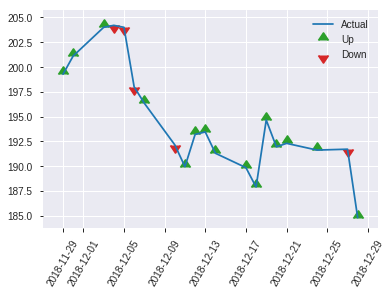


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2343964650157565
RMSE: 0.4841450867413161
LogLoss: 0.6683450828747726
Mean Per-Class Error: 0.3563636363636363
AUC: 0.6477272727272727
pr_auc: 0.59256254339672
Gini: 0.2954545454545454
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35393913691564477: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      27   73   0.73     (73.0/100.0)
1      5    105  0.0455   (5.0/110.0)
Total  32   178  0.3714   (78.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.353939     0.729167  177
max f2                       0.332989     0.853462  180
max f0point5                 0.478343     0.660066  123
max accuracy                 0.478343     0.647619  123
max precision                0.853848     1         0
max recall                   0.0148371    1         209
max specificity              0.853848     1         0
max absolute_mcc             0.397851     0.315355  164
max min_per_class_accuracy   0.499595     0.62      106
max mean_per_class_accuracy  0.478343     0.643636  123

Gains/Lift Table: Avg response rate: 52.38 %, avg score: 46.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0142857                   0.692314           1.27273   1.27273            0.666667         0.788559  0.666667                    0.788559            0.0181818       0.0181818                  27.2727   27.2727
    2        0.0238095                   0.668602           0         0.763636           0                0.678527  0.4                         0.744546            0               0.0181818                  -100      -23.6364
    3        0.0333333                   0.641775           0.954545  0.818182           0.5              0.652844  0.428571                    0.718346            0.00909091      0.0272727                  -4.54545  -18.1818
    4        0.0428571                   0.620422           0.954545  0.848485           0.5              0.631645  0.444444                    0.699079            0.00909091      0.0363636                  -4.54545  -15.1515
    5        0.052381                    0.608498           0         0.694215           0                0.612093  0.363636                    0.683263            0               0.0363636                  -100      -30.5785
    6        0.1                         0.579263           1.14545   0.909091           0.6              0.593751  0.47619                     0.640638            0.0545455       0.0909091                  14.5455   -9.09091
    7        0.152381                    0.566525           1.38843   1.07386            0.727273         0.572876  0.5625                      0.617345            0.0727273       0.163636                   38.843    7.38636
    8        0.2                         0.558999           1.52727   1.18182            0.8              0.56369   0.619048                    0.60457             0.0727273       0.236364                   52.7273   18.1818
    9        0.3                         0.537099           1.27273   1.21212            0.666667         0.546898  0.634921                    0.585346            0.127273        0.363636                   27.2727   21.2121
    10       0.4                         0.522993           1.27273   1.22727            0.666667         0.529632  0.642857                    0.571417            0.127273        0.490909                   27.2727   22.7273
    11       0.5                         0.500511           1.18182   1.21818            0.619048         0.513023  0.638095                    0.559738            0.118182        0.609091                   18.1818   21.8182
    12       0.6                         0.471257           1.18182   1.21212            0.619048         0.488719  0.634921                    0.547902            0.118182        0.727273                   18.1818   21.2121
    13       0.7                         0.443429           1         1.18182            0.52381          0.458754  0.619048                    0.535166            0.1             0.827273                   0         18.1818
    14       0.8                         0.381432           0.818182  1.13636            0.428571         0.418067  0.595238                    0.520529            0.0818182       0.909091                   -18.1818  13.6364
    15       0.9                         0.276474           0.636364  1.08081            0.333333         0.339816  0.566138                    0.50045             0.0636364       0.972727                   -36.3636  8.08081
    16       1                           0.0148371          0.272727  1                  0.142857         0.137762  0.52381                     0.464181    

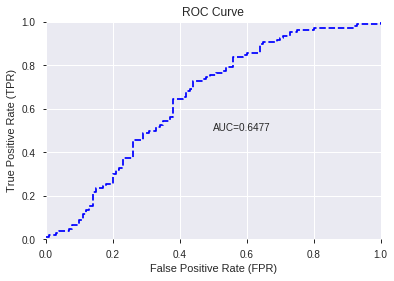

This function is available for GLM models only


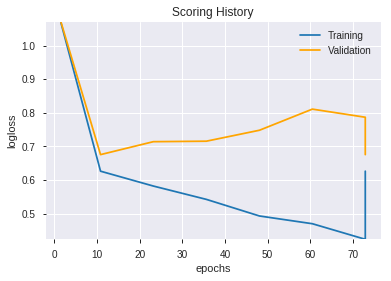

--2019-09-06 01:22:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.140
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.140|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190906_011355_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190906_011355_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_9435',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['DIV',
 'SUB',
 'TRANGE',
 'CDLDOJI',
 'BOP',
 'CDLSHORTLINE',
 'CORREL_8',
 'CDLBELTHOLD',
 'MFI_8',
 'CDLHAMMER',
 'STDDEV_12',
 'days_in_month',
 'STOCHRSI_fastk',
 'weekday_name',
 'day',
 'CDLHIKKAKEMOD',
 'MFI_24',
 'dayofweek',
 'aroondown_30',
 'SIN',
 'week',
 'MACDEXT_hist',
 'aroondown_12',
 'MFI_30',
 'CDLCLOSINGMARUBOZU',
 'AROONOSC_12',
 'CDLENGULFING',
 'CDLHIKKAKE',
 'MFI_20',
 'STOCH_slowk',
 'HT_PHASOR_quadrature',
 'HT_PHASOR_inphase',
 'CDLLONGLINE',
 'is_quarter_start',
 'aroondown_24',
 'weekday',
 'CDLHARAMICROSS',
 'HT_DCPERIOD',
 'aroondown_8',
 'is_month_end',
 'MFI_12',
 'aroonup_8',
 'CDLDARKCLOUDCOVER',
 'CDLHARAMI',
 'CDLRICKSHAWMAN',
 'CDLMARUBOZU',
 'STOCHF_fastk',
 'CDLTAKURI',
 'BETA_12',
 'HT_TRENDMODE']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190906_012217_model_1  0.635364  0.709037                  0.38  0.489983  0.240083

variable  relative_importance  scaled_importance  percentage
0                CDLDOJI             0.155317           1.000000    0.068317
1                    SUB             0.145309           0.935562    0.063915
2                 TRANGE             0.120759           0.777500    0.053117
3            CDLBELTHOLD             0.106305           0.684437    0.046759
4            STOCH_slowk             0.092129           0.593166    0.040523
5            CDLLONGLINE             0.090456           0.582392    0.039787
6                BETA_12             0.087978           0.566443    0.038698
7             CDLHIKKAKE             0.078684           0.506604    0.034610
8     CDLCLOSINGMARUBOZU             0.077678           0.500127    0.034167
9              STDDEV_12             0.076550           0.492861    0.033671
10          CDLENGULFING             0.073093           0.470606    0.032151
11                 MFI_8             0.071063           0.457535    0.031258
12             CDLHARAMI             0.069787           0.449318    0.030696
13                MFI_24             0.058213           0.374799    0.025605
14          CDLSHORTLINE             0.056532           0.363978    0.024866
15                MFI_20             0.053613           0.345183    0.023582
16              CORREL_8             0.050968           0.328158    0.022419
17           HT_DCPERIOD             0.050026           0.322092    0.022004
18                   SIN             0.045928           0.295705    0.020202
19         CDLHIKKAKEMOD             0.040131           0.258381    0.017652
20                   BOP             0.039555           0.254672    0.017398
21          is_month_end             0.038536           0.248113    0.016950
22          aroondown_12             0.036545           0.235294    0.016075
23         days_in_month             0.036280           0.233584    0.015958
24                MFI_30             0.036205           0.233102    0.015925
25           aroondown_8             0.035675           0.229692    0.015692
26             dayofweek             0.033829           0.217808    0.014880
27               weekday             0.033791           0.217562    0.014863
28  HT_PHASOR_quadrature             0.033615           0.216430    0.014786
29             CDLHAMMER             0.031553           0.203154    0.013879
30          MACDEXT_hist             0.030543           0.196652    0.013435
31      is_quarter_start             0.030454           0.196077    0.013395
32          aroondown_24             0.029254           0.188347    0.012867
33                   day             0.028670           0.184589    0.012611
34                   DIV             0.025109           0.161661    0.011044
35     CDLDARKCLOUDCOVER             0.023846           0.153529    0.010489
36          aroondown_30             0.022345           0.143869    0.009829
37          STOCHF_fastk             0.020539           0.132241    0.009034
38           CDLMARUBOZU             0.019641           0.126459    0.008639
39        STOCHRSI_fastk             0.016285           0.104851    0.007163
40        CDLHARAMICROSS             0.013192           0.084934    0.005802
41          HT_TRENDMODE             0.013121           0.084482    0.005772
42             CDLTAKURI             0.010692           0.068839    0.004703
43             aroonup_8             0.009995           0.064350    0.004396
44           AROONOSC_12             0.007456           0.048006    0.003280
45     HT_PHASOR_inphase             0.007264           0.046766    0.003195
46                MFI_12             0.003367           0.021680    0.001481
47        CDLRICKSHAWMAN             0.002990           0.019248    0.001315
48                  week             0.002087           0.013440    0.000918
49          weekday_name             0.000515           0.003318    0.000227

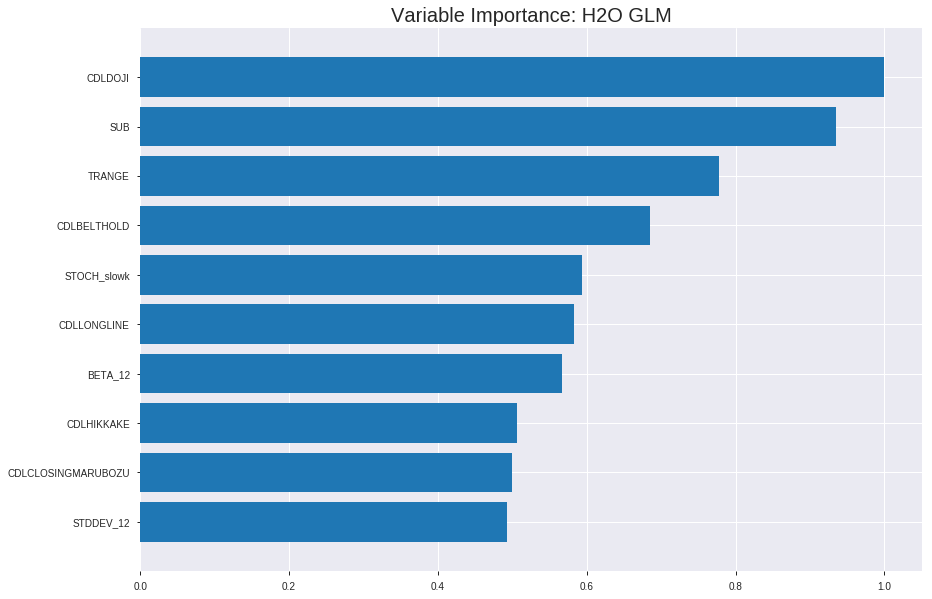

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_012217_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.22593221934429222
RMSE: 0.47532327877381747
LogLoss: 0.6429243336773035
Null degrees of freedom: 1465
Residual degrees of freedom: 1415
Null deviance: 2017.3407122714248
Residual deviance: 1885.0541463418538
AIC: 1987.0541463418538
AUC: 0.6720651808060352
pr_auc: 0.7026936662679615
Gini: 0.34413036161207033
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40861192089266524: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      133  526   0.7982   (526.0/659.0)
1      47   760   0.0582   (47.0/807.0)
Total  180  1286  0.3909   (573.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.408612     0.72623   311
max f2                       0.212687     0.860708  394
max f0point5                 0.554964     0.668249  182
max accuracy                 0.532548     0.639154  208
max precision                0.875488     1         0
max recall                   0.212687     1         394
max specificity              0.875488     1         0
max absolute_mcc             0.532548     0.262537  208
max min_per_class_accuracy   0.563604     0.625774  173
max mean_per_class_accuracy  0.554964     0.631171  182

Gains/Lift Table: Avg response rate: 55.05 %, avg score: 55.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102319                   0.7751             1.8166    1.8166             1                0.797624  1                           0.797624            0.0185874       0.0185874                  81.6605   81.6605
    2        0.0204638                   0.739424           1.6955    1.75605            0.933333         0.757616  0.966667                    0.77762             0.0173482       0.0359356                  69.5498   75.6051
    3        0.0300136                   0.731548           1.55709   1.69275            0.857143         0.735597  0.931818                    0.764249            0.0148699       0.0508055                  55.709    69.2745
    4        0.0402456                   0.718979           1.33218   1.60108            0.733333         0.724     0.881356                    0.754016            0.0136307       0.0644362                  33.2177   60.1075
    5        0.0504775                   0.713596           1.33218   1.54657            0.733333         0.715444  0.851351                    0.746197            0.0136307       0.0780669                  33.2177   54.6569
    6        0.100273                    0.679854           1.26913   1.4088             0.69863          0.693923  0.77551                     0.720238            0.063197        0.141264                   26.9135   40.8795
    7        0.150068                    0.659944           1.24425   1.3542             0.684932         0.670021  0.745455                    0.703575            0.0619579       0.203222                   24.425    35.4196
    8        0.200546                    0.643151           1.17834   1.30993            0.648649         0.651874  0.721088                    0.690562            0.0594796       0.262701                   17.8338   30.9933
    9        0.300136                    0.616412           1.23181   1.28401            0.678082         0.630057  0.706818                    0.670485            0.122677        0.385378                   23.1807   28.4009
    10       0.400409                    0.593854           1.18635   1.25955            0.653061         0.604999  0.693356                    0.654086            0.118959        0.504337                   18.6354   25.9554
    11       0.5                         0.566581           1.09494   1.22677            0.60274          0.580735  0.675307                    0.639476            0.109046        0.613383                   9.49398   22.6766
    12       0.600273                    0.5405             0.988628  1.18699            0.544218         0.553085  0.653409                    0.625045            0.0991326       0.712515                   -1.13716  18.6986
    13       0.699864                    0.508619           0.858532  1.14025            0.472603         0.524248  0.62768                     0.610701            0.0855019       0.798017                   -14.1468  14.0247
    14       0.800136                    0.462266           0.86505   1.10576            0.47619          0.48675   0.608696                    0.595168            0.086741        0.884758                   -13.495   10.5759
    15       0.899727                    0.381679           0.671895  1.05773            0.369863         0.427304  0.582259                    0.576587            0.0669145       0.951673                   -32.8105  5.7735
    16       1                           0.000904183        0.481956  1                  0.265306         0.316203  0.550477                    0.550477          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2451950695574772
RMSE: 0.4951717576331239
LogLoss: 0.6834109638301198
Null degrees of freedom: 418
Residual degrees of freedom: 368
Null deviance: 586.162658197427
Residual deviance: 572.6983876896403
AIC: 674.6983876896403
AUC: 0.5830940661744599
pr_auc: 0.5347082306864699
Gini: 0.16618813234891983
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4001401871665849: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      37   175  0.8255   (175.0/212.0)
1      12   195  0.058    (12.0/207.0)
Total  49   370  0.4463   (187.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.40014      0.67591   351
max f2                       0.260975     0.831994  396
max f0point5                 0.452119     0.579906  302
max accuracy                 0.515306     0.577566  206
max precision                0.773859     1         0
max recall                   0.260975     1         396
max specificity              0.773859     1         0
max absolute_mcc             0.40014      0.18134   351
max min_per_class_accuracy   0.521073     0.566038  197
max mean_per_class_accuracy  0.515306     0.577876  206

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 51.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119332                   0.753489           0.809662  0.809662           0.4              0.761959  0.4                         0.761959            0.00966184      0.00966184                 -19.0338  -19.0338
    2        0.0214797                   0.714263           1.01208   0.899624           0.5              0.725909  0.444444                    0.745937            0.00966184      0.0193237                  1.20773   -10.0376
    3        0.0310263                   0.697712           0.506039  0.778521           0.25             0.704628  0.384615                    0.733226            0.00483092      0.0241546                  -49.3961  -22.1479
    4        0.0405728                   0.683676           1.51812   0.952543           0.75             0.691867  0.470588                    0.723495            0.0144928       0.0386473                  51.8116   -4.74567
    5        0.0501193                   0.66793            1.01208   0.963883           0.5              0.676009  0.47619                     0.71445             0.00966184      0.0483092                  1.20773   -3.61169
    6        0.100239                    0.642214           1.06027   1.01208            0.52381          0.654404  0.5                         0.684427            0.0531401       0.101449                   6.02715   1.20773
    7        0.150358                    0.617397           1.34944   1.12453            0.666667         0.627963  0.555556                    0.665606            0.0676329       0.169082                   34.9436   12.453
    8        0.200477                    0.599824           1.15666   1.13256            0.571429         0.608411  0.559524                    0.651307            0.057971        0.227053                   15.666    13.2563
    9        0.300716                    0.571242           1.01208   1.0924             0.5              0.586488  0.539683                    0.629701            0.101449        0.328502                   1.20773   9.24009
    10       0.400955                    0.542354           1.15666   1.10847            0.571429         0.557729  0.547619                    0.611708            0.115942        0.444444                   15.666    10.8466
    11       0.501193                    0.521073           1.25305   1.13738            0.619048         0.531439  0.561905                    0.595654            0.125604        0.570048                   25.3048   13.7382
    12       0.599045                    0.498722           0.987392  1.11288            0.487805         0.510392  0.549801                    0.581727            0.0966184       0.666667                   -1.26075  11.2882
    13       0.699284                    0.474926           0.915689  1.08462            0.452381         0.486546  0.535836                    0.568083            0.0917874       0.758454                   -8.4311   8.46153
    14       0.799523                    0.43914            1.06027   1.08156            0.52381          0.45801   0.534328                    0.554283            0.10628         0.864734                   6.02715   8.15632
    15       0.899761                    0.388929           0.867495  1.05771            0.428571         0.415729  0.522546                    0.538847            0.0869565       0.951691                   -13.2505  5.77147
    16       1                           0.0294036          0.481942  1                  0.238095         0.328261  0.494033                    0.517738     


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-06 01:22:17  0.000 sec   2            7.7       51            1.36484           1.3931
    2019-09-06 01:22:17  0.016 sec   4            4.8       51            1.35934           1.39033
    2019-09-06 01:22:17  0.033 sec   6            3         51            1.352             1.38677
    2019-09-06 01:22:17  0.046 sec   8            1.8       51            1.34291           1.38262
    2019-09-06 01:22:17  0.058 sec   10           1.1       51            1.33254           1.3783
    2019-09-06 01:22:17  0.077 sec   12           0.71      51            1.32169           1.3744
    2019-09-06 01:22:17  0.095 sec   14           0.44      51            1.31115           1.37131
    2019-09-06 01:22:17  0.112 sec   16           0.27      51            1.30151           1.36913
    2019-09-06 01:22:17  0.129 sec   18           0.17      51            1.29305           1.36766
    2019-09-06 01:22:17  0.146 sec   20           0.11      51            1.28585           1.36682
    2019-09-06 01:22:17  0.167 sec   22           0.066     51            1.27993           1.36684
    2019-09-06 01:22:17  0.181 sec   24           0.041     51            1.27529           1.3681
    2019-09-06 01:22:17  0.199 sec   26           0.025     51            1.27188           1.37075
    2019-09-06 01:22:17  0.219 sec   28           0.016     51            1.26951           1.37461
    2019-09-06 01:22:17  0.237 sec   30           0.0098    51            1.26795           1.37918

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6333333333333333)

('F1', 0.7200000000000001)

('auc', 0.6353636363636364)

('logloss', 0.7090366354816197)

('mean_per_class_error', 0.3795454545454545)

('rmse', 0.4899826051013258)

('mse', 0.24008295330188179)

glm prediction progress: |████████████████████████████████████████████████| 100%


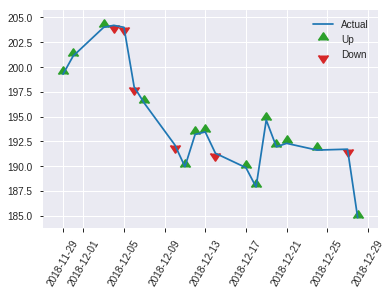


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24008295330188179
RMSE: 0.4899826051013258
LogLoss: 0.7090366354816197
Null degrees of freedom: 209
Residual degrees of freedom: 159
Null deviance: 291.24709670768067
Residual deviance: 297.79538690228026
AIC: 399.79538690228026
AUC: 0.6353636363636364
pr_auc: 0.5920601840133904
Gini: 0.2707272727272727
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3931512662456816: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      34   66   0.66     (66.0/100.0)
1      11   99   0.1      (11.0/110.0)
Total  45   165  0.3667   (77.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.393151     0.72      164
max f2                       4.77255e-05  0.846154  209
max f0point5                 0.393151     0.642857  164
max accuracy                 0.393151     0.633333  164
max precision                0.751676     1         0
max recall                   4.77255e-05  1         209
max specificity              0.751676     1         0
max absolute_mcc             0.393151     0.292119  164
max min_per_class_accuracy   0.491421     0.609091  105
max mean_per_class_accuracy  0.502976     0.620455  99

Gains/Lift Table: Avg response rate: 52.38 %, avg score: 48.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0142857                   0.720651           0.636364  0.636364           0.333333         0.741377  0.333333                    0.741377            0.00909091      0.00909091                 -36.3636  -36.3636
    2        0.0238095                   0.705701           0         0.381818           0                0.712646  0.2                         0.729885            0               0.00909091                 -100      -61.8182
    3        0.0333333                   0.686527           1.90909   0.818182           1                0.694291  0.428571                    0.719715            0.0181818       0.0272727                  90.9091   -18.1818
    4        0.0428571                   0.677083           0         0.636364           0                0.681484  0.333333                    0.711219            0               0.0272727                  -100      -36.3636
    5        0.052381                    0.666676           0.954545  0.694215           0.5              0.673723  0.363636                    0.704402            0.00909091      0.0363636                  -4.54545  -30.5785
    6        0.1                         0.630714           1.33636   1                  0.7              0.649314  0.52381                     0.67817             0.0636364       0.1                        33.6364   0
    7        0.152381                    0.604455           1.56198   1.19318            0.818182         0.613272  0.625                       0.655861            0.0818182       0.181818                   56.1983   19.3182
    8        0.2                         0.577835           1.52727   1.27273            0.8              0.588814  0.666667                    0.639898            0.0727273       0.254545                   52.7273   27.2727
    9        0.3                         0.540916           1.18182   1.24242            0.619048         0.560399  0.650794                    0.613398            0.118182        0.372727                   18.1818   24.2424
    10       0.4                         0.521249           1.18182   1.22727            0.619048         0.531738  0.642857                    0.592983            0.118182        0.490909                   18.1818   22.7273
    11       0.5                         0.492348           1.09091   1.2                0.571429         0.508471  0.628571                    0.576081            0.109091        0.6                        9.09091   20
    12       0.6                         0.464489           0.818182  1.13636            0.428571         0.479859  0.595238                    0.560044            0.0818182       0.681818                   -18.1818  13.6364
    13       0.7                         0.427772           1.09091   1.12987            0.571429         0.444752  0.591837                    0.543574            0.109091        0.790909                   9.09091   12.987
    14       0.8                         0.389413           1.09091   1.125              0.571429         0.406782  0.589286                    0.526475            0.109091        0.9                        9.09091   12.5
    15       0.9                         0.318331           0.454545  1.05051            0.238095         0.354971  0.550265                    0.507419            0.0454545       0.945455                   -54.5455  5.05051
    16       1                           4.77255e-05        0.545455  1                  0.285714         0.237124  0.52381                     0.480389            0.05454

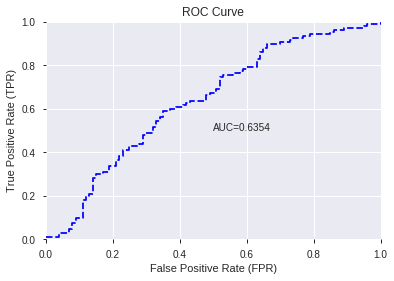

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


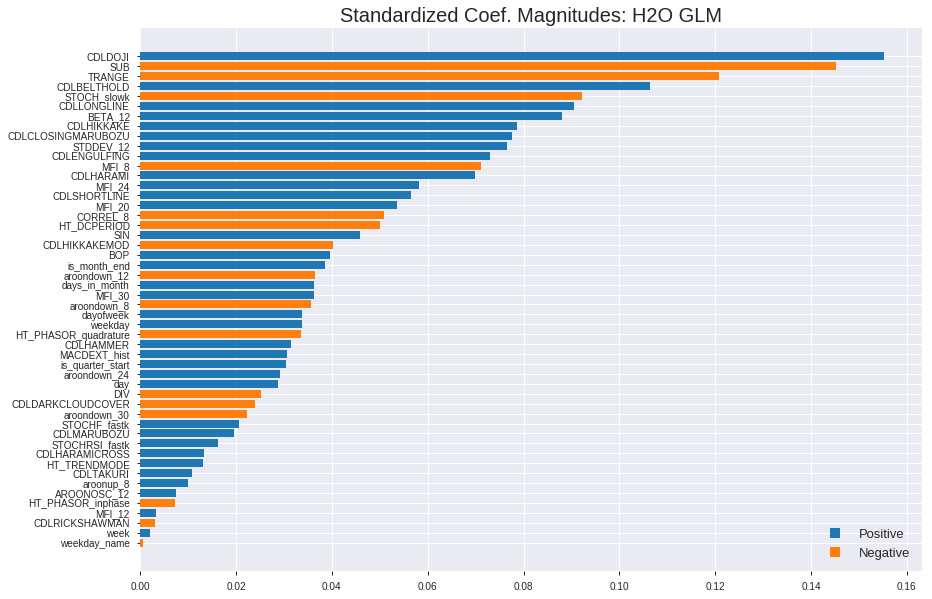

'log_likelihood'
--2019-09-06 01:22:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.206.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.206.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_012217_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_012217_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_9435',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['CDLDOJI',
 'SUB',
 'TRANGE',
 'CDLBELTHOLD',
 'STOCH_slowk',
 'CDLLONGLINE',
 'BETA_12',
 'CDLHIKKAKE',
 'CDLCLOSINGMARUBOZU',
 'STDDEV_12',
 'CDLENGULFING',
 'MFI_8',
 'CDLHARAMI',
 'MFI_24',
 'CDLSHORTLINE',
 'MFI_20',
 'CORREL_8',
 'HT_DCPERIOD',
 'SIN',
 'CDLHIKKAKEMOD',
 'BOP',
 'is_month_end',
 'aroondown_12',
 'days_in_month',
 'MFI_30',
 'aroondown_8',
 'dayofweek',
 'weekday',
 'HT_PHASOR_quadrature',
 'CDLHAMMER',
 'MACDEXT_hist',
 'is_quarter_start',
 'aroondown_24',
 'day',
 'DIV',
 'CDLDARKCLOUDCOVER',
 'aroondown_30',
 'STOCHF_fastk',
 'CDLMARUBOZU',
 'STOCHRSI_fastk',
 'CDLHARAMICROSS',
 'HT_TRENDMODE',
 'CDLTAKURI',
 'aroonup_8',
 'AROONOSC_12',
 'HT_PHASOR_inphase',
 'MFI_12',
 'CDLRICKSHAWMAN',
 'week',
 'weekday_name']

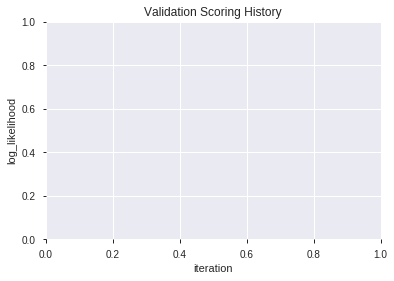

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190906_012234_model_4  0.695273  0.638665              0.336364  0.472864  0.223600
1               XGBoost_2_AutoML_20190906_012234  0.671273  0.660161              0.349545  0.483523  0.233795
2  XGBoost_grid_1_AutoML_20190906_012234_model_2  0.662182  0.656591              0.366364  0.481838  0.232168
3  XGBoost_grid_1_AutoML_20190906_012234_model_6  0.648091  0.656319              0.392273  0.481915  0.232242
4               XGBoost_3_AutoML_20190906_012234  0.646364  0.664050              0.417273  0.485374  0.235588
5  XGBoost_grid_1_AutoML_20190906_012234_model_1  0.638545  0.659579              0.438182  0.483875  0.234135
6               XGBoost_1_AutoML_20190906_012234  0.630091  0.667499              0.361364  0.487307  0.237468
7  XGBoost_grid_1_AutoML_20190906_012234_model_3  0.622000  0.673358              0.391364  0.490826  0.240910
8  XGBoost_grid_1_AutoML_20190906_012234_model_7  0.616182  0.674277              0.444091  0.490566  0.240655
9  XGBoost_grid_1_AutoML_20190906_012234_model_5  0.588273  0.692429              0.438182  0.499637  0.249637

variable  relative_importance  scaled_importance  percentage
0                    DIV           646.128601           1.000000    0.224966
1                    BOP           307.891754           0.476518    0.107200
2            HT_DCPERIOD           145.720245           0.225528    0.050736
3            STOCH_slowk           137.527924           0.212849    0.047884
4              STDDEV_12           137.482178           0.212778    0.047868
5           MACDEXT_hist           129.115005           0.199829    0.044955
6           STOCHF_fastk           122.441589           0.189500    0.042631
7                BETA_12           119.682457           0.185230    0.041670
8               CORREL_8            94.860542           0.146814    0.033028
9            CDLBELTHOLD            94.664856           0.146511    0.032960
10                 MFI_8            87.249237           0.135034    0.030378
11        STOCHRSI_fastk            79.172646           0.122534    0.027566
12                   SIN            77.642136           0.120165    0.027033
13                TRANGE            76.362579           0.118185    0.026588
14                MFI_24            69.996864           0.108333    0.024371
15                MFI_20            57.644081           0.089215    0.020070
16                MFI_30            56.645939           0.087670    0.019723
17                   day            53.414173           0.082668    0.018597
18     HT_PHASOR_inphase            51.312386           0.079415    0.017866
19             dayofweek            47.417549           0.073387    0.016510
20             aroonup_8            44.629787           0.069073    0.015539
21                   SUB            33.300194           0.051538    0.011594
22          aroondown_30            32.584496           0.050430    0.011345
23                MFI_12            26.783285           0.041452    0.009325
24          weekday_name            25.517792           0.039493    0.008885
25         days_in_month            21.517590           0.033302    0.007492
26           AROONOSC_12            21.232330           0.032861    0.007393
27           aroondown_8            16.632578           0.025742    0.005791
28  HT_PHASOR_quadrature            15.855083           0.024539    0.005520
29          CDLSHORTLINE            14.345448           0.022202    0.004995
30          aroondown_24            12.766762           0.019759    0.004445
31    CDLCLOSINGMARUBOZU             5.630456           0.008714    0.001960
32                  week             5.429207           0.008403    0.001890
33               CDLDOJI             3.521661           0.005450    0.001226

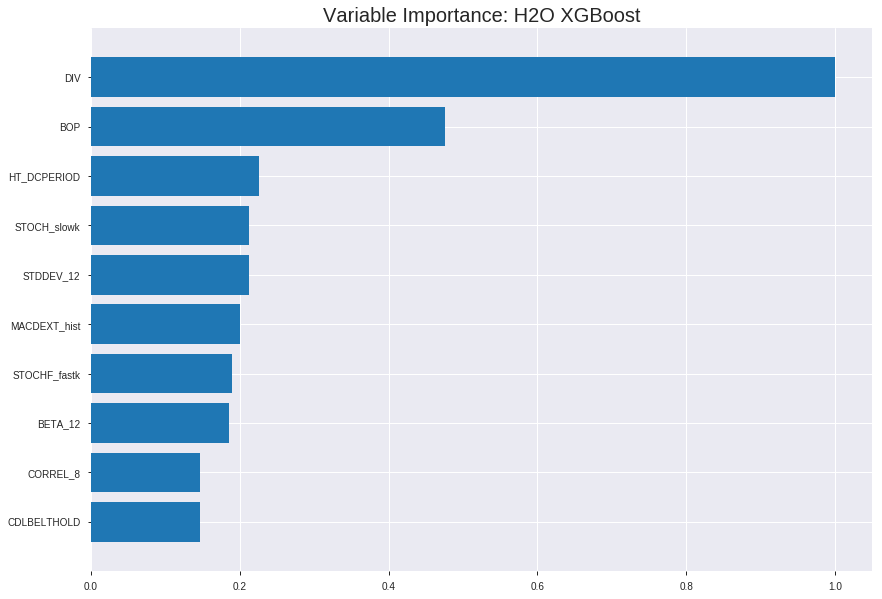

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190906_012234_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.23002682740877392
RMSE: 0.47961112102282816
LogLoss: 0.6513743214470652
Mean Per-Class Error: 0.40061826243435195
AUC: 0.6418336896615916
pr_auc: 0.716479196417268
Gini: 0.2836673793231832
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39428606629371643: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      94   565   0.8574   (565.0/659.0)
1      28   779   0.0347   (28.0/807.0)
Total  122  1344  0.4045   (593.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.394286     0.724314  306
max f2                       0.248592     0.861811  388
max f0point5                 0.5          0.637366  227
max accuracy                 0.5          0.606412  227
max precision                0.801529     1         0
max recall                   0.248592     1         388
max specificity              0.801529     1         0
max absolute_mcc             0.565438     0.252481  170
max min_per_class_accuracy   0.503408     0.324659  224
max mean_per_class_accuracy  0.539551     0.599382  193

Gains/Lift Table: Avg response rate: 55.05 %, avg score: 51.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102319                   0.743371           1.6955    1.6955             0.933333         0.765926  0.933333                    0.765926            0.0173482       0.0173482                  69.5498   69.5498
    2        0.0204638                   0.730027           1.6955    1.6955             0.933333         0.735994  0.933333                    0.75096             0.0173482       0.0346964                  69.5498   69.5498
    3        0.0300136                   0.718486           1.68685   1.69275            0.928571         0.723999  0.931818                    0.742381            0.016109        0.0508055                  68.6847   69.2745
    4        0.0402456                   0.700578           1.45328   1.63187            0.8              0.709728  0.898305                    0.73408             0.0148699       0.0656753                  45.3284   63.1865
    5        0.0504775                   0.689312           1.57439   1.62022            0.866667         0.694176  0.891892                    0.725991            0.016109        0.0817844                  57.4391   62.0215
    6        0.100273                    0.643376           1.54287   1.58181            0.849315         0.665357  0.870748                    0.69588             0.0768278       0.158612                   54.287    58.1805
    7        0.150068                    0.602657           1.29402   1.48631            0.712329         0.62053   0.818182                    0.670878            0.0644362       0.223048                   29.402    48.6313
    8        0.200546                    0.544576           1.25198   1.42733            0.689189         0.574747  0.785714                    0.646682            0.063197        0.286245                   25.1984   42.7332
    9        0.836289                    0.5                0.968726  1.0787             0.533262         0.50163   0.593801                    0.536414            0.615861        0.902107                   -3.12741  7.87017
    10       0.899727                    0.418794           0.781335  1.05773            0.430108         0.466214  0.582259                    0.531465            0.0495663       0.951673                   -21.8665  5.7735
    11       1                           0.209165           0.481956  1                  0.265306         0.327625  0.550477                    0.511025            0.0483271       1                          -51.8044  0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25
RMSE: 0.5
LogLoss: 0.6931471805599462
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    212  1        (212.0/212.0)
1      0    207  0        (0.0/207.0)
Total  0    419  0.506    (212.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.5          0.661342  0
max f2                       0.5          0.829992  0
max f0point5                 0.5          0.549655  0
max accuracy                 0.5          0.494033  0
max precision                0.5          0.494033  0
max recall                   0.5          1         0
max specificity              0.5          0         0
max absolute_mcc             0.5          0         0
max min_per_class_accuracy   0.5          0         0
max mean_per_class_accuracy  0.5          0.5       0

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 50.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0.5                1       1                  0.494033         0.5      0.494033                    0.5                 1               1                          0       0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:22:39  1.946 sec   0                  0.5              0.693147            0.5             0                  1                0.449523                         0.5                0.693147              0.5               0                    1                  0.505967
    2019-09-06 01:22:40  2.000 sec   5                  0.489127         0.671576            0.702502        0.739792           1.8166           0.351296                         0.499303           0.691749              0.518435          0.538643             1.21449            0.491647
    2019-09-06 01:22:40  2.051 sec   10                 0.490832         0.674777            0.603267        0.676702           1.8166           0.40382                          0.5                0.693147              0.5               0                    1                  0.505967
    2019-09-06 01:22:40  2.087 sec   15                 0.478907         0.651223            0.690968        0.730013           1.8166           0.355389                         0.492955           0.678911              0.591924          0.546085             0.404831           0.429594
    2019-09-06 01:22:40  2.134 sec   20                 0.486334         0.665466            0.611779        0.686701           1.8166           0.400409                         0.5                0.693147              0.5               0                    1                  0.505967
    2019-09-06 01:22:40  2.174 sec   25                 0.485531         0.663924            0.624656        0.694114           1.6955           0.407231                         0.5                0.693147              0.5               0                    1                  0.505967
    2019-09-06 01:22:40  2.220 sec   30                 0.484113         0.66096             0.627846        0.699637           1.8166           0.407913                         0.4935             0.679709              0.575016          0.546231             0.809662           0.446301
    2019-09-06 01:22:40  2.281 sec   35                 0.482904         0.658384            0.631795        0.704859           1.8166           0.405184                         0.5                0.693147              0.5               0                    1                  0.505967
    2019-09-06 01:22:40  2.325 sec   40                 0.481072         0.65414             0.627768        0.700547           1.8166           0.390859                         0.5                0.693147              0.5               0                    1                  0.505967
    2019-09-06 01:22:40  2.376 sec   45                 0.480614         0.653534            0.641709        0.714126           1.8166           0.405184                         0.5                0.693147              0.5               0                    1                  0.505967
    2019-09-06 01:22:40  2.423 sec   50                 0.479611         0.651374            0.641834        0.716479           1.6955           0.404502                         0.5                0.693147              0.5               0                    1                  0.505967

Variable Importances: 


variable            relative_importance    scaled_importance     percentage
------------------  ---------------------  --------------------  ---------------------
DIV                 646.1286010742188      1.0                   0.2249657861772785
BOP                 307.8917541503906      0.47651776076543634   0.10720019267803271
HT_DCPERIOD         145.72024536132812     0.22552823868044453   0.05073613751992311
STOCH_slowk         137.52792358398438     0.21284915008457733   0.04788377638594248
STDDEV_12           137.482177734375       0.21277835017023625   0.04786784882755146
---                 ---                    ---                   ---
CDLSHORTLINE        14.345447540283203     0.022202155292976092  0.0049947253203143915
aroondown_24        12.766761779785156     0.01975885568068001   0.004445066502167565
CDLCLOSINGMARUBOZU  5.63045597076416       0.008714141366599879  0.001960383663397086
week                5.4292073249816895     0.008402672960081601  0.0018903139284553172
CDLDOJI             3.521660804748535      0.005450402286624692  0.0012261540353929602


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6761904761904762)

('F1', 0.7499999999999999)

('auc', 0.6952727272727273)

('logloss', 0.6386649808400947)

('mean_per_class_error', 0.3340909090909091)

('rmse', 0.47286365043853257)

('mse', 0.2236000319060547)

xgboost prediction progress: |████████████████████████████████████████████| 100%


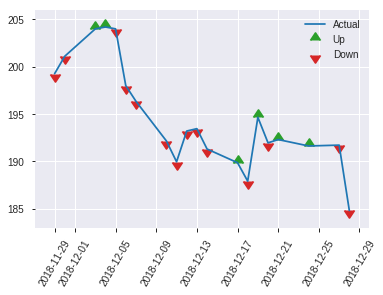


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2236000319060547
RMSE: 0.47286365043853257
LogLoss: 0.6386649808400947
Mean Per-Class Error: 0.3340909090909091
AUC: 0.6952727272727273
pr_auc: 0.6445733793924091
Gini: 0.39054545454545453
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39171919226646423: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      40   60   0.6      (60.0/100.0)
1      8    102  0.0727   (8.0/110.0)
Total  48   162  0.3238   (68.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.391719     0.75      161
max f2                       0.331134     0.861244  186
max f0point5                 0.523531     0.683673  94
max accuracy                 0.426122     0.67619   151
max precision                0.771311     1         0
max recall                   0.267751     1         206
max specificity              0.771311     1         0
max absolute_mcc             0.391719     0.389249  161
max min_per_class_accuracy   0.512121     0.645455  105
max mean_per_class_accuracy  0.426122     0.665909  151

Gains/Lift Table: Avg response rate: 52.38 %, avg score: 49.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0142857                   0.718378           1.27273   1.27273            0.666667         0.739043  0.666667                    0.739043            0.0181818       0.0181818                  27.2727   27.2727
    2        0.0238095                   0.71053            0.954545  1.14545            0.5              0.714542  0.6                         0.729243            0.00909091      0.0272727                  -4.54545  14.5455
    3        0.0333333                   0.701746           0.954545  1.09091            0.5              0.703581  0.571429                    0.721911            0.00909091      0.0363636                  -4.54545  9.09091
    4        0.0428571                   0.689746           0.954545  1.06061            0.5              0.695221  0.555556                    0.71598             0.00909091      0.0454545                  -4.54545  6.06061
    5        0.052381                    0.681308           0.954545  1.04132            0.5              0.687741  0.545455                    0.710845            0.00909091      0.0545455                  -4.54545  4.13223
    6        0.1                         0.62964            1.52727   1.27273            0.8              0.649335  0.666667                    0.681555            0.0727273       0.127273                   52.7273   27.2727
    7        0.152381                    0.610698           1.04132   1.19318            0.545455         0.619959  0.625                       0.660381            0.0545455       0.181818                   4.13223   19.3182
    8        0.2                         0.589425           1.14545   1.18182            0.6              0.600328  0.619048                    0.646083            0.0545455       0.236364                   14.5455   18.1818
    9        0.3                         0.561938           1.54545   1.30303            0.809524         0.573183  0.68254                     0.621783            0.154545        0.390909                   54.5455   30.303
    10       0.4                         0.533258           1.45455   1.34091            0.761905         0.5498    0.702381                    0.603787            0.145455        0.536364                   45.4545   34.0909
    11       0.5                         0.512306           1         1.27273            0.52381          0.523044  0.666667                    0.587638            0.1             0.636364                   0         27.2727
    12       0.6                         0.477647           1         1.22727            0.52381          0.497841  0.642857                    0.572672            0.1             0.736364                   0         22.7273
    13       0.7                         0.432544           1.18182   1.22078            0.619048         0.457374  0.639456                    0.556201            0.118182        0.854545                   18.1818   22.0779
    14       0.8                         0.371547           0.727273  1.15909            0.380952         0.403211  0.607143                    0.537077            0.0727273       0.927273                   -27.2727  15.9091
    15       0.9                         0.320694           0.545455  1.09091            0.285714         0.349518  0.571429                    0.516237            0.0545455       0.981818                   -45.4545  9.09091
    16       1                           0.239898           0.181818  1                  0.0952381        0.288578  0.52381                     0.493471          

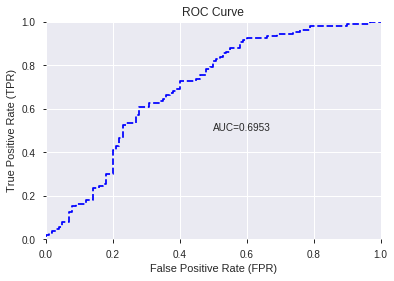

This function is available for GLM models only


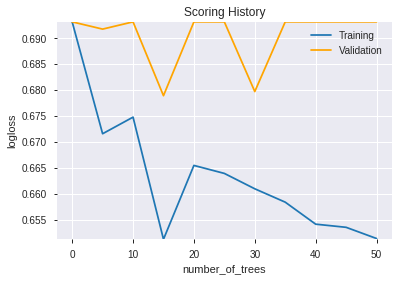

--2019-09-06 01:22:51--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.49.0
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.49.0|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genm

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190906_012234_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190906_012234_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_9435',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['DIV',
 'BOP',
 'HT_DCPERIOD',
 'STOCH_slowk',
 'STDDEV_12',
 'MACDEXT_hist',
 'STOCHF_fastk',
 'BETA_12',
 'CORREL_8',
 'CDLBELTHOLD',
 'MFI_8',
 'STOCHRSI_fastk',
 'SIN',
 'TRANGE',
 'MFI_24',
 'MFI_20',
 'MFI_30',
 'day',
 'HT_PHASOR_inphase',
 'dayofweek',
 'aroonup_8',
 'SUB',
 'aroondown_30',
 'MFI_12',
 'weekday_name',
 'days_in_month',
 'AROONOSC_12',
 'aroondown_8',
 'HT_PHASOR_quadrature',
 'CDLSHORTLINE',
 'aroondown_24',
 'CDLCLOSINGMARUBOZU',
 'week',
 'CDLDOJI']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [931 944] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


9

['NATR_8',
 'NATR_12',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLDOJI',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190906_012309_model_1  0.706727  0.994409              0.353636  0.564559  0.318726
1  DeepLearning_grid_1_AutoML_20190906_012309_model_2  0.704273  0.851183              0.393636  0.499482  0.249483
2  DeepLearning_grid_1_AutoML_20190906_012309_model_5  0.699636  0.660360              0.369545  0.477377  0.227889
3  DeepLearning_grid_1_AutoML_20190906_012309_model_4  0.697091  0.654612              0.381818  0.473874  0.224557
4               DeepLearning_1_AutoML_20190906_012309  0.688545  0.743212              0.407727  0.495760  0.245778
5  DeepLearning_grid_1_AutoML_20190906_012309_model_6  0.684364  0.683497              0.376818  0.480700  0.231072
6  DeepLearning_grid_1_AutoML_20190906_012309_model_9  0.682909  0.680438              0.363636  0.486078  0.236272
7  DeepLearning_grid_1_AutoML_20190906_012309_model_3  0.681727  0.806060              0.359091  0.491531  0.241603
8  DeepLearning_grid_1_AutoML_20190906_012309_model_8  0.680636  0.688459              0.391364  0.485787  0.235989
9  DeepLearning_grid_1_AutoML_20190906_012309_model_7  0.636636  0.755431              0.437273  0.519455  0.269833

variable  relative_importance  scaled_importance  percentage
0                 SUB             1.000000           1.000000    0.167122
1             NATR_12             0.712104           0.712104    0.119008
2        CDLSHORTLINE             0.675969           0.675969    0.112969
3              NATR_8             0.666386           0.666386    0.111368
4             CDLDOJI             0.612045           0.612045    0.102286
5         CDLBELTHOLD             0.610772           0.610772    0.102073
6  CDLCLOSINGMARUBOZU             0.610138           0.610138    0.101967
7         CDLLONGLINE             0.581438           0.581438    0.097171
8         CDLMARUBOZU             0.514810           0.514810    0.086036

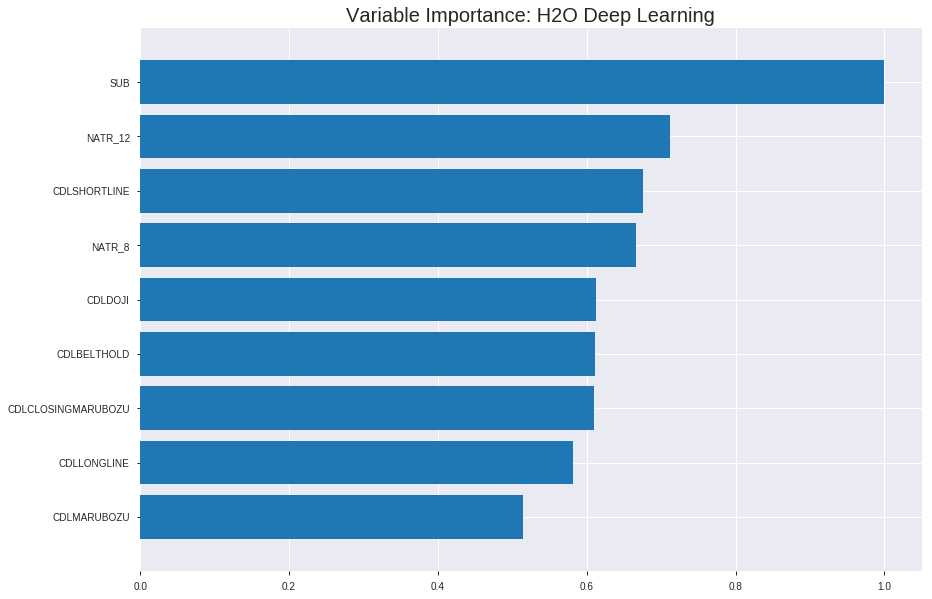

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190906_012309_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23789414328738073
RMSE: 0.48774393208668493
LogLoss: 0.6834651575960728
Mean Per-Class Error: 0.36101599622423675
AUC: 0.6641573259773642
pr_auc: 0.6780440048919859
Gini: 0.3283146519547284
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3117278646611037: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      268  391   0.5933   (391.0/659.0)
1      128  679   0.1586   (128.0/807.0)
Total  396  1070  0.354    (519.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.311728     0.723495  276
max f2                       0.0489715    0.862328  384
max f0point5                 0.47366      0.676119  210
max accuracy                 0.384243     0.65075   248
max precision                0.995888     1         0
max recall                   0.0106779    1         396
max specificity              0.995888     1         0
max absolute_mcc             0.379307     0.285562  249
max min_per_class_accuracy   0.572316     0.616085  174
max mean_per_class_accuracy  0.47366      0.638984  210

Gains/Lift Table: Avg response rate: 55.05 %, avg score: 51.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102319                   0.91812            1.57439   1.57439            0.866667         0.957093   0.866667                    0.957093            0.016109        0.016109                   57.4391   57.4391
    2        0.0204638                   0.879747           1.57439   1.57439            0.866667         0.894768   0.866667                    0.92593             0.016109        0.0322181                  57.4391   57.4391
    3        0.0300136                   0.854938           1.16782   1.44503            0.642857         0.863722   0.795455                    0.906137            0.0111524       0.0433705                  16.7817   44.5026
    4        0.0402456                   0.825096           1.45328   1.44713            0.8              0.84184    0.79661                     0.88979             0.0148699       0.0582404                  45.3284   44.7126
    5        0.0504775                   0.805844           0.968856  1.35018            0.533333         0.811863   0.743243                    0.873994            0.00991326      0.0681537                  -3.11442  35.0179
    6        0.100273                    0.763354           1.3189    1.33465            0.726027         0.782555   0.734694                    0.828585            0.0656753       0.133829                   31.8905   33.4648
    7        0.150068                    0.742054           1.21936   1.2964             0.671233         0.751892   0.713636                    0.803137            0.0607187       0.194548                   21.9365   29.6395
    8        0.200546                    0.732873           1.20289   1.27286            0.662162         0.737813   0.70068                     0.786695            0.0607187       0.255266                   20.2887   27.2859
    9        0.300136                    0.715937           1.24425   1.26337            0.684932         0.724158   0.695455                    0.765944            0.123916        0.379182                   24.425    26.3366
    10       0.400409                    0.672469           1.11221   1.22551            0.612245         0.702859   0.674617                    0.750146            0.111524        0.490706                   11.2207   22.5512
    11       0.5                         0.58763            1.13227   1.20694            0.623288         0.636897   0.664393                    0.727589            0.112763        0.60347                    13.2267   20.6939
    12       0.600273                    0.463172           1.19871   1.20556            0.659864         0.52292    0.663636                    0.6934              0.120198        0.723668                   19.8712   20.5565
    13       0.699864                    0.350648           0.920745  1.16503            0.506849         0.404052   0.641326                    0.652226            0.0916976       0.815366                   -7.92551  16.5035
    14       0.800136                    0.237687           0.654966  1.10111            0.360544         0.291749   0.606138                    0.607051            0.0656753       0.881041                   -34.5034  10.1113
    15       0.899727                    0.135767           0.671895  1.0536             0.369863         0.181942   0.579985                    0.559996            0.0669145       0.947955                   -32.8105  5.36032
    16       1                           2.20662e-06        0.51903   1                  0.285714         0.0772501  0.550477                   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3179593904921851
RMSE: 0.5638788792747828
LogLoss: 0.9231943447794109
Mean Per-Class Error: 0.41680339075745143
AUC: 0.5931318931729104
pr_auc: 0.5497086623625089
Gini: 0.18626378634582075
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.033676082499371256: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      26   186  0.8774   (186.0/212.0)
1      5    202  0.0242   (5.0/207.0)
Total  31   388  0.4558   (191.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0336761    0.678992  369
max f2                       0.0209887    0.840097  384
max f0point5                 0.0866711    0.590394  309
max accuracy                 0.139045     0.579952  253
max precision                0.821686     0.75      3
max recall                   0.0209887    1         384
max specificity              0.943085     0.995283  0
max absolute_mcc             0.0789276    0.198045  316
max min_per_class_accuracy   0.231204     0.550725  204
max mean_per_class_accuracy  0.0866711    0.583197  309

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 27.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119332                   0.811909           1.21449   1.21449            0.6              0.863589   0.6                         0.863589            0.0144928       0.0144928                  21.4493   21.4493
    2        0.0214797                   0.754444           1.01208   1.12453            0.5              0.783293   0.555556                    0.827902            0.00966184      0.0241546                  1.20773   12.453
    3        0.0310263                   0.730656           0.506039  0.934225           0.25             0.738511   0.461538                    0.800397            0.00483092      0.0289855                  -49.3961  -6.57748
    4        0.0405728                   0.713781           1.51812   1.07161            0.75             0.72759    0.529412                    0.783266            0.0144928       0.0434783                  51.8116   7.16113
    5        0.0501193                   0.706443           1.01208   1.06027            0.5              0.707822   0.52381                     0.768896            0.00966184      0.0531401                  1.20773   6.02715
    6        0.100239                    0.639235           1.15666   1.10847            0.571429         0.670048   0.547619                    0.719472            0.057971        0.111111                   15.666    10.8466
    7        0.150358                    0.51479            1.25305   1.15666            0.619048         0.579403   0.571429                    0.672782            0.0628019       0.173913                   25.3048   15.666
    8        0.200477                    0.470469           1.15666   1.15666            0.571429         0.48922    0.571429                    0.626892            0.057971        0.231884                   15.666    15.666
    9        0.300716                    0.350446           1.15666   1.15666            0.571429         0.40975    0.571429                    0.554511            0.115942        0.347826                   15.666    15.666
    10       0.400955                    0.295409           1.15666   1.15666            0.571429         0.310644   0.571429                    0.493544            0.115942        0.463768                   15.666    15.666
    11       0.501193                    0.230983           0.867495  1.09883            0.428571         0.273264   0.542857                    0.449488            0.0869565       0.550725                   -13.2505  9.88268
    12       0.599045                    0.151227           1.23424   1.12095            0.609756         0.179334   0.553785                    0.405359            0.120773        0.671498                   23.4241   12.0946
    13       0.699284                    0.112772           0.963883  1.09843            0.47619          0.130086   0.542662                    0.3659              0.0966184       0.768116                   -3.61169  9.8432
    14       0.799523                    0.0718065          1.01208   1.08761            0.5              0.0935408  0.537313                    0.331754            0.101449        0.869565                   1.20773   8.76055
    15       0.899761                    0.0436786          0.819301  1.05771            0.404762         0.0583091  0.522546                    0.301291            0.0821256       0.951691                   -18.0699  5.77147
    16       1                           0.000237534        0.481942  1                  0.238095         0.0256965  0.494033                    0.27


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:23:10  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 01:23:11  1.568 sec   9715 obs/sec      10        1             14660      0.541303         0.856106            -0.184103      0.597948        0.614386           1.08996          0.44543                          0.627875           1.32821               -0.57713         0.600253          0.548368             1.21449            0.463007
    2019-09-06 01:23:17  7.563 sec   9813 obs/sec      50        5             73300      0.529729         0.838879            -0.134011      0.620226        0.626648           1.08996          0.442701                         0.635871           1.44977               -0.617556        0.603717          0.545744             1.21449            0.460621
    2019-09-06 01:23:23  13.321 sec  10006 obs/sec     90        9             131940     0.507544         0.728448            -0.041013      0.624309        0.628838           1.08996          0.424966                         0.58264            0.976649              -0.358072        0.607465          0.544029             0.809662           0.46778
    2019-09-06 01:23:29  18.717 sec  10276 obs/sec     130       13            190580     0.491483         0.692575            0.0238271      0.660939        0.676673           1.45328          0.407231                         0.569982           0.946482              -0.299705        0.596846          0.553722             1.21449            0.465394
    2019-09-06 01:23:34  23.864 sec  10534 obs/sec     170       17            249220     0.487744         0.683465            0.0386252      0.664157        0.678044           1.57439          0.354025                         0.563879           0.923194              -0.272019        0.593132          0.549709             1.21449            0.455847
    2019-09-06 01:23:40  29.888 sec  10878 obs/sec     220       22            322520     0.486727         0.68239             0.0426308      0.665914        0.684729           1.6955           0.347203                         0.567286           0.943442              -0.287438        0.602486          0.55671              1.21449            0.431981
    2019-09-06 01:23:45  35.701 sec  11225 obs/sec     270       27            395820     0.496125         0.708653            0.005301       0.661293        0.67418            1.6955           0.400409                         0.574188           0.982009              -0.318958        0.599262          0.557739             0.809662           0.451074
    2019-09-06 01:23:51  41.080 sec  11553 obs/sec     320       32            469120     0.498222         0.723297            -0.0031239     0.66691         0.681046           1.6955           0.402456                         0.587692           1.07427               -0.381726        0.597074          0.557075             0.809662           0.448687
    2019-09-06 01:23:51  41.123 sec  11551 obs/sec     320       32            469120     

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
SUB                 1                      1                    0.167122
NATR_12             0.712104               0.712104             0.119008
CDLSHORTLINE        0.675969               0.675969             0.112969
NATR_8              0.666386               0.666386             0.111368
CDLDOJI             0.612045               0.612045             0.102286
CDLBELTHOLD         0.610772               0.610772             0.102073
CDLCLOSINGMARUBOZU  0.610138               0.610138             0.101967
CDLLONGLINE         0.581438               0.581438             0.097171
CDLMARUBOZU         0.51481                0.51481              0.086036

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7)

('F1', 0.7272727272727272)

('auc', 0.7067272727272728)

('logloss', 0.9944094422539037)

('mean_per_class_error', 0.30000000000000004)

('rmse', 0.5645586188115986)

('mse', 0.31872643407445994)

deeplearning prediction progress: |███████████████████████████████████████| 100%


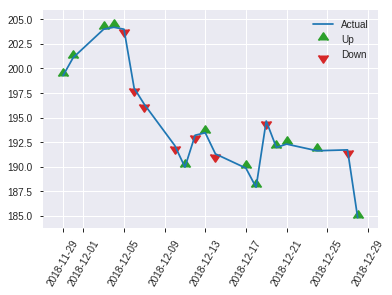


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.31872643407445994
RMSE: 0.5645586188115986
LogLoss: 0.9944094422539037
Mean Per-Class Error: 0.30000000000000004
AUC: 0.7067272727272728
pr_auc: 0.668439162642924
Gini: 0.4134545454545455
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.06818495197567945: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      42   58   0.58     (58.0/100.0)
1      14   96   0.1273   (14.0/110.0)
Total  56   154  0.3429   (72.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.068185     0.727273  153
max f2                       0.0128645    0.856918  195
max f0point5                 0.151137     0.715613  106
max accuracy                 0.151137     0.7       106
max precision                0.731434     1         0
max recall                   3.67355e-07  1         209
max specificity              0.731434     1         0
max absolute_mcc             0.151137     0.399619  106
max min_per_class_accuracy   0.151137     0.7       106
max mean_per_class_accuracy  0.151137     0.7       106

Gains/Lift Table: Avg response rate: 52.38 %, avg score: 23.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0142857                   0.725599           1.90909   1.90909            1                0.728598    1                           0.728598            0.0272727       0.0272727                  90.9091   90.9091
    2        0.0238095                   0.70888            0.954545  1.52727            0.5              0.7118      0.8                         0.721879            0.00909091      0.0363636                  -4.54545  52.7273
    3        0.0333333                   0.702071           0.954545  1.36364            0.5              0.702616    0.714286                    0.716375            0.00909091      0.0454545                  -4.54545  36.3636
    4        0.0428571                   0.695348           0.954545  1.27273            0.5              0.699073    0.666667                    0.71253             0.00909091      0.0545455                  -4.54545  27.2727
    5        0.052381                    0.688068           0.954545  1.21488            0.5              0.691508    0.636364                    0.708708            0.00909091      0.0636364                  -4.54545  21.4876
    6        0.1                         0.594937           1.14545   1.18182            0.6              0.647666    0.619048                    0.67964             0.0545455       0.118182                   14.5455   18.1818
    7        0.152381                    0.479193           1.56198   1.3125             0.818182         0.539041    0.6875                      0.631309            0.0818182       0.2                        56.1983   31.25
    8        0.2                         0.426778           1.14545   1.27273            0.6              0.449159    0.666667                    0.58794             0.0545455       0.254545                   14.5455   27.2727
    9        0.3                         0.311337           1.63636   1.39394            0.857143         0.374892    0.730159                    0.516924            0.163636        0.418182                   63.6364   39.3939
    10       0.4                         0.183966           1.45455   1.40909            0.761905         0.248464    0.738095                    0.449809            0.145455        0.563636                   45.4545   40.9091
    11       0.5                         0.154812           1.18182   1.36364            0.619048         0.168488    0.714286                    0.393545            0.118182        0.681818                   18.1818   36.3636
    12       0.6                         0.122422           0.727273  1.25758            0.380952         0.140022    0.65873                     0.351291            0.0727273       0.754545                   -27.2727  25.7576
    13       0.7                         0.0730181          0.818182  1.19481            0.428571         0.0982331   0.62585                     0.31514             0.0818182       0.836364                   -18.1818  19.4805
    14       0.8                         0.0488637          0.545455  1.11364            0.285714         0.0612117   0.583333                    0.283399            0.0545455       0.890909                   -45.4545  11.3636
    15       0.9                         0.0220096          0.727273  1.07071            0.380952         0.0386643   0.560847                    0.256206            0.0727273       0.963636                   -27.2727  7.07071
    16       1                           3.67355e-07        0.363636  1                  0.190476         0.00861455  0.52381    

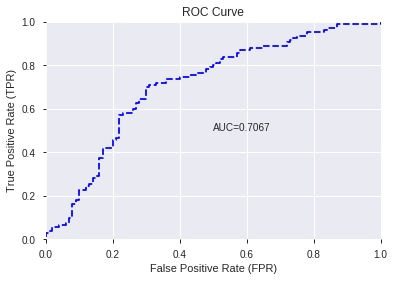

This function is available for GLM models only


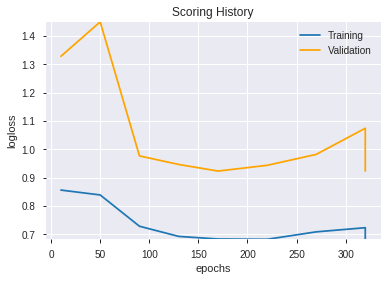

--2019-09-06 01:30:31--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.146.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.146.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190906_012309_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190906_012309_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_9435',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['SUB',
 'NATR_12',
 'CDLSHORTLINE',
 'NATR_8',
 'CDLDOJI',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLMARUBOZU']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190906_013041_model_1  0.687273  0.706921              0.358182  0.481455  0.231799

variable  relative_importance  scaled_importance  percentage
0                 SUB             0.325384           1.000000    0.257197
1         CDLBELTHOLD             0.195208           0.599933    0.154301
2             CDLDOJI             0.180538           0.554848    0.142705
3              NATR_8             0.137593           0.422865    0.108760
4  CDLCLOSINGMARUBOZU             0.128641           0.395350    0.101683
5         CDLLONGLINE             0.111727           0.343370    0.088314
6             NATR_12             0.073243           0.225097    0.057894
7         CDLMARUBOZU             0.064356           0.197784    0.050869
8        CDLSHORTLINE             0.048424           0.148823    0.038277

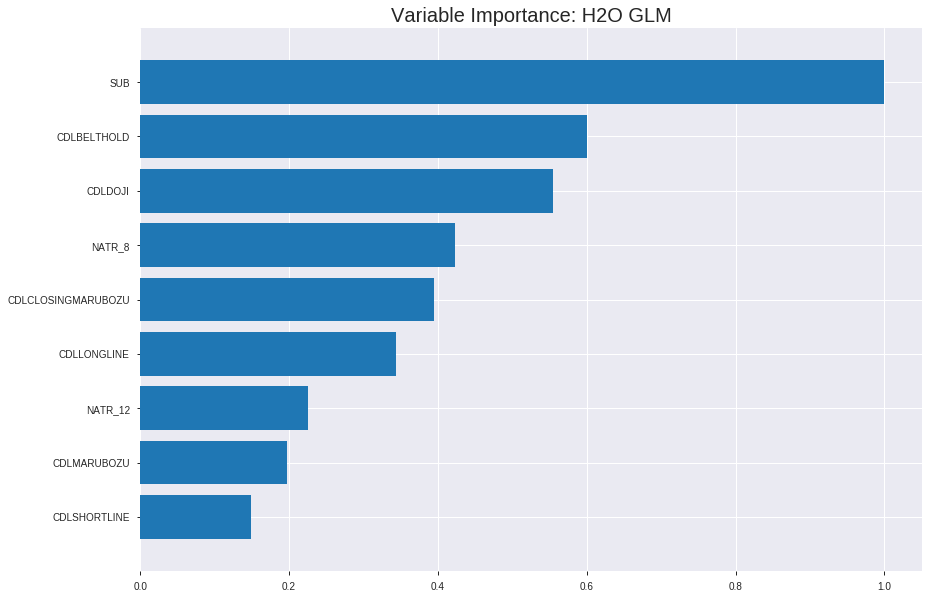

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_013041_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.23027531049447816
RMSE: 0.47987009752065
LogLoss: 0.6523924794443321
Null degrees of freedom: 1465
Residual degrees of freedom: 1456
Null deviance: 2017.3407122714248
Residual deviance: 1912.8147497307816
AIC: 1932.8147497307816
AUC: 0.6461933047894655
pr_auc: 0.6601891027698897
Gini: 0.2923866095789309
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35800537391906107: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      102  557   0.8452   (557.0/659.0)
1      34   773   0.0421   (34.0/807.0)
Total  136  1330  0.4031   (591.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.358005     0.723444  335
max f2                       0.222688     0.861259  393
max f0point5                 0.528934     0.659745  211
max accuracy                 0.495015     0.632333  245
max precision                0.762894     1         0
max recall                   0.222688     1         393
max specificity              0.762894     1         0
max absolute_mcc             0.494097     0.247197  246
max min_per_class_accuracy   0.562944     0.598513  173
max mean_per_class_accuracy  0.528934     0.618068  211

Gains/Lift Table: Avg response rate: 55.05 %, avg score: 55.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102319                   0.735973           1.45328   1.45328            0.8              0.745817  0.8                         0.745817            0.0148699       0.0148699                  45.3284   45.3284
    2        0.0204638                   0.726195           1.08996   1.27162            0.6              0.733033  0.7                         0.739425            0.0111524       0.0260223                  8.99628   27.1623
    3        0.0300136                   0.70742            1.29757   1.27988            0.714286         0.715059  0.704545                    0.731672            0.0123916       0.0384139                  29.7575   27.9881
    4        0.0402456                   0.698241           1.6955    1.38555            0.933333         0.702768  0.762712                    0.724324            0.0173482       0.0557621                  69.5498   38.5546
    5        0.0504775                   0.692656           1.21107   1.35018            0.666667         0.695168  0.743243                    0.718414            0.0123916       0.0681537                  21.107    35.0179
    6        0.100273                    0.682297           1.19448   1.27286            0.657534         0.686421  0.70068                     0.702526            0.0594796       0.127633                   19.448    27.2859
    7        0.150068                    0.672021           1.26913   1.27162            0.69863          0.676876  0.7                         0.694015            0.063197        0.19083                    26.9135   27.1623
    8        0.200546                    0.661005           1.27653   1.27286            0.702703         0.666518  0.70068                     0.687094            0.0644362       0.255266                   27.6533   27.2859
    9        0.300136                    0.636085           1.18204   1.24272            0.650685         0.648918  0.684091                    0.674427            0.11772         0.372986                   18.2037   24.2723
    10       0.400409                    0.605904           1.07513   1.20075            0.591837         0.621747  0.660988                    0.661234            0.107807        0.480793                   7.51334   20.0754
    11       0.5                         0.565008           1.09494   1.17968            0.60274          0.584967  0.649386                    0.646043            0.109046        0.589839                   9.49398   17.9678
    12       0.600273                    0.536723           1.08749   1.16428            0.598639         0.550788  0.640909                    0.630131            0.109046        0.698885                   8.74913   16.4278
    13       0.699864                    0.505572           0.982957  1.13848            0.541096         0.520498  0.626706                    0.614531            0.0978934       0.796778                   -1.70427  13.8476
    14       0.800136                    0.46042            0.827976  1.09956            0.455782         0.484501  0.605286                    0.598235            0.0830235       0.879802                   -17.2024  9.95647
    15       0.899727                    0.362393           0.69678   1.05498            0.383562         0.414545  0.580743                    0.577903            0.0693928       0.949195                   -30.322   5.49804
    16       1                           5.25859e-05        0.506672  1                  0.278912         0.304398  0.550477                    0.550477         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.23830533445693883
RMSE: 0.48816527371059365
LogLoss: 0.6683890783849237
Null degrees of freedom: 418
Residual degrees of freedom: 409
Null deviance: 586.162658197427
Residual deviance: 560.1100476865661
AIC: 580.1100476865661
AUC: 0.6157825175462583
pr_auc: 0.5884966532226549
Gini: 0.2315650350925167
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3098649995289387: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      23   189  0.8915   (189.0/212.0)
1      4    203  0.0193   (4.0/207.0)
Total  27   392  0.4606   (193.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.309865     0.677796  372
max f2                       0.280501     0.838736  386
max f0point5                 0.430918     0.600288  278
max accuracy                 0.492699     0.599045  188
max precision                0.684083     1         0
max recall                   0.280501     1         386
max specificity              0.684083     1         0
max absolute_mcc             0.430918     0.21768   278
max min_per_class_accuracy   0.488172     0.584541  196
max mean_per_class_accuracy  0.430918     0.599136  278

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 48.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119332                   0.666918           1.61932   1.61932            0.8              0.677824  0.8                         0.677824            0.0193237       0.0193237                  61.9324   61.9324
    2        0.0214797                   0.651751           2.02415   1.79925            1                0.655705  0.888889                    0.667993            0.0193237       0.0386473                  102.415   79.9249
    3        0.0310263                   0.643187           0.506039  1.40134            0.25             0.646803  0.692308                    0.661473            0.00483092      0.0434783                  -49.3961  40.1338
    4        0.0405728                   0.641402           1.01208   1.30975            0.5              0.642383  0.647059                    0.656981            0.00966184      0.0531401                  1.20773   30.9747
    5        0.0501193                   0.638816           1.01208   1.25305            0.5              0.640539  0.619048                    0.653849            0.00966184      0.0628019                  1.20773   25.3048
    6        0.100239                    0.60763            1.34944   1.30124            0.666667         0.623467  0.642857                    0.638658            0.0676329       0.130435                   34.9436   30.1242
    7        0.150358                    0.58557            1.15666   1.25305            0.571429         0.594191  0.619048                    0.623836            0.057971        0.188406                   15.666    25.3048
    8        0.200477                    0.570581           1.25305   1.25305            0.619048         0.578394  0.619048                    0.612475            0.0628019       0.251208                   25.3048   25.3048
    9        0.300716                    0.537828           1.01208   1.17272            0.5              0.552077  0.579365                    0.592343            0.101449        0.352657                   1.20773   17.2724
    10       0.400955                    0.51431            1.15666   1.16871            0.571429         0.52623   0.577381                    0.575814            0.115942        0.468599                   15.666    16.8708
    11       0.501193                    0.486869           1.15666   1.1663             0.571429         0.498733  0.57619                     0.560398            0.115942        0.584541                   15.666    16.6299
    12       0.599045                    0.462391           0.938023  1.12901            0.463415         0.477802  0.557769                    0.546906            0.0917874       0.676329                   -6.19771  12.9011
    13       0.699284                    0.433691           1.15666   1.13297            0.571429         0.449999  0.559727                    0.533015            0.115942        0.792271                   15.666    13.2974
    14       0.799523                    0.393655           0.819301  1.09365            0.404762         0.413459  0.540299                    0.518026            0.0821256       0.874396                   -18.0699  9.36477
    15       0.899761                    0.342572           0.722912  1.05235            0.357143         0.371014  0.519894                    0.501648            0.0724638       0.94686                    -27.7088  5.23456
    16       1                           0.0135303          0.530136  1                  0.261905         0.286524  0.494033                    0.480084         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-06 01:30:41  0.000 sec   2            7.7       10            1.36755           1.3933
    2019-09-06 01:30:41  0.005 sec   4            4.8       10            1.36327           1.3904
    2019-09-06 01:30:41  0.009 sec   6            3         10            1.35746           1.3864
    2019-09-06 01:30:41  0.013 sec   8            1.8       10            1.35022           1.38127
    2019-09-06 01:30:41  0.018 sec   10           1.1       10            1.34202           1.37522
    2019-09-06 01:30:41  0.022 sec   12           0.71      10            1.33374           1.36871
    2019-09-06 01:30:41  0.026 sec   14           0.44      10            1.32628           1.36224
    2019-09-06 01:30:41  0.029 sec   16           0.27      10            1.32016           1.35616
    2019-09-06 01:30:41  0.033 sec   18           0.17      10            1.31543           1.35059
    2019-09-06 01:30:41  0.037 sec   20           0.11      10            1.31179           1.34558
    2019-09-06 01:30:41  0.041 sec   22           0.066     10            1.30891           1.34132
    2019-09-06 01:30:41  0.049 sec   24           0.041     10            1.30659           1.33826
    2019-09-06 01:30:41  0.053 sec   26           0.025     10            1.30478           1.33678
    2019-09-06 01:30:41  0.058 sec   28           0.016     10            1.3035            1.3369
    2019-09-06 01:30:41  0.066 sec   30           0.0098    10            1.30268           1.3382
    2019-09-06 01:30:41  0.069 sec   31           0.0061    10            1.30221           1.34001
    2019-09-06 01:30:41  0.072 sec   32           0.0038    10            1.30196           1.3418
    2019-09-06 01:30:41  0.074 sec   33           0.0023    10            1.30184           1.34327

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6619047619047619)

('F1', 0.7224334600760455)

('auc', 0.6872727272727274)

('logloss', 0.7069206436396755)

('mean_per_class_error', 0.34545454545454546)

('rmse', 0.481455427529899)

('mse', 0.23179932869799785)

glm prediction progress: |████████████████████████████████████████████████| 100%


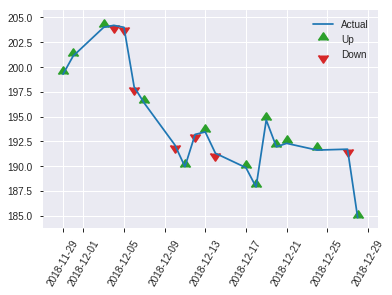


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.23179932869799785
RMSE: 0.481455427529899
LogLoss: 0.7069206436396755
Null degrees of freedom: 209
Residual degrees of freedom: 200
Null deviance: 291.24709670768067
Residual deviance: 296.9066703286651
AIC: 316.9066703286651
AUC: 0.6872727272727274
pr_auc: 0.6540306348773076
Gini: 0.37454545454545474
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3977137151994176: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      42   58   0.58     (58.0/100.0)
1      15   95   0.1364   (15.0/110.0)
Total  57   153  0.3476   (73.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.397714     0.722433  152
max f2                       0.234295     0.852895  198
max f0point5                 0.419439     0.668168  138
max accuracy                 0.419439     0.661905  138
max precision                0.73342      1         0
max recall                   1.45272e-06  1         209
max specificity              0.73342      1         0
max absolute_mcc             0.419439     0.326322  138
max min_per_class_accuracy   0.469544     0.63      106
max mean_per_class_accuracy  0.419439     0.654545  138

Gains/Lift Table: Avg response rate: 52.38 %, avg score: 45.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0142857                   0.718194           1.27273   1.27273            0.666667         0.729454  0.666667                    0.729454            0.0181818       0.0181818                  27.2727   27.2727
    2        0.0238095                   0.670258           0.954545  1.14545            0.5              0.67285   0.6                         0.706812            0.00909091      0.0272727                  -4.54545  14.5455
    3        0.0333333                   0.657023           1.90909   1.36364            1                0.659051  0.714286                    0.693166            0.0181818       0.0454545                  90.9091   36.3636
    4        0.0428571                   0.653579           0.954545  1.27273            0.5              0.655738  0.666667                    0.684849            0.00909091      0.0545455                  -4.54545  27.2727
    5        0.052381                    0.644962           0         1.04132            0                0.648332  0.545455                    0.678209            0               0.0545455                  -100      4.13223
    6        0.1                         0.601999           1.52727   1.27273            0.8              0.626136  0.666667                    0.653412            0.0727273       0.127273                   52.7273   27.2727
    7        0.152381                    0.585245           1.56198   1.37216            0.818182         0.594622  0.71875                     0.633203            0.0818182       0.209091                   56.1983   37.2159
    8        0.2                         0.540889           1.33636   1.36364            0.7              0.568883  0.714286                    0.617889            0.0636364       0.272727                   33.6364   36.3636
    9        0.3                         0.509167           1.27273   1.33333            0.666667         0.523306  0.698413                    0.586361            0.127273        0.4                        27.2727   33.3333
    10       0.4                         0.491244           1.18182   1.29545            0.619048         0.500053  0.678571                    0.564784            0.118182        0.518182                   18.1818   29.5455
    11       0.5                         0.470456           1.09091   1.25455            0.571429         0.479721  0.657143                    0.547772            0.109091        0.627273                   9.09091   25.4545
    12       0.6                         0.440501           1         1.21212            0.52381          0.458053  0.634921                    0.532818            0.1             0.727273                   0         21.2121
    13       0.7                         0.408296           1.09091   1.19481            0.571429         0.423422  0.62585                     0.51719             0.109091        0.836364                   9.09091   19.4805
    14       0.8                         0.363658           0.636364  1.125              0.333333         0.385211  0.589286                    0.500693            0.0636364       0.9                        -36.3636  12.5
    15       0.9                         0.287218           0.727273  1.08081            0.380952         0.320429  0.566138                    0.480664            0.0727273       0.972727                   -27.2727  8.08081
    16       1                           1.45272e-06        0.272727  1                  0.142857         0.208947  0.52381                     0.453492            

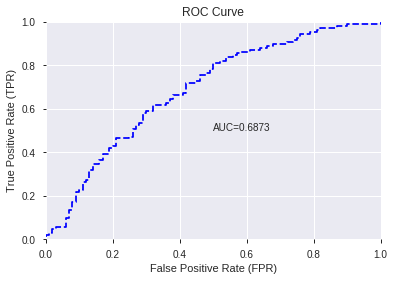

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


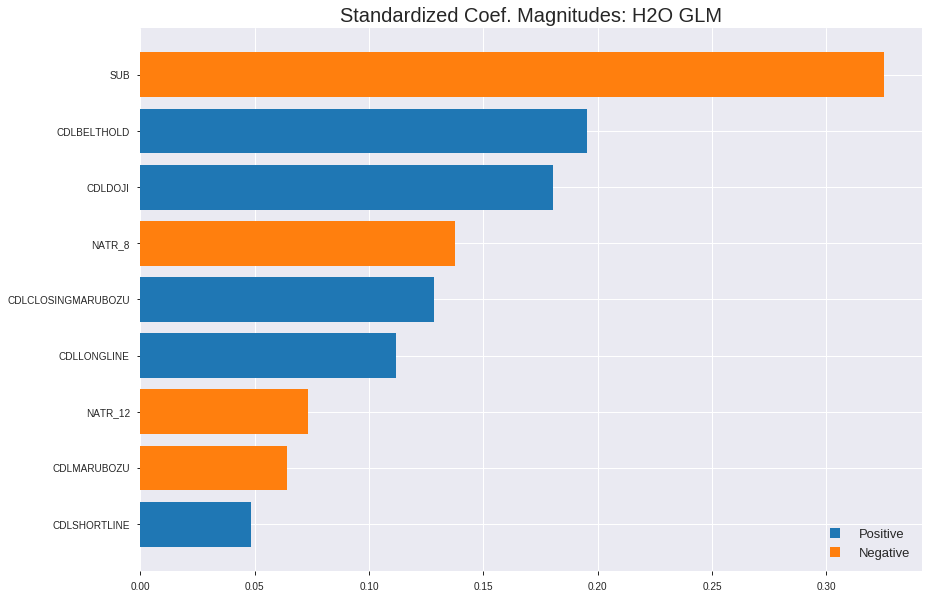

'log_likelihood'
--2019-09-06 01:30:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.104.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.104.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_013041_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_013041_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_9435',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['SUB',
 'CDLBELTHOLD',
 'CDLDOJI',
 'NATR_8',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'NATR_12',
 'CDLMARUBOZU',
 'CDLSHORTLINE']

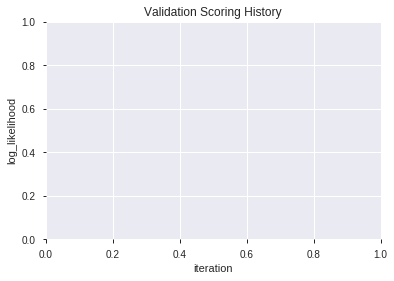

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190906_013054_model_2  0.642636  0.676396              0.392273  0.492080  0.242143
1  XGBoost_grid_1_AutoML_20190906_013054_model_7  0.642545  0.677905              0.402727  0.492273  0.242333
2  XGBoost_grid_1_AutoML_20190906_013054_model_4  0.637227  0.680916              0.404545  0.494336  0.244368
3               XGBoost_1_AutoML_20190906_013054  0.636773  0.677803              0.419545  0.492486  0.242543
4               XGBoost_2_AutoML_20190906_013054  0.634182  0.679239              0.397273  0.493584  0.243625
5  XGBoost_grid_1_AutoML_20190906_013054_model_6  0.633409  0.677143              0.413636  0.492623  0.242677
6               XGBoost_3_AutoML_20190906_013054  0.630500  0.680997              0.378182  0.494204  0.244238
7  XGBoost_grid_1_AutoML_20190906_013054_model_3  0.627182  0.680422              0.398182  0.494025  0.244061
8  XGBoost_grid_1_AutoML_20190906_013054_model_1  0.622636  0.692869              0.394545  0.499086  0.249087
9  XGBoost_grid_1_AutoML_20190906_013054_model_5  0.621818  0.706497              0.409091  0.503916  0.253932

variable  relative_importance  scaled_importance  percentage
0                 SUB           820.013184           1.000000    0.314030
1             NATR_12           633.008667           0.771949    0.242416
2         CDLBELTHOLD           377.767242           0.460684    0.144669
3              NATR_8           355.118622           0.433065    0.135995
4  CDLCLOSINGMARUBOZU           173.908295           0.212080    0.066600
5         CDLLONGLINE           103.281906           0.125952    0.039553
6        CDLSHORTLINE            76.858727           0.093729    0.029434
7             CDLDOJI            50.601254           0.061708    0.019378
8         CDLMARUBOZU            20.695721           0.025238    0.007926

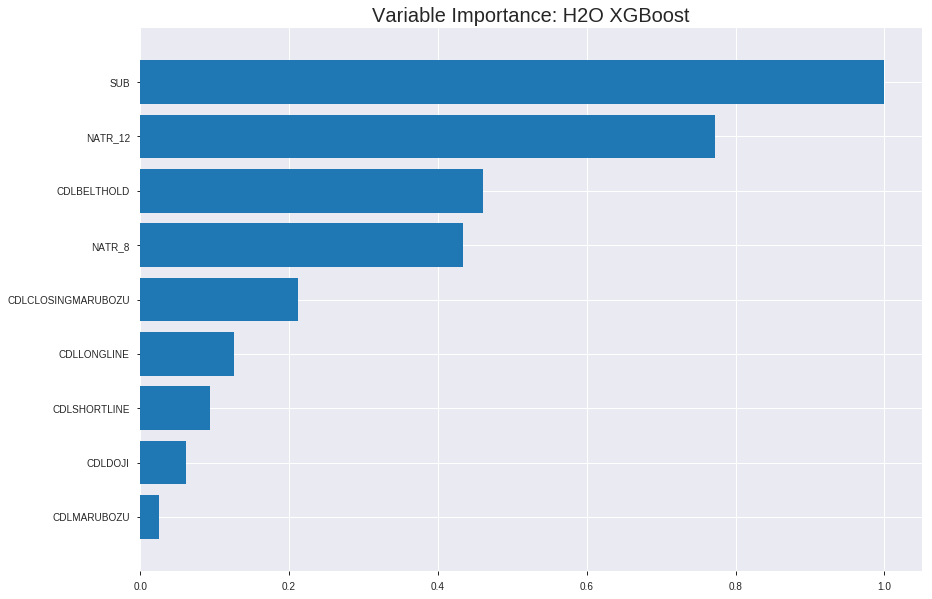

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190906_013054_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.21335038703042775
RMSE: 0.46189867615141283
LogLoss: 0.6172715148229126
Mean Per-Class Error: 0.33035484277368177
AUC: 0.7295186465919412
pr_auc: 0.742687351943802
Gini: 0.4590372931838824
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4178210397561391: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      214  445   0.6753   (445.0/659.0)
1      52   755   0.0644   (52.0/807.0)
Total  266  1200  0.339    (497.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.417821     0.752367  282
max f2                       0.297703     0.866321  364
max f0point5                 0.501271     0.700826  215
max accuracy                 0.480597     0.686903  230
max precision                0.714242     1         0
max recall                   0.267087     1         387
max specificity              0.714242     1         0
max absolute_mcc             0.480597     0.365148  230
max min_per_class_accuracy   0.576708     0.657993  147
max mean_per_class_accuracy  0.501271     0.669645  215

Gains/Lift Table: Avg response rate: 55.05 %, avg score: 54.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102319                   0.707223           1.8166    1.8166             1                0.711039  1                           0.711039            0.0185874       0.0185874                  81.6605   81.6605
    2        0.021146                    0.704638           1.36245   1.5822             0.75             0.70597   0.870968                    0.708422            0.0148699       0.0334572                  36.2454   58.2204
    3        0.0300136                   0.699548           1.39739   1.5276             0.769231         0.702181  0.840909                    0.706578            0.0123916       0.0458488                  39.7388   52.7599
    4        0.0402456                   0.69717            1.45328   1.50871            0.8              0.698758  0.830508                    0.70459             0.0148699       0.0607187                  45.3284   50.8706
    5        0.0511596                   0.68854            1.47599   1.50173            0.8125           0.69358   0.826667                    0.702241            0.016109        0.0768278                  47.5991   50.1727
    6        0.100273                    0.675787           1.53907   1.52002            0.847222         0.680624  0.836735                    0.691653            0.0755886       0.152416                   53.9068   52.0016
    7        0.150068                    0.667788           1.51798   1.51934            0.835616         0.671672  0.836364                    0.685023            0.0755886       0.228005                   51.7985   51.9342
    8        0.200546                    0.658884           1.27653   1.45823            0.702703         0.662784  0.802721                    0.679426            0.0644362       0.292441                   27.6533   45.8227
    9        0.300819                    0.636915           1.23579   1.38408            0.680272         0.648826  0.761905                    0.669226            0.123916        0.416357                   23.5786   38.408
    10       0.400409                    0.606073           1.14471   1.32454            0.630137         0.622299  0.729131                    0.657554            0.114002        0.530359                   14.471    32.4543
    11       0.5                         0.582234           1.10738   1.28129            0.609589         0.593665  0.705321                    0.644829            0.110285        0.640644                   10.7382   28.1289
    12       0.600273                    0.539981           1.01334   1.23653            0.557823         0.561638  0.680682                    0.630932            0.101611        0.742255                   1.33441   23.653
    13       0.699864                    0.478379           1.07005   1.21284            0.589041         0.510271  0.667641                    0.613762            0.106568        0.848823                   7.00548   21.284
    14       0.800136                    0.426891           0.729113  1.15222            0.401361         0.453743  0.634271                    0.593708            0.0731103       0.921933                   -27.0887  15.222
    15       0.899727                    0.357574           0.460372  1.07564            0.253425         0.398419  0.592115                    0.572092            0.0458488       0.967782                   -53.9628  7.56393
    16       1                           0.235291           0.321304  1                  0.176871         0.302349  0.550477                    0.545044            0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2529349177414331
RMSE: 0.5029263541925727
LogLoss: 0.699406303319742
Mean Per-Class Error: 0.4354206544526479
AUC: 0.5556922796463404
pr_auc: 0.5223697987040994
Gini: 0.11138455929268076
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2945292294025421: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      26   186  0.8774   (186.0/212.0)
1      9    198  0.0435   (9.0/207.0)
Total  35   384  0.4654   (195.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.294529     0.670051  350
max f2                       0.254715     0.830658  377
max f0point5                 0.314242     0.57047   329
max accuracy                 0.418054     0.563246  236
max precision                0.62112      0.65      17
max recall                   0.254715     1         377
max specificity              0.68496      0.995283  0
max absolute_mcc             0.294529     0.143046  350
max min_per_class_accuracy   0.436833     0.542453  194
max mean_per_class_accuracy  0.418054     0.564579  236

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 44.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119332                   0.6814             0.404831  0.404831           0.2              0.683165  0.2                         0.683165            0.00483092      0.00483092                 -59.5169  -59.5169
    2        0.0214797                   0.671851           1.01208   0.674718           0.5              0.676656  0.333333                    0.680272            0.00966184      0.0144928                  1.20773   -32.5282
    3        0.0310263                   0.640447           1.51812   0.934225           0.75             0.650255  0.461538                    0.671036            0.0144928       0.0289855                  51.8116   -6.57748
    4        0.0405728                   0.629458           2.02415   1.19068            1                0.637232  0.588235                    0.663082            0.0193237       0.0483092                  102.415   19.0679
    5        0.0501193                   0.619396           1.51812   1.25305            0.75             0.622544  0.619048                    0.655361            0.0144928       0.0628019                  51.8116   25.3048
    6        0.105012                    0.570824           0.968074  1.10408            0.478261         0.594418  0.545455                    0.623504            0.0531401       0.115942                   -3.19261  10.4084
    7        0.152745                    0.553491           0.91087   1.0437             0.45             0.562741  0.515625                    0.604516            0.0434783       0.15942                    -8.91304  4.37047
    8        0.200477                    0.534705           0.708454  0.963883           0.35             0.541014  0.47619                     0.589396            0.0338164       0.193237                   -29.1546  -3.61169
    9        0.300716                    0.490955           1.20485   1.04421            0.595238         0.512134  0.515873                    0.563642            0.120773        0.31401                    20.4854   4.42067
    10       0.403341                    0.461527           1.22391   1.08993            0.604651         0.474304  0.538462                    0.540911            0.125604        0.439614                   22.3907   8.99294
    11       0.501193                    0.436833           1.08613   1.08919            0.536585         0.446398  0.538095                    0.522459            0.10628         0.545894                   8.61317   8.91879
    12       0.599045                    0.420595           1.08613   1.08869            0.536585         0.429097  0.537849                    0.507208            0.10628         0.652174                   8.61317   8.86887
    13       0.699284                    0.400612           0.867495  1.05698            0.428571         0.411209  0.522184                    0.493447            0.0869565       0.73913                    -13.2505  5.69817
    14       0.799523                    0.369838           0.963883  1.04531            0.47619          0.386608  0.516418                    0.480053            0.0966184       0.835749                   -3.61169  4.53097
    15       0.899761                    0.29762            1.01208   1.04161            0.5              0.327405  0.514589                    0.463047            0.101449        0.937198                   1.20773   4.16074
    16       1                           0.235437           0.626524  1                  0.309524         0.280674  0.494033                    0.444766     


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:30:58  0.449 sec   0                  0.5              0.693147            0.5             0                  1                0.449523                         0.5                0.693147              0.5               0                    1                  0.505967
    2019-09-06 01:30:58  0.493 sec   5                  0.490923         0.675131            0.687527        0.546713           1.29517          0.3397                           0.498499           0.690142              0.548309          0.519484             0.899624           0.465394
    2019-09-06 01:30:58  0.536 sec   10                 0.484166         0.661829            0.697773        0.615205           1.40943          0.334925                         0.498024           0.689181              0.553049          0.524328             0.899624           0.484487
    2019-09-06 01:30:58  0.595 sec   15                 0.47916          0.651971            0.700017        0.638816           1.33077          0.333561                         0.497855           0.688821              0.553869          0.518173             1.01208            0.491647
    2019-09-06 01:30:58  0.642 sec   20                 0.475472         0.644663            0.703396        0.669782           1.39144          0.3397                           0.498077           0.689242              0.556729          0.520533             1.01208            0.48926
    2019-09-06 01:30:58  0.693 sec   25                 0.47249          0.638727            0.707756        0.702108           1.57439          0.341746                         0.498307           0.689689              0.558096          0.523806             0.404831           0.458234
    2019-09-06 01:30:58  0.750 sec   30                 0.469786         0.633287            0.711191        0.718886           1.57439          0.339018                         0.498946           0.690999              0.560136          0.524259             0.404831           0.458234
    2019-09-06 01:30:58  0.794 sec   35                 0.467452         0.628605            0.715957        0.725405           1.57439          0.332196                         0.500131           0.693424              0.557492          0.524589             0.674718           0.470167
    2019-09-06 01:30:58  0.848 sec   40                 0.465737         0.625124            0.71958         0.730186           1.62538          0.332196                         0.500666           0.694552              0.558586          0.525485             0.674718           0.460621
    2019-09-06 01:30:58  0.908 sec   45                 0.463799         0.621174            0.723822        0.735885           1.58953          0.3397                           0.502101           0.697598              0.555373          0.521241             0.404831           0.465394
    2019-09-06 01:30:58  0.974 sec   50                 0.461899         0.617272            0.729519        0.742687           1.8166           0.339018                         0.502926           0.699406              0.555692          0.52237              0.404831           0.465394

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
SUB                 820.013                1                    0.31403
NATR_12             633.009                0.771949             0.242416
CDLBELTHOLD         377.767                0.460684             0.144669
NATR_8              355.119                0.433065             0.135995
CDLCLOSINGMARUBOZU  173.908                0.21208              0.0665995
CDLLONGLINE         103.282                0.125952             0.0395526
CDLSHORTLINE        76.8587                0.0937286            0.0294337
CDLDOJI             50.6013                0.0617079            0.0193781
CDLMARUBOZU         20.6957                0.0252383            0.00792559

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6285714285714286)

('F1', 0.7247386759581882)

('auc', 0.6426363636363637)

('logloss', 0.6763958159723285)

('mean_per_class_error', 0.37909090909090903)

('rmse', 0.4920801204608771)

('mse', 0.24214284495279134)

xgboost prediction progress: |████████████████████████████████████████████| 100%


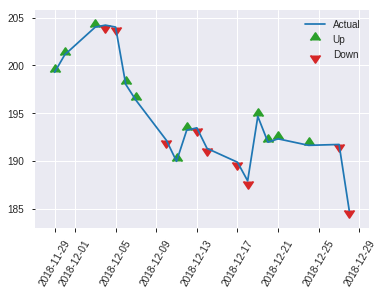


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24214284495279134
RMSE: 0.4920801204608771
LogLoss: 0.6763958159723285
Mean Per-Class Error: 0.37909090909090903
AUC: 0.6426363636363637
pr_auc: 0.6122829456539604
Gini: 0.28527272727272734
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3090972304344177: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      27   73   0.73     (73.0/100.0)
1      6    104  0.0545   (6.0/110.0)
Total  33   177  0.3762   (79.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.309097     0.724739  163
max f2                       0.284526     0.859621  180
max f0point5                 0.407206     0.641791  130
max accuracy                 0.407206     0.628571  130
max precision                0.711705     1         0
max recall                   0.266261     1         191
max specificity              0.711705     1         0
max absolute_mcc             0.309097     0.295671  163
max min_per_class_accuracy   0.435708     0.6       101
max mean_per_class_accuracy  0.407206     0.620909  130

Gains/Lift Table: Avg response rate: 52.38 %, avg score: 43.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0142857                   0.681405           0.636364  0.636364           0.333333         0.692843  0.333333                    0.692843            0.00909091      0.00909091                 -36.3636  -36.3636
    2        0.0238095                   0.657005           0.954545  0.763636           0.5              0.667748  0.4                         0.682805            0.00909091      0.0181818                  -4.54545  -23.6364
    3        0.0333333                   0.639578           0.954545  0.818182           0.5              0.64736   0.428571                    0.672678            0.00909091      0.0272727                  -4.54545  -18.1818
    4        0.0428571                   0.617865           1.90909   1.06061            1                0.620633  0.555556                    0.661112            0.0181818       0.0454545                  90.9091   6.06061
    5        0.052381                    0.607654           1.90909   1.21488            1                0.612935  0.636364                    0.652353            0.0181818       0.0636364                  90.9091   21.4876
    6        0.1                         0.557365           1.33636   1.27273            0.7              0.584322  0.666667                    0.619957            0.0636364       0.127273                   33.6364   27.2727
    7        0.152381                    0.53411            1.04132   1.19318            0.545455         0.545384  0.625                       0.594323            0.0545455       0.181818                   4.13223   19.3182
    8        0.2                         0.513072           1.14545   1.18182            0.6              0.524103  0.619048                    0.577604            0.0545455       0.236364                   14.5455   18.1818
    9        0.3                         0.473434           1.45455   1.27273            0.761905         0.495563  0.666667                    0.550257            0.145455        0.381818                   45.4545   27.2727
    10       0.4                         0.454385           0.909091  1.18182            0.47619          0.461532  0.619048                    0.528076            0.0909091       0.472727                   -9.09091  18.1818
    11       0.5                         0.436218           1.18182   1.18182            0.619048         0.446109  0.619048                    0.511682            0.118182        0.590909                   18.1818   18.1818
    12       0.604762                    0.417677           0.867769  1.12742            0.454545         0.426012  0.590551                    0.496842            0.0909091       0.681818                   -13.2231  12.7416
    13       0.7                         0.399938           1.24091   1.14286            0.65             0.409598  0.598639                    0.484972            0.118182        0.8                        24.0909   14.2857
    14       0.8                         0.375041           1         1.125              0.52381          0.388224  0.589286                    0.472878            0.1             0.9                        0         12.5
    15       0.9                         0.287642           0.818182  1.09091            0.428571         0.313466  0.571429                    0.455166            0.0818182       0.981818                   -18.1818  9.09091
    16       1                           0.24739            0.181818  1                  0.0952381        0.275443  0.52381                     0.437194         

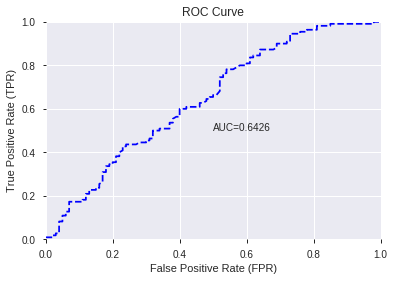

This function is available for GLM models only


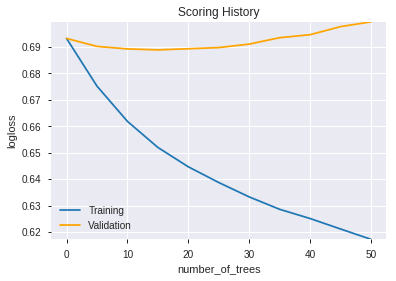

--2019-09-06 01:31:07--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.230.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.230.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190906_013054_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190906_013054_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_9435',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['SUB',
 'NATR_12',
 'CDLBELTHOLD',
 'NATR_8',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'CDLSHORTLINE',
 'CDLDOJI',
 'CDLMARUBOZU']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

826

['BBANDS_upperband_8_5_2',
 'BBANDS_middleband_8_5_2',
 'BBANDS_lowerband_8_5_2',
 'BBANDS_upperband_8_5_3',
 'BBANDS_middleband_8_5_3',
 'BBANDS_lowerband_8_5_3',
 'BBANDS_upperband_8_5_4',
 'BBANDS_middleband_8_5_4',
 'BBANDS_lowerband_8_5_4',
 'BBANDS_upperband_8_5_5',
 'BBANDS_middleband_8_5_5',
 'BBANDS_lowerband_8_5_5',
 'MA_8_6',
 'MAVP_8_6',
 'T3_8_6',
 'BBANDS_upperband_8_6_2',
 'BBANDS_middleband_8_6_2',
 'BBANDS_lowerband_8_6_2',
 'BBANDS_upperband_8_6_3',
 'BBANDS_middleband_8_6_3',
 'BBANDS_lowerband_8_6_3',
 'BBANDS_upperband_8_6_4',
 'BBANDS_middleband_8_6_4',
 'BBANDS_lowerband_8_6_4',
 'BBANDS_upperband_8_6_5',
 'BBANDS_middleband_8_6_5',
 'BBANDS_lowerband_8_6_5',
 'MA_8_7',
 'MAVP_8_7',
 'T3_8_7',
 'BBANDS_upperband_8_7_2',
 'BBANDS_middleband_8_7_2',
 'BBANDS_lowerband_8_7_2',
 'BBANDS_upperband_8_7_3',
 'BBANDS_middleband_8_7_3',
 'BBANDS_lowerband_8_7_3',
 'BBANDS_upperband_8_7_4',
 'BBANDS_middleband_8_7_4',
 'BBANDS_lowerband_8_7_4',
 'BBANDS_upperband_8_7_5',
 

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190906_013207_model_6  0.516318  17.697804                   0.5  0.722077  0.521395
1  DeepLearning_grid_1_AutoML_20190906_013207_model_2  0.504545  18.091740                   0.5  0.723747  0.523810
2               DeepLearning_1_AutoML_20190906_013207  0.504545  18.091740                   0.5  0.723747  0.523810
3  DeepLearning_grid_1_AutoML_20190906_013207_model_5  0.500000   0.694026                   0.5  0.500431  0.250431
4  DeepLearning_grid_1_AutoML_20190906_013207_model_8  0.500000   0.693858                   0.5  0.500355  0.250355
5  DeepLearning_grid_1_AutoML_20190906_013207_model_9  0.500000   0.692343                   0.5  0.499597  0.249597
6  DeepLearning_grid_1_AutoML_20190906_013207_model_1  0.500000  16.447036                   0.5  0.690066  0.476190
7  DeepLearning_grid_1_AutoML_20190906_013207_model_4  0.500000  16.447036                   0.5  0.690066  0.476190
8  DeepLearning_grid_1_AutoML_20190906_013207_model_3  0.499091  18.078221                   0.5  0.723747  0.523810
9  DeepLearning_grid_1_AutoML_20190906_013207_model_7  0.498682  18.035863                   0.5  0.723747  0.523810

variable  relative_importance  scaled_importance  percentage
0               CDLDOJI             1.000000           1.000000    0.002550
1                   SUB             0.988938           0.988938    0.002522
2          CDLSHORTLINE             0.704935           0.704935    0.001797
3                   DIV             0.683162           0.683162    0.001742
4                TRANGE             0.679884           0.679884    0.001734
..                  ...                  ...                ...         ...
819                 TAN             0.421343           0.421343    0.001074
820         CDL3OUTSIDE             0.421134           0.421134    0.001074
821        CDLTASUKIGAP             0.409252           0.409252    0.001043
822         CDLDOJISTAR             0.397249           0.397249    0.001013
823  CDLKICKINGBYLENGTH             0.385192           0.385192    0.000982

[824 rows x 4 columns]

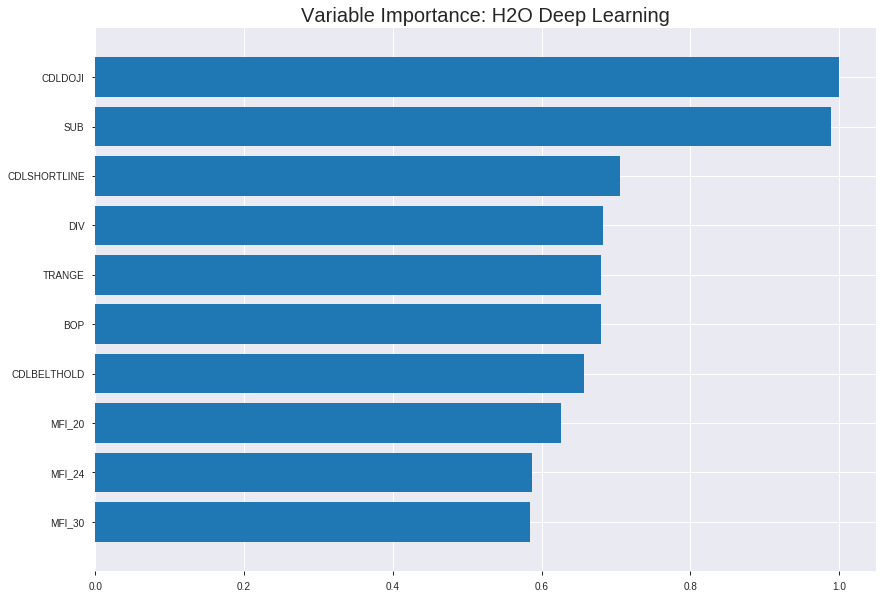

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190906_013207_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24159424241890967
RMSE: 0.4915223722465842
LogLoss: 0.675139591056188
Mean Per-Class Error: 0.4436192797092211
AUC: 0.5682081859601026
pr_auc: 0.6122855981625758
Gini: 0.13641637192020517
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32928089781025216: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      31   628   0.953    (628.0/659.0)
1      3    804   0.0037   (3.0/807.0)
Total  34   1432  0.4304   (631.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.329281     0.718178  367
max f2                       0.318737     0.863178  370
max f0point5                 0.570966     0.625102  286
max accuracy                 0.570966     0.587312  286
max precision                0.878921     1         0
max recall                   0.165143     1         390
max specificity              0.878921     1         0
max absolute_mcc             0.570576     0.161893  287
max min_per_class_accuracy   0.584789     0.537794  216
max mean_per_class_accuracy  0.594078     0.556381  181

Gains/Lift Table: Avg response rate: 55.05 %, avg score: 58.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102319                   0.648223           1.6955    1.6955             0.933333         0.718763  0.933333                    0.718763            0.0173482       0.0173482                  69.5498    69.5498
    2        0.0204638                   0.631188           1.33218   1.51384            0.733333         0.634882  0.833333                    0.676822            0.0136307       0.0309789                  33.2177    51.3837
    3        0.0300136                   0.629273           1.29757   1.44503            0.714286         0.630505  0.795455                    0.662085            0.0123916       0.0433705                  29.7575    44.5026
    4        0.0402456                   0.625968           0.847749  1.29318            0.466667         0.62754   0.711864                    0.653303            0.0086741       0.0520446                  -15.2251   29.3176
    5        0.0504775                   0.623843           0.847749  1.20289            0.466667         0.62491   0.662162                    0.647547            0.0086741       0.0607187                  -15.2251   20.2887
    6        0.100273                    0.618072           1.11982   1.16164            0.616438         0.621059  0.639456                    0.634393            0.0557621       0.116481                   11.9825    16.1638
    7        0.150068                    0.612637           0.970515  1.09822            0.534247         0.615528  0.604545                    0.628133            0.0483271       0.164808                   -2.94852   9.82201
    8        0.200546                    0.607934           1.15379   1.11221            0.635135         0.610043  0.612245                    0.62358             0.0582404       0.223048                   15.3789    11.2207
    9        0.300136                    0.601312           1.14471   1.12299            0.630137         0.6044    0.618182                    0.617216            0.114002        0.337051                   14.471     12.2992
    10       0.400409                    0.595022           1.07513   1.11101            0.591837         0.598196  0.611584                    0.612453            0.107807        0.444857                   7.51334    11.1007
    11       0.5                         0.584923           0.89586   1.06815            0.493151         0.59104   0.587995                    0.608188            0.0892193       0.534077                   -10.414    6.81537
    12       0.600273                    0.582311           1.00099   1.05693            0.55102          0.583242  0.581818                    0.604021            0.100372        0.634449                   0.0986268  5.69336
    13       0.699864                    0.581074           1.04517   1.05526            0.575342         0.581666  0.580897                    0.60084             0.104089        0.738538                   4.51698    5.52597
    14       0.800136                    0.580025           0.951555  1.04226            0.52381          0.580534  0.573743                    0.598295            0.0954151       0.833953                   -4.84452   4.22634
    15       0.899727                    0.576719           1.05761   1.04396            0.582192         0.578887  0.574678                    0.596147            0.105328        0.939281                   5.76123    4.39624
    16       1                           0.0251594          0.605535  1                  0.333333         0.438128  0.550477                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.30510463407999894
RMSE: 0.5523627739810123
LogLoss: 3.766793872769413
Mean Per-Class Error: 0.44601677148846963
AUC: 0.5372801020873211
pr_auc: 0.5004636614014488
Gini: 0.07456020417464226
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.9089973022398336e-48: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    212  1        (212.0/212.0)
1      0    207  0        (0.0/207.0)
Total  0    419  0.506    (212.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.909e-48    0.661342  276
max f2                       2.909e-48    0.829992  276
max f0point5                 0.0348107    0.567301  212
max accuracy                 0.0348107    0.551313  212
max precision                0.577577     0.538462  179
max recall                   2.909e-48    1         276
max specificity              0.5874       0.995283  0
max absolute_mcc             0.0348107    0.12064   212
max min_per_class_accuracy   0.577577     0.47343   179
max mean_per_class_accuracy  0.0348107    0.553983  212

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 40.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119332                   0.586518           0.404831  0.404831           0.2              0.586762      0.2                         0.586762            0.00483092      0.00483092                 -59.5169  -59.5169
    2        0.0214797                   0.586297           1.51812   0.899624           0.75             0.586415      0.444444                    0.586608            0.0144928       0.0193237                  51.8116   -10.0376
    3        0.0310263                   0.585983           0.506039  0.778521           0.25             0.586121      0.384615                    0.586458            0.00483092      0.0241546                  -49.3961  -22.1479
    4        0.0405728                   0.585916           1.51812   0.952543           0.75             0.585946      0.470588                    0.586338            0.0144928       0.0386473                  51.8116   -4.74567
    5        0.0501193                   0.585854           0         0.771107           0                0.585896      0.380952                    0.586254            0               0.0386473                  -100      -22.8893
    6        0.100239                    0.585508           0.963883  0.867495           0.47619          0.585683      0.428571                    0.585968            0.0483092       0.0869565                  -3.61169  -13.2505
    7        0.150358                    0.58516            0.963883  0.899624           0.47619          0.58536       0.444444                    0.585765            0.0483092       0.135266                   -3.61169  -10.0376
    8        0.200477                    0.584902           1.34944   1.01208            0.666667         0.585035      0.5                         0.585583            0.0676329       0.202899                   34.9436   1.20773
    9        0.300716                    0.584213           1.10847   1.04421            0.547619         0.584521      0.515873                    0.585229            0.111111        0.31401                    10.8466   4.42067
    10       0.400955                    0.582746           1.10847   1.06027            0.547619         0.58367       0.52381                     0.584839            0.111111        0.425121                   10.8466   6.02715
    11       0.656325                    0.576764           1.02154   1.0452             0.504673         0.577337      0.516364                    0.58192             0.26087         0.68599                    2.1536    4.51998
    12       0.699284                    0.14645            1.23698   1.05698            0.611111         0.393927      0.522184                    0.570371            0.0531401       0.73913                    23.6983   5.69817
    13       0.799523                    7.81687e-13        0.963883  1.04531            0.47619          0.0188935     0.516418                    0.501231            0.0966184       0.835749                   -3.61169  4.53097
    14       0.899761                    6.13435e-94        0.867495  1.0255             0.428571         2.89292e-15   0.506631                    0.445391            0.0869565       0.922705                   -13.2505  2.55001
    15       1                           0                  0.771107  1                  0.380952         5.14927e-139  0.494033                    0.400745            0.0772947       1                          -22.8893  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:41:20  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 01:41:22  5 min 19.824 sec  398 obs/sec       0.55457   1             813        0.597499         2.24797             -0.442724      0.527346        0.451922           1.08996          0.444748                         0.62127            7.13418               -0.544125        0.549471          0.545816             1.61932            0.505967
    2019-09-06 01:41:43  5 min 41.081 sec  538 obs/sec       7.81992   14            11464      0.498887         0.690559            -0.00580213    0.550332        0.591007           1.21107          0.433151                         0.606428           6.5636                -0.471231        0.462059          0.351827             0.846465           0.50358
    2019-09-06 01:42:04  6 min  1.944 sec  586 obs/sec       16.0607   29            23545      0.493057         0.678791            0.0175648      0.557315        0.606746           1.57439          0.429059                         0.5538             3.8255                -0.226954        0.548594          0.519199             0.809662           0.505967
    2019-09-06 01:42:25  6 min 23.025 sec  615 obs/sec       24.852    45            36433      0.491522         0.67514             0.0236724      0.568208        0.612286           1.6955           0.430423                         0.552363           3.76679               -0.220592        0.53728           0.500464             0.404831           0.505967
    2019-09-06 01:42:46  6 min 43.479 sec  636 obs/sec       33.7244   61            49440      0.492178         0.675993            0.021067       0.564655        0.596193           1.57439          0.422237                         0.588033           4.24791               -0.38333         0.441813          0.395433             0.793786           0.505967
    2019-09-06 01:43:06  7 min  3.879 sec  650 obs/sec       42.5989   77            62450      0.490119         0.672081            0.0292389      0.588052        0.616921           1.8166           0.404502                         0.578318           4.13656               -0.337997        0.557276          0.554432             1.21449            0.505967
    2019-09-06 01:43:27  7 min 24.779 sec  656 obs/sec       51.4516   93            75428      0.490313         0.671938            0.0284715      0.577032        0.614883           1.8166           0.412005                         0.619805           6.24045               -0.536852        0.466981          0.370599             0.821687           0.498807
    2019-09-06 01:43:48  7 min 46.194 sec  664 obs/sec       60.852    110           89209      0.479216         0.648881            0.0719503      0.661938        0.709331           1.8166           0.395634                         0.599277           5.84373               -0.436738        0.495329          0.384259             0.834703           0.505967
    2019-09-06 01:43:50 

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ---------------------
CDLDOJI             1.0                    1.0                  0.0025497040142158285
SUB                 0.9889383316040039     0.9889383316040039   0.0025215000339026327
CDLSHORTLINE        0.7049351334571838     0.7049351334571838   0.0017973759395375525
DIV                 0.6831616163253784     0.6831616163253784   0.001741859915502991
TRANGE              0.679883599281311      0.679883599281311    0.0017335019422870645
---                 ---                    ---                  ---
TAN                 0.4213426113128662     0.4213426113128662   0.0010742989474245945
CDL3OUTSIDE         0.4211341440677643     0.4211341440677643   0.0010737674176529257
CDLTASUKIGAP        0.40925222635269165    0.40925222635269165  0.0010434720443582228
CDLDOJISTAR         0.39724916219711304    0.39724916219711304  0.0010128677834978538
CDLKICKINGBYLENGTH  0.3851921856403351     0.3851921856403351   0.000982126061971731


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5238095238095238)

('F1', 0.6875000000000001)

('auc', 0.5163181818181818)

('logloss', 17.697804486698164)

('mean_per_class_error', 0.48318181818181816)

('rmse', 0.7220769804315477)

('mse', 0.5213951656691417)

deeplearning prediction progress: |███████████████████████████████████████| 100%


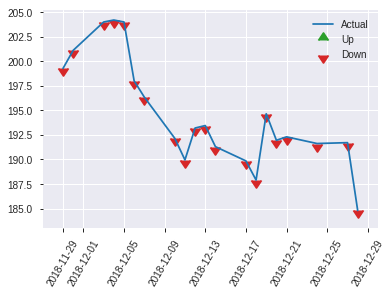


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5213951656691417
RMSE: 0.7220769804315477
LogLoss: 17.697804486698164
Mean Per-Class Error: 0.48318181818181816
AUC: 0.5163181818181818
pr_auc: 0.6041450216450217
Gini: 0.032636363636363575
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.7850260658380735e-50: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    100  1        (100.0/100.0)
1      0    110  0        (0.0/110.0)
Total  0    210  0.4762   (100.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       2.78503e-50  0.6875     10
max f2                       2.78503e-50  0.846154   10
max f0point5                 2.78503e-50  0.578947   10
max accuracy                 2.78503e-50  0.52381    10
max precision                0.302685     1          0
max recall                   2.78503e-50  1          10
max specificity              0.302685     1          0
max absolute_mcc             2.10246e-43  0.0788843  9
max min_per_class_accuracy   2.10246e-43  0.0636364  9
max mean_per_class_accuracy  2.10246e-43  0.516818   9

Gains/Lift Table: Avg response rate: 52.38 %, avg score:  0.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0142857                   0.0504389          0.636364  0.636364           0.333333         0.140916     0.333333                    0.140916            0.00909091      0.00909091                 -36.3636  -36.3636
    2        0.0238095                   1.21846e-05        1.90909   1.14545            1                0.000128399  0.6                         0.084601            0.0181818       0.0272727                  90.9091   14.5455
    3        0.0333333                   5.44772e-21        0.954545  1.09091            0.5              4.27337e-06  0.571429                    0.0604305           0.00909091      0.0363636                  -4.54545  9.09091
    4        0.0428571                   1.28215e-34        1.90909   1.27273            1                1.61846e-24  0.666667                    0.0470015           0.0181818       0.0545455                  90.9091   27.2727
    5        0.052381                    3.06353e-48        1.90909   1.38843            1                1.05126e-43  0.727273                    0.0384558           0.0181818       0.0727273                  90.9091   38.843
    6        1                           0                  0.978529  1                  0.512563         7.8281e-90   0.52381                     0.00201435          0.927273        1                          -2.1471   0

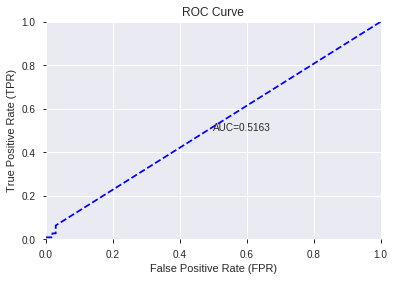

This function is available for GLM models only


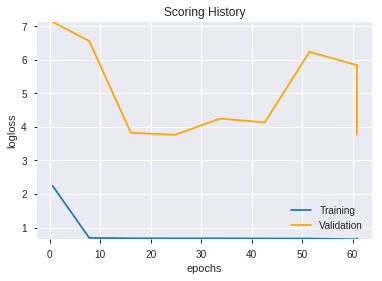

--2019-09-06 01:55:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.204.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.204.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190906_013207_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190906_013207_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_9435',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLDOJI',
 'SUB',
 'CDLSHORTLINE',
 'DIV',
 'TRANGE',
 'BOP',
 'CDLBELTHOLD',
 'MFI_20',
 'MFI_24',
 'MFI_30',
 'aroondown_8',
 'CDLCLOSINGMARUBOZU',
 'SIN',
 'AD',
 'NATR_8',
 'NATR_12',
 'CDLMARUBOZU',
 'NATR_30',
 'HT_PHASOR_quadrature',
 'ADX_20',
 'STOCHF_fastk',
 'MFI_8',
 'CORREL_8',
 'aroondown_12',
 'WILLR_8',
 'DX_30',
 'CDLLONGLINE',
 'MFI_12',
 'STOCHRSI_fastk',
 'VAR_12',
 'HT_DCPERIOD',
 'NATR_20',
 'MACDFIX_signal_24',
 'OBV',
 'MFI_14',
 'MOM_30',
 'DX_24',
 'ROCP_30',
 'PLUS_DM_8',
 'COS',
 'ROCR_30',
 'STOCH_slowk',
 'DX_14',
 'DX_8',
 'MACDFIX_signal_20',
 'MACDFIX_signal_14',
 'HT_PHASOR_inphase',
 'aroondown_30',
 'MACDEXT_signal',
 'ROC_30',
 'PLUS_DM_12',
 'ADX_14',
 'aroonup_30',
 'ROCR100_30',
 'ADXR_12',
 'CDLTAKURI',
 'DX_20',
 'DX_12',
 'aroonup_8',
 'aroondown_24',
 'ADX_12',
 'VAR_14',
 'ADX_24',
 'PLUS_DM_14',
 'AROONOSC_30',
 'HT_TRENDMODE',
 'STOCHF_fastd',
 'ADXR_14',
 'VAR_24',
 'PLUS_DI_30',
 'WILLR_12',
 'ADXR_8',
 'aroondown_14',
 'ULTOSC',
 'ROC

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190906_015610_model_1  0.499091  18.064018                   0.5  0.723747  0.52381

variable  relative_importance  scaled_importance  percentage
0                     CDLDOJI             0.009041           1.000000    0.019914
1                 CDLBELTHOLD             0.008889           0.983189    0.019579
2                 CDLLONGLINE             0.008469           0.936749    0.018654
3          CDLCLOSINGMARUBOZU             0.008160           0.902532    0.017973
4                 CDLMARUBOZU             0.007567           0.837019    0.016668
..                        ...                  ...                ...         ...
819                   DEMA_20             0.000000           0.000000    0.000000
820   BBANDS_lowerband_20_1_2             0.000000           0.000000    0.000000
821  BBANDS_middleband_20_3_5             0.000000           0.000000    0.000000
822                   MA_24_3             0.000000           0.000000    0.000000
823  BBANDS_middleband_24_3_5             0.000000           0.000000    0.000000

[824 rows x 4 columns]

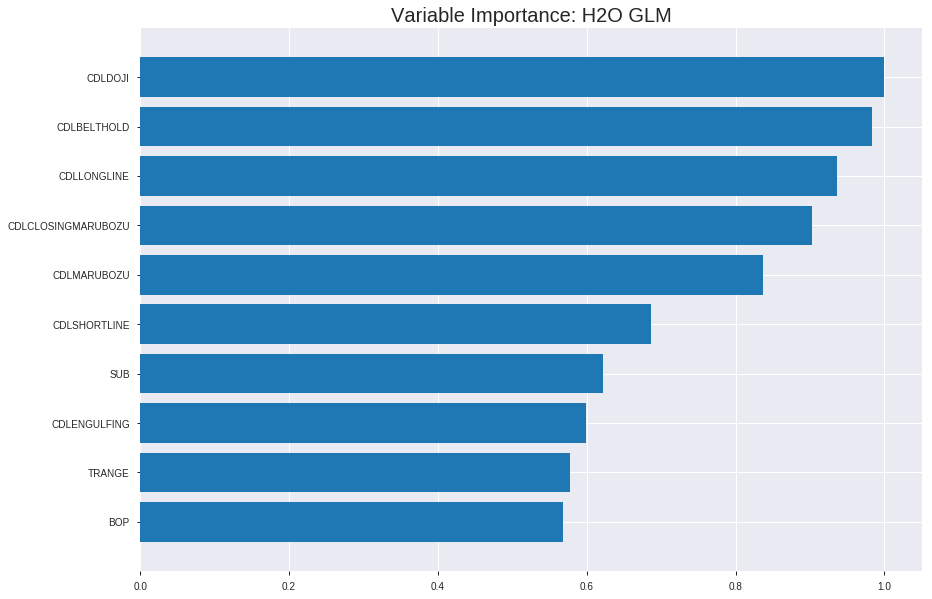

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_015610_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.242441220427982
RMSE: 0.4923832048597738
LogLoss: 0.6779138014272686
Null degrees of freedom: 1465
Residual degrees of freedom: 646
Null deviance: 2017.3407122714248
Residual deviance: 1987.6432657847513
AIC: 3627.6432657847513
AUC: 0.6529729434970564
pr_auc: 0.6911430237094334
Gini: 0.30594588699411274
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5196281142907053: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      83   576   0.8741   (576.0/659.0)
1      26   781   0.0322   (26.0/807.0)
Total  109  1357  0.4106   (602.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.519628     0.721811  326
max f2                       0.448766     0.861076  391
max f0point5                 0.558046     0.652174  146
max accuracy                 0.558046     0.611187  146
max precision                0.607005     1         0
max recall                   0.448766     1         391
max specificity              0.607005     1         0
max absolute_mcc             0.558046     0.244201  146
max min_per_class_accuracy   0.554438     0.60347   168
max mean_per_class_accuracy  0.558046     0.620959  146

Gains/Lift Table: Avg response rate: 55.05 %, avg score: 55.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102319                   0.586912           1.6955    1.6955             0.933333         0.592814  0.933333                    0.592814            0.0173482       0.0173482                  69.5498   69.5498
    2        0.0204638                   0.583794           1.45328   1.57439            0.8              0.585314  0.866667                    0.589064            0.0148699       0.0322181                  45.3284   57.4391
    3        0.0300136                   0.579387           1.42733   1.5276             0.785714         0.581391  0.840909                    0.586622            0.0136307       0.0458488                  42.7332   52.7599
    4        0.0402456                   0.577489           1.21107   1.44713            0.666667         0.578365  0.79661                     0.584523            0.0123916       0.0582404                  21.107    44.7126
    5        0.0504775                   0.576596           0.847749  1.32563            0.466667         0.577087  0.72973                     0.583016            0.0086741       0.0669145                  -15.2251  32.563
    6        0.100273                    0.572301           1.54287   1.43351            0.849315         0.5743    0.789116                    0.578688            0.0768278       0.143742                   54.287    43.3511
    7        0.150068                    0.568975           1.3189    1.39548            0.726027         0.570518  0.768182                    0.575977            0.0656753       0.209418                   31.8905   39.5483
    8        0.200546                    0.566516           1.20289   1.34701            0.662162         0.567667  0.741497                    0.573885            0.0607187       0.270136                   20.2887   34.7006
    9        0.300136                    0.562351           1.21936   1.30465            0.671233         0.564363  0.718182                    0.570726            0.121437        0.391574                   21.9365   30.4652
    10       0.400409                    0.558662           1.13692   1.26265            0.62585          0.560526  0.69506                     0.568171            0.114002        0.505576                   13.6923   26.2649
    11       0.5                         0.554647           0.883417  1.18711            0.486301         0.556669  0.653479                    0.56588             0.0879802       0.593556                   -11.6583  18.7113
    12       0.600273                    0.550207           0.926839  1.14364            0.510204         0.55247   0.629545                    0.56364             0.0929368       0.686493                   -7.31609  14.3635
    13       0.699864                    0.544788           0.94563   1.11546            0.520548         0.54781   0.614035                    0.561388            0.094176        0.780669                   -5.43702  11.5459
    14       0.800136                    0.53733            0.827976  1.07943            0.455782         0.541272  0.594203                    0.558867            0.0830235       0.863693                   -17.2024  7.94318
    15       0.899727                    0.525159           0.833647  1.05223            0.458904         0.531659  0.579227                    0.555855            0.0830235       0.946716                   -16.6353  5.22259
    16       1                           0.352713           0.531388  1                  0.292517         0.502226  0.550477                    0.550477          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.3460418823637506
RMSE: 0.5882532467940578
LogLoss: 5.779112986602032
Null degrees of freedom: 418
Residual degrees of freedom: -401
Null deviance: 586.162658197427
Residual deviance: 49965.968762770644
AIC: 51605.968762770644
AUC: 0.5584495488105005
pr_auc: 0.5489484075095633
Gini: 0.11689909762100092
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.2765924491597587e-48: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    212  1        (212.0/212.0)
1      0    207  0        (0.0/207.0)
Total  0    419  0.506    (212.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.27659e-48  0.661342  316
max f2                       2.27659e-48  0.829992  316
max f0point5                 1.33625e-22  0.565706  303
max accuracy                 0.554115     0.556086  82
max precision                0.587435     1         0
max recall                   2.27659e-48  1         316
max specificity              0.587435     1         0
max absolute_mcc             0.560183     0.141617  45
max min_per_class_accuracy   0.448819     0.523585  209
max mean_per_class_accuracy  0.550921     0.552832  94

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 29.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119332                   0.57483            1.21449   1.21449            0.6              0.580085      0.6                         0.580085            0.0144928       0.0144928                  21.4493   21.4493
    2        0.0214797                   0.573651           0.506039  0.899624           0.25             0.57409       0.444444                    0.57742             0.00483092      0.0193237                  -49.3961  -10.0376
    3        0.0310263                   0.572171           1.51812   1.08993            0.75             0.572598      0.538462                    0.575937            0.0144928       0.0338164                  51.8116   8.99294
    4        0.0405728                   0.569187           1.51812   1.19068            0.75             0.570679      0.588235                    0.5747              0.0144928       0.0483092                  51.8116   19.0679
    5        0.0501193                   0.567343           1.51812   1.25305            0.75             0.568608      0.619048                    0.573539            0.0144928       0.0628019                  51.8116   25.3048
    6        0.100239                    0.560832           1.54221   1.39763            0.761905         0.563495      0.690476                    0.568517            0.0772947       0.140097                   54.2213   39.7631
    7        0.150358                    0.557366           1.15666   1.31731            0.571429         0.559282      0.650794                    0.565439            0.057971        0.198068                   15.666    31.7307
    8        0.200477                    0.553201           1.06027   1.25305            0.52381          0.555625      0.619048                    0.562985            0.0531401       0.251208                   6.02715   25.3048
    9        0.300716                    0.544153           0.915689  1.1406             0.452381         0.548922      0.563492                    0.558297            0.0917874       0.342995                   -8.4311   14.0595
    10       0.400955                    0.526645           0.963883  1.09642            0.47619          0.536065      0.541667                    0.552739            0.0966184       0.439614                   -3.61169  9.64171
    11       0.501193                    0.448819           0.867495  1.05063            0.428571         0.499684      0.519048                    0.542128            0.0869565       0.52657                    -13.2505  5.06326
    12       0.599045                    0.00693348         1.03676   1.04837            0.512195         0.201378      0.517928                    0.486468            0.101449        0.628019                   3.67621   4.83669
    13       0.699284                    5.1475e-15         1.10847   1.05698            0.547619         0.000924338   0.522184                    0.416868            0.111111        0.73913                    10.8466   5.69817
    14       0.799523                    5.98447e-126       0.963883  1.04531            0.47619          3.18399e-18   0.516418                    0.364604            0.0966184       0.835749                   -3.61169  4.53097
    15       1                           0                  0.819301  1                  0.404762         2.07169e-139  0.494033                    0.291509            0.164251        1                          -18.0699  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-06 01:56:12  0.000 sec   2            7.7       820           1.35583           119.251
    2019-09-06 01:56:13  1.075 sec   4            5.6       825           1.35034           127.345
    2019-09-06 01:56:14  2.192 sec   6            4.1       825           1.34372           135.646
    2019-09-06 01:56:15  3.303 sec   8            3         825           1.33592           143.961
    2019-09-06 01:56:16  4.385 sec   10           2.2       825           1.32693           150.693

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5238095238095238)

('F1', 0.6875000000000001)

('auc', 0.4990909090909091)

('logloss', 18.06401816581209)

('mean_per_class_error', 0.4954545454545455)

('rmse', 0.7237468644557437)

('mse', 0.5238095238095206)

glm prediction progress: |████████████████████████████████████████████████| 100%


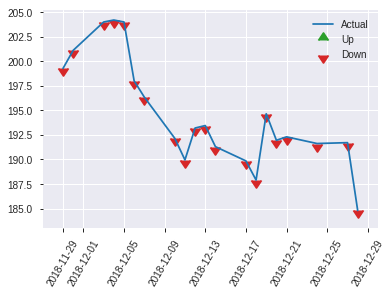


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5238095238095206
RMSE: 0.7237468644557437
LogLoss: 18.06401816581209
Null degrees of freedom: 209
Residual degrees of freedom: -610
Null deviance: 291.24709670768067
Residual deviance: 151332.75916280426
AIC: 152972.75916280426
AUC: 0.4990909090909091
pr_auc: 0.5063852813852814
Gini: -0.0018181818181818299
Confusion Matrix (Act/Pred) for max f1 @ threshold = 3.652933846587517e-59: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    100  1        (100.0/100.0)
1      0    110  0        (0.0/110.0)
Total  0    210  0.4762   (100.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       3.65293e-59  0.6875     4
max f2                       3.65293e-59  0.846154   4
max f0point5                 3.65293e-59  0.578947   4
max accuracy                 3.65293e-59  0.52381    4
max precision                3.37509e-13  1          0
max recall                   3.65293e-59  1          4
max specificity              3.37509e-13  1          0
max absolute_mcc             3.37509e-13  0.0659524  0
max min_per_class_accuracy   1.9798e-44   0.0181818  3
max mean_per_class_accuracy  3.37509e-13  0.504545   0

Gains/Lift Table: Avg response rate: 52.38 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0142857                   2.16462e-21        0.636364  0.636364           0.333333         1.12503e-13   0.333333                    1.12503e-13         0.00909091      0.00909091                 -36.3636  -36.3636
    2        0.0238095                   6.07937e-57        1.90909   1.14545            1                9.89898e-45   0.6                         6.75018e-14         0.0181818       0.0272727                  90.9091   14.5455
    3        0.0333333                   5.09463e-207       0.954545  1.09091            0.5              7.12211e-59   0.571429                    4.82155e-14         0.00909091      0.0363636                  -4.54545  9.09091
    4        1                           0                  0.996865  1                  0.522167         1.56069e-242  0.52381                     1.60718e-15         0.963636        1                          -0.31348  0

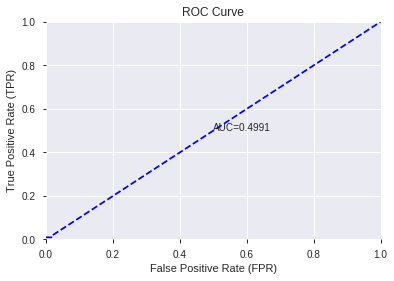

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


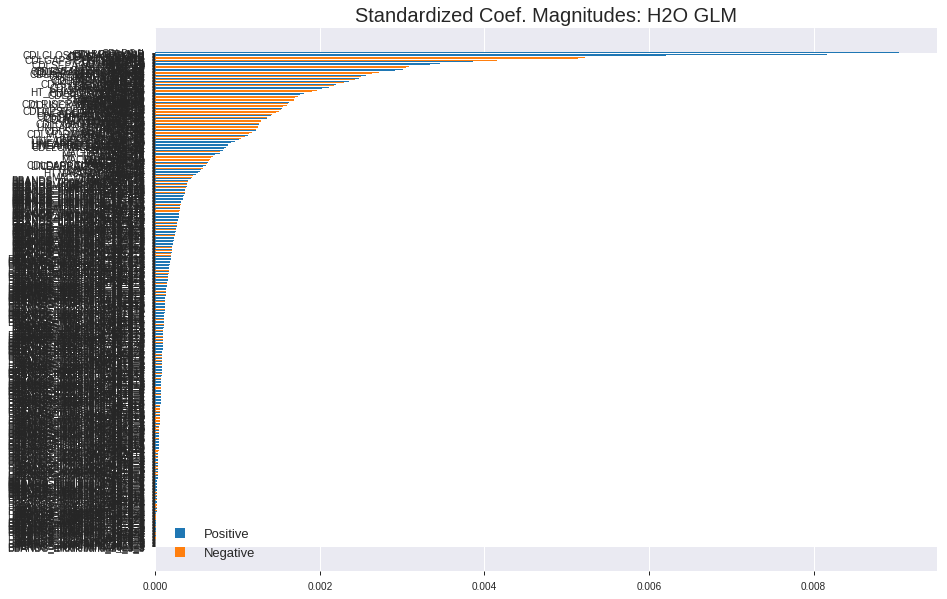

'log_likelihood'
--2019-09-06 01:56:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.212
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.212|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_015610_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_015610_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_9435',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CDLDOJI',
 'CDLBELTHOLD',
 'CDLLONGLINE',
 'CDLCLOSINGMARUBOZU',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'SUB',
 'CDLENGULFING',
 'TRANGE',
 'BOP',
 'NATR_8',
 'CDLGAPSIDESIDEWHITE',
 'NATR_12',
 'NATR_14',
 'ATR_8',
 'CDLHIKKAKE',
 'NATR_20',
 'MINUS_DM_8',
 'CDLHARAMI',
 'NATR_24',
 'CDLSEPARATINGLINES',
 'ATR_12',
 'NATR_30',
 'MINUS_DM_12',
 'MFI_20',
 'ATR_14',
 'MFI_24',
 'ADX_24',
 'MFI_30',
 'CDLEVENINGDOJISTAR',
 'CDLABANDONEDBABY',
 'MINUS_DM_14',
 'PLUS_DM_8',
 'CDLGRAVESTONEDOJI',
 'CDLINVERTEDHAMMER',
 'ADX_20',
 'TAN',
 'MINUS_DM_20',
 'CDLMATCHINGLOW',
 'MINUS_DM_30',
 'ADXR_14',
 'MINUS_DM_24',
 'ATR_20',
 'VAR_14',
 'CDLHARAMICROSS',
 'ADXR_12',
 'WILLR_8',
 'CDLEVENINGSTAR',
 'VAR_12',
 'PLUS_DM_12',
 'DIV',
 'CDLSTICKSANDWICH',
 'ATR_24',
 'STOCHF_fastk',
 'aroondown_12',
 'CDLTASUKIGAP',
 'PLUS_DM_14',
 'BETA_12',
 'CDLMORNINGSTAR',
 'ATR_30',
 'STOCHRSI_fastk',
 'STDDEV_14',
 'STOCH_slowd',
 'ADX_14',
 'DX_30',
 'HT_PHASOR_quadrature',
 'CDLUNIQUE3RIVER',
 'STDDEV_12',

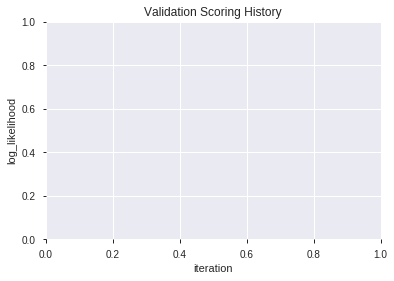

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190906_015648_model_4  0.705182  0.635637              0.319545  0.471104  0.221939
1  XGBoost_grid_1_AutoML_20190906_015648_model_2  0.689727  0.646462              0.335909  0.476706  0.227249
2               XGBoost_3_AutoML_20190906_015648  0.674909  0.646381              0.337273  0.476851  0.227387
3               XGBoost_2_AutoML_20190906_015648  0.674909  0.651681              0.361364  0.479306  0.229734
4               XGBoost_1_AutoML_20190906_015648  0.671818  0.643928              0.418182  0.476076  0.226648
5  XGBoost_grid_1_AutoML_20190906_015648_model_3  0.643818  0.655464              0.438636  0.481592  0.231931
6  XGBoost_grid_1_AutoML_20190906_015648_model_7  0.641182  0.660130              0.459091  0.483791  0.234054
7  XGBoost_grid_1_AutoML_20190906_015648_model_1  0.636000  0.662123              0.407273  0.484950  0.235176
8  XGBoost_grid_1_AutoML_20190906_015648_model_6  0.633091  0.664244              0.410000  0.485717  0.235921
9  XGBoost_grid_1_AutoML_20190906_015648_model_5  0.601455  0.676664              0.473636  0.491851  0.241917

variable  relative_importance  scaled_importance  percentage
0                        DIV           628.003967           1.000000    0.177938
1                        BOP           304.417633           0.484738    0.086253
2               MACDEXT_hist           110.595947           0.176107    0.031336
3                     MFI_24            82.607986           0.131541    0.023406
4                CDLBELTHOLD            81.819633           0.130285    0.023183
..                       ...                  ...                ...         ...
125                STDDEV_20             5.609834           0.008933    0.001589
126  BBANDS_lowerband_30_0_4             5.225864           0.008321    0.001481
127  BBANDS_upperband_12_5_2             4.909978           0.007818    0.001391
128                      SUB             3.443648           0.005483    0.000976
129             aroondown_24             3.151413           0.005018    0.000893

[130 rows x 4 columns]

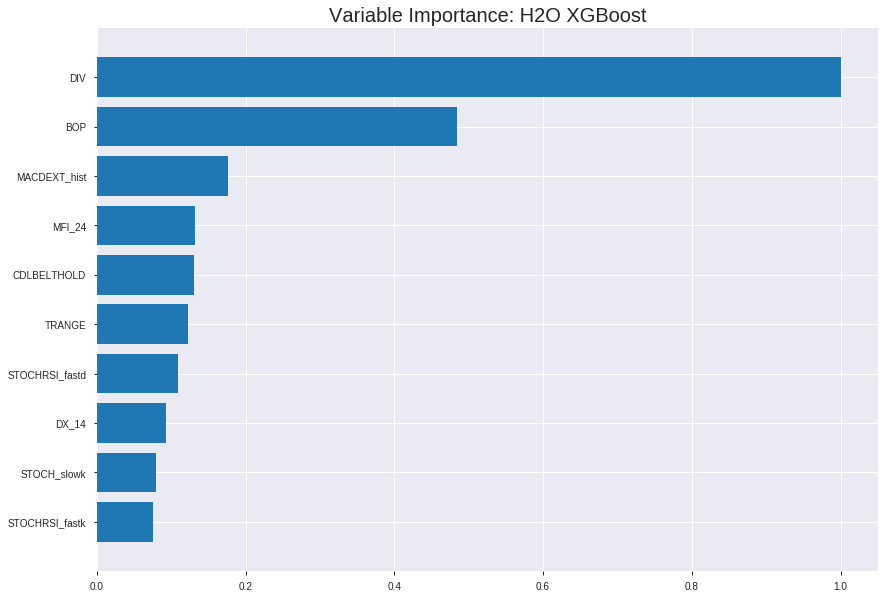

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190906_015648_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.21694072389424085
RMSE: 0.46576895977967536
LogLoss: 0.6237020324587516
Mean Per-Class Error: 0.3622701964788375
AUC: 0.7147672208088182
pr_auc: 0.7667358623246212
Gini: 0.4295344416176363
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4887899061044057: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      219  440   0.6677   (440.0/659.0)
1      65   742   0.0805   (65.0/807.0)
Total  284  1182  0.3445   (505.0/1466.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.48879      0.746104  242
max f2                       0.337482     0.869612  347
max f0point5                 0.499999     0.671573  234
max accuracy                 0.491872     0.656889  239
max precision                0.834766     1         0
max recall                   0.264926     1         388
max specificity              0.834766     1         0
max absolute_mcc             0.491872     0.318415  239
max min_per_class_accuracy   0.501596     0.465923  233
max mean_per_class_accuracy  0.52307      0.63773   214

Gains/Lift Table: Avg response rate: 55.05 %, avg score: 52.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102319                   0.772405           1.8166    1.8166             1                0.789284  1                           0.789284            0.0185874       0.0185874                  81.6605   81.6605
    2        0.0204638                   0.758605           1.8166    1.8166             1                0.766142  1                           0.777713            0.0185874       0.0371747                  81.6605   81.6605
    3        0.0300136                   0.745859           1.8166    1.8166             1                0.751899  1                           0.769499            0.0173482       0.0545229                  81.6605   81.6605
    4        0.0402456                   0.734465           1.45328   1.72423            0.8              0.74156   0.949153                    0.762396            0.0148699       0.0693928                  45.3284   72.4235
    5        0.0504775                   0.723925           1.8166    1.74296            1                0.730046  0.959459                    0.755839            0.0185874       0.0879802                  81.6605   74.2959
    6        0.100273                    0.682431           1.54287   1.64359            0.849315         0.703979  0.904762                    0.730085            0.0768278       0.164808                   54.287    64.3595
    7        0.150068                    0.652331           1.4931    1.59366            0.821918         0.667563  0.877273                    0.709339            0.0743494       0.239157                   49.31     59.3658
    8        0.200546                    0.614052           1.32563   1.5262             0.72973          0.632501  0.840136                    0.689999            0.0669145       0.306072                   32.563    52.6195
    9        0.300136                    0.537076           1.16959   1.40787            0.643836         0.575819  0.775                       0.652112            0.116481        0.422553                   16.9595   40.7869
    10       0.787858                    0.5                0.983253  1.14501            0.541259         0.501705  0.630303                    0.559003            0.479554        0.902107                   -1.67468  14.5011
    11       0.800136                    0.491735           1.00922   1.14293            0.555556         0.495956  0.629156                    0.558035            0.0123916       0.914498                   0.922484  14.2928
    12       0.899727                    0.396854           0.59724   1.08253            0.328767         0.445995  0.595906                    0.545634            0.0594796       0.973978                   -40.276   8.25256
    13       1                           0.207792           0.259515  1                  0.142857         0.329609  0.550477                    0.523972            0.0260223       1                          -74.0485  0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25
RMSE: 0.5
LogLoss: 0.6931471805599462
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    212  1        (212.0/212.0)
1      0    207  0        (0.0/207.0)
Total  0    419  0.506    (212.0/419.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.5          0.661342  0
max f2                       0.5          0.829992  0
max f0point5                 0.5          0.549655  0
max accuracy                 0.5          0.494033  0
max precision                0.5          0.494033  0
max recall                   0.5          1         0
max specificity              0.5          0         0
max absolute_mcc             0.5          0         0
max min_per_class_accuracy   0.5          0         0
max mean_per_class_accuracy  0.5          0.5       0

Gains/Lift Table: Avg response rate: 49.40 %, avg score: 50.00 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score    cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  -------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0.5                1       1                  0.494033         0.5      0.494033                    0.5                 1               1                          0       0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:57:06  7.354 sec   0                  0.5              0.693147            0.5             0                  1                0.449523                         0.5                0.693147              0.5               0                    1                  0.505967
    2019-09-06 01:57:07  7.878 sec   5                  0.487524         0.668435            0.733002        0.765103           1.6955           0.354707                         0.499874           0.692895              0.501037          0.511246             0                  0.486874
    2019-09-06 01:57:07  8.112 sec   10                 0.486978         0.667207            0.658456        0.715083           1.8166           0.371078                         0.5                0.693147              0.5               0                    1                  0.505967
    2019-09-06 01:57:07  8.335 sec   15                 0.482749         0.658671            0.665346        0.725318           1.8166           0.380628                         0.5                0.693147              0.5               0                    1                  0.505967
    2019-09-06 01:57:07  8.565 sec   20                 0.479473         0.651999            0.67207         0.731718           1.8166           0.363574                         0.5                0.693147              0.5               0                    1                  0.505967
    2019-09-06 01:57:08  8.797 sec   25                 0.47689          0.646733            0.681927        0.736749           1.8166           0.361528                         0.5                0.693147              0.5               0                    1                  0.505967
    2019-09-06 01:57:08  9.030 sec   30                 0.480967         0.654498            0.644015        0.715574           1.8166           0.38131                          0.5                0.693147              0.5               0                    1                  0.505967
    2019-09-06 01:57:08  9.256 sec   35                 0.479529         0.651454            0.647259        0.721687           1.8166           0.401774                         0.5                0.693147              0.5               0                    1                  0.505967
    2019-09-06 01:57:08  9.493 sec   40                 0.469874         0.63214             0.696016        0.749802           1.8166           0.364939                         0.498143           0.689421              0.539809          0.570419             0.809662           0.494033
    2019-09-06 01:57:08  9.724 sec   45                 0.467176         0.626409            0.707253        0.75968            1.8166           0.340382                         0.5                0.693147              0.5               0                    1                  0.505967
    2019-09-06 01:57:09  9.961 sec   50                 0.465769         0.623702            0.714767        0.766736           1.8166           0.344475                         0.5                0.693147              0.5               0                    1                  0.505967

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ---------------------
DIV                      628.0039672851562      1.0                    0.17793807993552277
BOP                      304.4176330566406      0.48473839165798527    0.08625341868265532
MACDEXT_hist             110.595947265625       0.17610708375574158    0.031336156346540946
MFI_24                   82.60798645019531      0.13154054871230728    0.023406072671533055
CDLBELTHOLD              81.81963348388672      0.13028521752432667    0.02318270145026061
---                      ---                    ---                    ---
STDDEV_20                5.60983419418335       0.00893280056563099    0.00158948538109533
BBANDS_lowerband_30_0_4  5.225863933563232      0.008321386815682865   0.0014806915923833827
BBANDS_upperband_12_5_2  4.909977912902832      0.00781838677568954    0.0013911887310594795
SUB                      3.443648338317871      0.0054834818213086575  0.0009757202266450058
aroondown_24             3.1514129638671875     0.005018141808069555   0.0008929185181720691


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6904761904761905)

('F1', 0.7509578544061303)

('auc', 0.7051818181818181)

('logloss', 0.6356366347675271)

('mean_per_class_error', 0.3195454545454546)

('rmse', 0.4711036189121382)

('mse', 0.22193861975211313)

xgboost prediction progress: |████████████████████████████████████████████| 100%


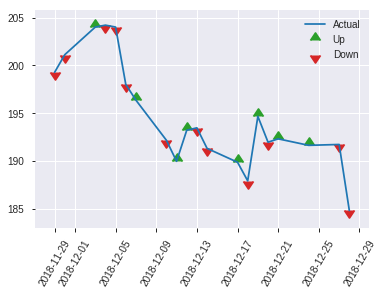


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.22193861975211313
RMSE: 0.4711036189121382
LogLoss: 0.6356366347675271
Mean Per-Class Error: 0.3195454545454546
AUC: 0.7051818181818181
pr_auc: 0.6635331442446045
Gini: 0.41036363636363626
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43913429975509644: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      47   53   0.53     (53.0/100.0)
1      12   98   0.1091   (12.0/110.0)
Total  59   151  0.3095   (65.0/210.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.439134     0.750958  150
max f2                       0.289283     0.854037  203
max f0point5                 0.439134     0.686275  150
max accuracy                 0.439134     0.690476  150
max precision                0.640802     0.758621  28
max recall                   0.289283     1         203
max specificity              0.758498     0.99      0
max absolute_mcc             0.439134     0.401033  150
max min_per_class_accuracy   0.504237     0.64      106
max mean_per_class_accuracy  0.439134     0.680455  150

Gains/Lift Table: Avg response rate: 52.38 %, avg score: 50.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0142857                   0.737112           1.27273   1.27273            0.666667         0.748939  0.666667                    0.748939            0.0181818       0.0181818                  27.2727   27.2727
    2        0.0238095                   0.725468           0.954545  1.14545            0.5              0.732442  0.6                         0.74234             0.00909091      0.0272727                  -4.54545  14.5455
    3        0.0333333                   0.7071             0.954545  1.09091            0.5              0.709499  0.571429                    0.732957            0.00909091      0.0363636                  -4.54545  9.09091
    4        0.0428571                   0.699113           0         0.848485           0                0.703004  0.444444                    0.726301            0               0.0363636                  -100      -15.1515
    5        0.052381                    0.687602           1.90909   1.04132            1                0.692391  0.545455                    0.720135            0.0181818       0.0545455                  90.9091   4.13223
    6        0.1                         0.662385           1.71818   1.36364            0.9              0.676665  0.714286                    0.699435            0.0818182       0.136364                   71.8182   36.3636
    7        0.152381                    0.626626           1.38843   1.37216            0.727273         0.646218  0.71875                     0.681142            0.0727273       0.209091                   38.843    37.2159
    8        0.2                         0.601169           1.52727   1.40909            0.8              0.61601   0.738095                    0.665634            0.0727273       0.281818                   52.7273   40.9091
    9        0.3                         0.565341           1.27273   1.36364            0.666667         0.581068  0.714286                    0.637446            0.127273        0.409091                   27.2727   36.3636
    10       0.4                         0.532573           1.18182   1.31818            0.619048         0.550778  0.690476                    0.615779            0.118182        0.527273                   18.1818   31.8182
    11       0.5                         0.504909           1         1.25455            0.52381          0.517294  0.657143                    0.596082            0.1             0.627273                   0         25.4545
    12       0.6                         0.477494           1.18182   1.24242            0.619048         0.494825  0.650794                    0.579205            0.118182        0.745455                   18.1818   24.2424
    13       0.7                         0.454045           1.18182   1.23377            0.619048         0.465783  0.646259                    0.563002            0.118182        0.863636                   18.1818   23.3766
    14       0.8                         0.387312           0.545455  1.14773            0.285714         0.421185  0.60119                     0.545275            0.0545455       0.918182                   -45.4545  14.7727
    15       0.9                         0.32932            0.454545  1.07071            0.238095         0.357147  0.560847                    0.524372            0.0454545       0.963636                   -54.5455  7.07071
    16       1                           0.2468             0.363636  1                  0.190476         0.295377  0.52381                     0.501473        

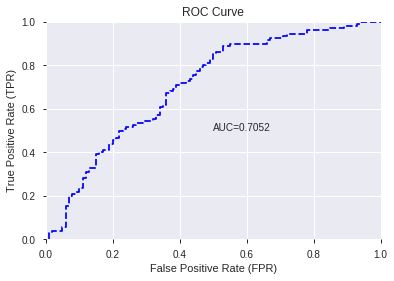

This function is available for GLM models only


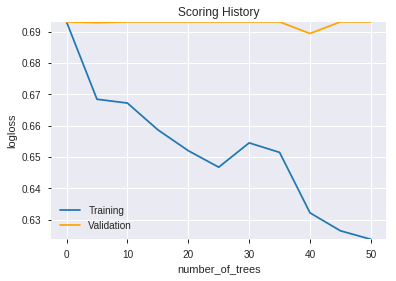

--2019-09-06 01:57:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.163.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.163.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190906_015648_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190906_015648_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_9435',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['DIV',
 'BOP',
 'MACDEXT_hist',
 'MFI_24',
 'CDLBELTHOLD',
 'TRANGE',
 'STOCHRSI_fastd',
 'DX_14',
 'STOCH_slowk',
 'STOCHRSI_fastk',
 'MINUS_DM_8',
 'HT_DCPERIOD',
 'TAN',
 'BETA_12',
 'MACDFIX_hist_24',
 'COS',
 'HT_PHASOR_inphase',
 'STOCHF_fastk',
 'BETA_8',
 'BETA_30',
 'STDDEV_14',
 'NATR_30',
 'ADOSC',
 'ADXR_14',
 'MACDFIX_8',
 'BETA_24',
 'NATR_20',
 'PLUS_DM_12',
 'LINEARREG_ANGLE_12',
 'NATR_12',
 'SIN',
 'MINUS_DI_30',
 'MACDFIX_hist_8',
 'MFI_20',
 'CCI_14',
 'OBV',
 'ADXR_12',
 'STDDEV_12',
 'LINEARREG_ANGLE_24',
 'HT_PHASOR_quadrature',
 'MINUS_DI_8',
 'CORREL_8',
 'DX_8',
 'ROC_8',
 'WILLR_24',
 'STDDEV_24',
 'WILLR_8',
 'MIDPRICE_30',
 'PPO',
 'WILLR_30',
 'MOM_8',
 'CORREL_30',
 'PLUS_DI_14',
 'MACDFIX_signal_24',
 'ADXR_8',
 'AD',
 'LINEARREG_ANGLE_8',
 'PLUS_DI_8',
 'TRIX_14',
 'BETA_14',
 'DX_30',
 'PLUS_DI_30',
 'CORREL_24',
 'PLUS_DI_20',
 'NATR_8',
 'BBANDS_upperband_12_1_5',
 'DX_20',
 'MOM_12',
 'MINUS_DI_20',
 'CCI_8',
 'LINEARREG_ANGLE_14',
 'CORREL_20',
 '

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.700
GLM             0.662
XGBoost         0.705
dtype: float64

DeepLearning    GLM  XGBoost
All          0.529  0.524    0.705
DLF          0.657  0.633    0.676
Fwe          0.700  0.662    0.629
RFE          0.524  0.524    0.690
XGBF         0.648  0.633    0.676





F1


DeepLearning    0.730
GLM             0.722
XGBoost         0.758
dtype: float64

DeepLearning    GLM  XGBoost
All          0.690  0.688    0.758
DLF          0.730  0.720    0.750
Fwe          0.727  0.722    0.725
RFE          0.688  0.688    0.751
XGBF         0.729  0.720    0.750





auc


DeepLearning    0.707
GLM             0.687
XGBoost         0.714
dtype: float64

DeepLearning    GLM  XGBoost
All          0.501  0.499    0.714
DLF          0.660  0.635    0.695
Fwe          0.707  0.687    0.643
RFE          0.516  0.499    0.705
XGBF         0.648  0.635    0.695





logloss


DeepLearning    17.698
GLM             18.064
XGBoost          0.676
dtype: float64

DeepLearning     GLM  XGBoost
All         16.029  18.064    0.640
DLF          0.673   0.709    0.639
Fwe          0.994   0.707    0.676
RFE         17.698  18.064    0.636
XGBF         0.668   0.709    0.639





mean_per_class_error


DeepLearning    0.495
GLM             0.495
XGBoost         0.379
dtype: float64

DeepLearning    GLM  XGBoost
All          0.495  0.495    0.301
DLF          0.343  0.380    0.334
Fwe          0.300  0.345    0.379
RFE          0.483  0.495    0.320
XGBF         0.356  0.380    0.334





rmse


DeepLearning    0.722
GLM             0.724
XGBoost         0.492
dtype: float64

DeepLearning    GLM  XGBoost
All          0.689  0.724    0.473
DLF          0.483  0.490    0.473
Fwe          0.565  0.481    0.492
RFE          0.722  0.724    0.471
XGBF         0.484  0.490    0.473





mse


DeepLearning    0.521
GLM             0.524
XGBoost         0.242
dtype: float64

DeepLearning    GLM  XGBoost
All          0.474  0.524    0.224
DLF          0.234  0.240    0.224
Fwe          0.319  0.232    0.242
RFE          0.521  0.524    0.222
XGBF         0.234  0.240    0.224

{'F1':       DeepLearning    GLM  XGBoost
 All          0.690    NaN      NaN
 DLF          0.730    NaN      NaN
 DLF            NaN  0.720      NaN
 DLF            NaN    NaN    0.750
 All            NaN  0.688      NaN
 All            NaN    NaN    0.758
 XGBF         0.729    NaN      NaN
 XGBF           NaN  0.720      NaN
 XGBF           NaN    NaN    0.750
 Fwe          0.727    NaN      NaN
 Fwe            NaN  0.722      NaN
 Fwe            NaN    NaN    0.725
 RFE          0.688    NaN      NaN
 RFE            NaN  0.688      NaN
 RFE            NaN    NaN    0.751,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.529    NaN      NaN
 DLF          0.657    NaN      NaN
 DLF            NaN  0.633      NaN
 DLF            NaN    NaN    0.676
 All            NaN  0.524      NaN
 All            NaN    NaN    0.705
 XGBF         0.648    NaN      NaN
 XGBF           NaN  0.633      NaN
 XGBF           NaN    NaN    0.676
 Fwe          0.700    NaN      NaN
 Fwe     